<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Semantic_change_Darwin_BMcG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP pipeline on Darwin's letters



Barbara McGillivray

This notebook contains the code for pre-processing the corpus of Darwin letters and train the embeddings. As some of the steps can take a long time to run, it is advisable to only run the first part of this notebook at the beginning of the project.

## Note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/) which can be freely downloaded from https://github.com/cambridge-collection/darwin-correspondence-data ("xml" folder).

# Corpus processing of Darwin letters

## 1. Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0


[notice] A new release of pip available: 22.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


I install the language detection module:

In [2]:
!pip install langdetect


[notice] A new release of pip available: 22.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Download Spacy's English language model:

In [3]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.5 MB/s eta 0:00:00:00:010:01

[notice] A new release of pip available: 22.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Import libraries

In [6]:
import os 
from bs4 import BeautifulSoup
#from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 2. Reading the files

I define the name of the folder containing the unzipped files:

In [4]:
folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/darwin-correspondence-data-main/xml/letters/"

I define the list of all files:

In [7]:
files = os.listdir(folder)
len(files)

15628

We only want xml files:

In [8]:
files = [f for f in files[:] if f.endswith(".xml")]

In [9]:
len(files)

15619

### Extracting the text of the letters

I create the output folder:

In [10]:
out_folder = "/Users/barbaramcgillivray/OneDrive - King's College London/Research/2024/Darwin/data/preprocessed_text/" 

Testing on one letter:

In [12]:

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  #print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action and "9627F" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              #print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              #print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                #print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

                    
     
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
        
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        print([fname, year, sender, receiver, letter_text])
      else:
        print("not sent or received by C. Darwin")                 
        print("sender:", sender)
        print("receiver:", receiver)
        print("letter_text:", letter_text) 
    
    #else:
    #    print("missing corr_action for ", fname) 

Reading file number 2776 DCP-LETT-9627F.xml
['DCP-LETT-9627F.xml', '1874', 'Darwin, C. R.', 'Marshall, W. C.', 'I am very grateful to you. Your observations are excellent, are put most clearly will be very useful to me. I have picked off 16 seeds from this lot! The plant is certainly to a certain extent graninivorous also somewhat graminivorous, though mainly insectivorous. The rain, I know washes off the secretion with it captured insects ( as you say seeds), which are retained by the incurved edges, which then become more incurved. It is a pretty experiment to put a row of flies or cabbage seeds on one margin of a flat leaf see how the edge of the side curls over in from 12 to 24 hours. With cordial thanks | Yours very sincerely | Ch. Darwin—']


We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell** and go straight to section 4.

In [13]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #      break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action: # and "13835" in fname:
      print("Reading file number", str(count), fname)  
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
            #print("0:", year)
          except:
            print("No exact date")
            #For ranges where we knew a letter was before a certain date or after a certain date but not more than that, we tended to use as one end of the range the date we knew related to the letter (in this case 1868), and at the other end we put either Darwin’s birth or death. 
            # So we ignore a notBefore=”1809-01-01” and a notAfter=”1882-12-31”
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
              print("year_not_before:", year_not_before)
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
              print("year_not_after:", year_not_after)
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
                if date_sent_not_before == "1809-01-01" and date_sent_not_after == "1882-12-31":
                    # a file that has the notBefore as D’s birth and the notAfter as D’s death: in this case we might want to exclude the letter completely – if we left the date range as his whole lifetime we really didn’t know when it was written, which makes it a bit useless in any case for tracing semantic change over time.
                    year = ""
                elif date_sent_not_before == "1809-01-01":
                    year = year_not_after
                elif date_sent_not_after == "1882-12-31":
                    year = year_not_before
                else:
                    year = round(float((int(year_not_before)+int(year_not_after))/2))
              
                print("3", year)
            elif date_sent_not_before:
              year = year_not_before
              #print("2", year)
            elif date_sent_not_after:
              year = year_not_after
              #print("1", year)

    
      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year != "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text != "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
        #print(year)
      else:
        print("missing corr_action")                 
     
outfile.close()

Reading file number 1 DCP-LETT-12349.xml
Reading file number 1 DCP-LETT-12349.xml
Reading file number 2 DCP-LETT-13057.xml
Reading file number 2 DCP-LETT-13057.xml
Reading file number 3 DCP-LETT-11898.xml
Reading file number 3 DCP-LETT-11898.xml
Reading file number 4 DCP-LETT-7806.xml
Reading file number 4 DCP-LETT-7806.xml
Reading file number 5 DCP-LETT-11640.xml
Reading file number 5 DCP-LETT-11640.xml
Reading file number 6 DCP-LETT-686.xml
Reading file number 6 DCP-LETT-686.xml
Reading file number 7 DCP-LETT-11126.xml
Reading file number 7 DCP-LETT-11126.xml
Reading file number 8 DCP-LETT-10238.xml
Reading file number 8 DCP-LETT-10238.xml
Reading file number 9 DCP-LETT-9195.xml
Reading file number 9 DCP-LETT-9195.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
Reading file number 10 DCP-LETT-8650F.xml
Reading file number 10 DCP-LETT-8650F.xml
Reading file number 11 DCP-LETT-13731.xml
Reading file number 11 DCP-LETT-13731.xml
Reading file number 12 DCP-LETT-9942F.

Reading file number 98 DCP-LETT-1250.xml
Reading file number 99 DCP-LETT-1536.xml
Reading file number 99 DCP-LETT-1536.xml
Reading file number 100 DCP-LETT-5080A.xml
Reading file number 100 DCP-LETT-5080A.xml
Reading file number 101 DCP-LETT-6259.xml
Reading file number 101 DCP-LETT-6259.xml
Reading file number 102 DCP-LETT-8274.xml
Reading file number 102 DCP-LETT-8274.xml
Reading file number 103 DCP-LETT-7147.xml
Reading file number 103 DCP-LETT-7147.xml
Reading file number 104 DCP-LETT-679.xml
Reading file number 104 DCP-LETT-679.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 105 DCP-LETT-5988.xml
Reading file number 105 DCP-LETT-5988.xml
Reading file number 106 DCP-LETT-3321.xml
Reading file number 106 DCP-LETT-3321.xml
Reading file number 107 DCP-LETT-13138F.xml
Reading file number 107 DCP-LETT-13138F.xml
Reading file number 108 DCP-LETT-5750.xml
Reading file number 108 DCP-LETT-5750.xml
No exact date
year_not_before: 1868
year_not_after: 1

Reading file number 236 DCP-LETT-2229.xml
Reading file number 237 DCP-LETT-4880.xml
Reading file number 237 DCP-LETT-4880.xml
missing corr_action
Reading file number 238 DCP-LETT-10871A.xml
Reading file number 238 DCP-LETT-10871A.xml
Reading file number 239 DCP-LETT-5546.xml
Reading file number 239 DCP-LETT-5546.xml
Reading file number 240 DCP-LETT-7321F.xml
Reading file number 240 DCP-LETT-7321F.xml
Reading file number 241 DCP-LETT-4658.xml
Reading file number 241 DCP-LETT-4658.xml
Reading file number 242 DCP-LETT-3137.xml
Reading file number 242 DCP-LETT-3137.xml
Reading file number 243 DCP-LETT-12981.xml
Reading file number 243 DCP-LETT-12981.xml
Reading file number 244 DCP-LETT-13447.xml
Reading file number 244 DCP-LETT-13447.xml
No exact date
year_not_before: 1881
year_not_after: 1881
3 1881
Reading file number 245 DCP-LETT-12759.xml
Reading file number 245 DCP-LETT-12759.xml
Reading file number 246 DCP-LETT-1867.xml
Reading file number 246 DCP-LETT-1867.xml
Reading file number 24

Reading file number 336 DCP-LETT-2349.xml
Reading file number 337 DCP-LETT-13748A.xml
Reading file number 337 DCP-LETT-13748A.xml
Reading file number 338 DCP-LETT-1640.xml
Reading file number 338 DCP-LETT-1640.xml
Reading file number 339 DCP-LETT-7231.xml
Reading file number 339 DCP-LETT-7231.xml
Reading file number 340 DCP-LETT-8102.xml
Reading file number 340 DCP-LETT-8102.xml
Reading file number 341 DCP-LETT-1898.xml
Reading file number 341 DCP-LETT-1898.xml
Reading file number 342 DCP-LETT-6891.xml
Reading file number 342 DCP-LETT-6891.xml
Reading file number 343 DCP-LETT-269.xml
Reading file number 343 DCP-LETT-269.xml
Reading file number 344 DCP-LETT-7557.xml
Reading file number 344 DCP-LETT-7557.xml
Reading file number 345 DCP-LETT-8664.xml
Reading file number 345 DCP-LETT-8664.xml
Reading file number 346 DCP-LETT-6649.xml
Reading file number 346 DCP-LETT-6649.xml
Reading file number 347 DCP-LETT-2704A.xml
Reading file number 347 DCP-LETT-2704A.xml
Reading file number 348 DCP-LE

Reading file number 471 DCP-LETT-719.xml
Reading file number 472 DCP-LETT-8314.xml
Reading file number 472 DCP-LETT-8314.xml
Reading file number 473 DCP-LETT-7027.xml
Reading file number 473 DCP-LETT-7027.xml
Reading file number 474 DCP-LETT-6339.xml
Reading file number 474 DCP-LETT-6339.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file number 475 DCP-LETT-1456.xml
Reading file number 475 DCP-LETT-1456.xml
Reading file number 476 DCP-LETT-1330.xml
Reading file number 476 DCP-LETT-1330.xml
Reading file number 477 DCP-LETT-7999.xml
Reading file number 477 DCP-LETT-7999.xml
Reading file number 478 DCP-LETT-11907.xml
Reading file number 478 DCP-LETT-11907.xml
Reading file number 479 DCP-LETT-8472.xml
Reading file number 479 DCP-LETT-8472.xml
Reading file number 480 DCP-LETT-7741.xml
Reading file number 480 DCP-LETT-7741.xml
Reading file number 481 DCP-LETT-3527.xml
Reading file number 481 DCP-LETT-3527.xml
Reading file number 482 DCP-LETT-4248.xml
Reading fil

Reading file number 601 DCP-LETT-13122.xml
Reading file number 602 DCP-LETT-13644.xml
Reading file number 602 DCP-LETT-13644.xml
Reading file number 603 DCP-LETT-5802.xml
Reading file number 603 DCP-LETT-5802.xml
Reading file number 604 DCP-LETT-11053.xml
Reading file number 604 DCP-LETT-11053.xml
Reading file number 605 DCP-LETT-12251F.xml
Reading file number 605 DCP-LETT-12251F.xml
Reading file number 606 DCP-LETT-1133.xml
Reading file number 606 DCP-LETT-1133.xml
Reading file number 607 DCP-LETT-8671.xml
Reading file number 607 DCP-LETT-8671.xml
Reading file number 608 DCP-LETT-7542.xml
Reading file number 608 DCP-LETT-7542.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 609 DCP-LETT-6884.xml
Reading file number 609 DCP-LETT-6884.xml
Reading file number 610 DCP-LETT-3724.xml
Reading file number 610 DCP-LETT-3724.xml
Reading file number 611 DCP-LETT-5355.xml
Reading file number 611 DCP-LETT-5355.xml
Reading file number 612 DCP-LETT-5433.xml
Rea

Reading file number 703 DCP-LETT-8856.xml
Reading file number 704 DCP-LETT-9590.xml
Reading file number 704 DCP-LETT-9590.xml
Reading file number 705 DCP-LETT-3903.xml
Reading file number 705 DCP-LETT-3903.xml
Reading file number 706 DCP-LETT-13334.xml
Reading file number 706 DCP-LETT-13334.xml
Reading file number 707 DCP-LETT-13452.xml
Reading file number 707 DCP-LETT-13452.xml
Reading file number 708 DCP-LETT-12994.xml
Reading file number 708 DCP-LETT-12994.xml
Reading file number 709 DCP-LETT-11245.xml
Reading file number 709 DCP-LETT-11245.xml
Reading file number 710 DCP-LETT-1872.xml
Reading file number 710 DCP-LETT-1872.xml
Reading file number 711 DCP-LETT-11251.xml
Reading file number 711 DCP-LETT-11251.xml
Reading file number 712 DCP-LETT-8406F.xml
Reading file number 712 DCP-LETT-8406F.xml
Reading file number 713 DCP-LETT-1866.xml
Reading file number 713 DCP-LETT-1866.xml
Reading file number 714 DCP-LETT-12758.xml
Reading file number 714 DCP-LETT-12758.xml
Reading file number 

No exact date
year_not_before: 1870
year_not_after: 1882
3 1870
Reading file number 798 DCP-LETT-10013.xml
Reading file number 798 DCP-LETT-10013.xml
Reading file number 799 DCP-LETT-5584.xml
Reading file number 799 DCP-LETT-5584.xml
Reading file number 800 DCP-LETT-4842.xml
Reading file number 800 DCP-LETT-4842.xml
Reading file number 801 DCP-LETT-12604.xml
Reading file number 801 DCP-LETT-12604.xml
Reading file number 802 DCP-LETT-12134A.xml
Reading file number 802 DCP-LETT-12134A.xml
Reading file number 803 DCP-LETT-5590.xml
Reading file number 803 DCP-LETT-5590.xml
Reading file number 804 DCP-LETT-4856.xml
Reading file number 804 DCP-LETT-4856.xml
Reading file number 805 DCP-LETT-2508F.xml
Reading file number 805 DCP-LETT-2508F.xml
Reading file number 806 DCP-LETT-12610.xml
Reading file number 806 DCP-LETT-12610.xml
Reading file number 807 DCP-LETT-7387.xml
Reading file number 807 DCP-LETT-7387.xml
Reading file number 808 DCP-LETT-11319.xml
Reading file number 808 DCP-LETT-11319.xm

Reading file number 891 DCP-LETT-11696.xml
Reading file number 892 DCP-LETT-136.xml
Reading file number 892 DCP-LETT-136.xml
Reading file number 893 DCP-LETT-4301.xml
Reading file number 893 DCP-LETT-4301.xml
Reading file number 894 DCP-LETT-7245A.xml
Reading file number 894 DCP-LETT-7245A.xml
Reading file number 895 DCP-LETT-13081.xml
Reading file number 895 DCP-LETT-13081.xml
Reading file number 896 DCP-LETT-9939F.xml
Reading file number 896 DCP-LETT-9939F.xml
Reading file number 897 DCP-LETT-2770.xml
Reading file number 897 DCP-LETT-2770.xml
Reading file number 898 DCP-LETT-4315.xml
Reading file number 898 DCP-LETT-4315.xml
Reading file number 899 DCP-LETT-2764.xml
Reading file number 899 DCP-LETT-2764.xml
Reading file number 900 DCP-LETT-13095.xml
Reading file number 900 DCP-LETT-13095.xml
Reading file number 901 DCP-LETT-9631.xml
Reading file number 901 DCP-LETT-9631.xml
Reading file number 902 DCP-LETT-6502.xml
Reading file number 902 DCP-LETT-6502.xml
Reading file number 903 DCP

Reading file number 1016 DCP-LETT-2772.xml
Reading file number 1017 DCP-LETT-13083.xml
Reading file number 1017 DCP-LETT-13083.xml
Reading file number 1018 DCP-LETT-4303.xml
Reading file number 1018 DCP-LETT-4303.xml
Reading file number 1019 DCP-LETT-134.xml
Reading file number 1019 DCP-LETT-134.xml
No exact date
year_not_before: 1831
year_not_after: 1831
3 1831
Reading file number 1020 DCP-LETT-11694.xml
Reading file number 1020 DCP-LETT-11694.xml
Reading file number 1021 DCP-LETT-8539.xml
Reading file number 1021 DCP-LETT-8539.xml
Reading file number 1022 DCP-LETT-9627.xml
Reading file number 1022 DCP-LETT-9627.xml
Reading file number 1023 DCP-LETT-6514.xml
Reading file number 1023 DCP-LETT-6514.xml
Reading file number 1024 DCP-LETT-9141.xml
Reading file number 1024 DCP-LETT-9141.xml
Reading file number 1025 DCP-LETT-6272.xml
Reading file number 1025 DCP-LETT-6272.xml
Reading file number 1026 DCP-LETT-715F.xml
Reading file number 1026 DCP-LETT-715F.xml
Reading file number 1027 DCP-LE

Reading file number 1116 DCP-LETT-5586.xml
Reading file number 1117 DCP-LETT-10011.xml
Reading file number 1117 DCP-LETT-10011.xml
Reading file number 1118 DCP-LETT-1938.xml
Reading file number 1118 DCP-LETT-1938.xml
Reading file number 1119 DCP-LETT-7391.xml
Reading file number 1119 DCP-LETT-7391.xml
Reading file number 1120 DCP-LETT-11469.xml
Reading file number 1120 DCP-LETT-11469.xml
Reading file number 1121 DCP-LETT-8313A.xml
Reading file number 1121 DCP-LETT-8313A.xml
Reading file number 1122 DCP-LETT-6931.xml
Reading file number 1122 DCP-LETT-6931.xml
Reading file number 1123 DCP-LETT-1086.xml
Reading file number 1123 DCP-LETT-1086.xml
Reading file number 1124 DCP-LETT-10777.xml
Reading file number 1124 DCP-LETT-10777.xml
Reading file number 1125 DCP-LETT-3849.xml
Reading file number 1125 DCP-LETT-3849.xml
Reading file number 1126 DCP-LETT-3691.xml
Reading file number 1126 DCP-LETT-3691.xml
Reading file number 1127 DCP-LETT-12160.xml
Reading file number 1127 DCP-LETT-12160.xml
N

Reading file number 1249 DCP-LETT-3929.xml
Reading file number 1250 DCP-LETT-6689.xml
Reading file number 1250 DCP-LETT-6689.xml
Reading file number 1251 DCP-LETT-10617.xml
Reading file number 1251 DCP-LETT-10617.xml
Reading file number 1252 DCP-LETT-11509.xml
Reading file number 1252 DCP-LETT-11509.xml
Reading file number 1253 DCP-LETT-6851.xml
Reading file number 1253 DCP-LETT-6851.xml
Reading file number 1254 DCP-LETT-2093F.xml
Reading file number 1254 DCP-LETT-2093F.xml
Reading file number 1255 DCP-LETT-4844F.xml
Reading file number 1255 DCP-LETT-4844F.xml
missing corr_action
Reading file number 1256 DCP-LETT-7597.xml
Reading file number 1256 DCP-LETT-7597.xml
Reading file number 1257 DCP-LETT-1858.xml
Reading file number 1257 DCP-LETT-1858.xml
Reading file number 1258 DCP-LETT-13525F.xml
Reading file number 1258 DCP-LETT-13525F.xml
Reading file number 1259 DCP-LETT-10171.xml
Reading file number 1259 DCP-LETT-10171.xml
Reading file number 1260 DCP-LETT-1680.xml
Reading file number 

Reading file number 1385 DCP-LETT-10373.xml
Reading file number 1386 DCP-LETT-7795.xml
Reading file number 1386 DCP-LETT-7795.xml
Reading file number 1387 DCP-LETT-9960.xml
Reading file number 1387 DCP-LETT-9960.xml
Reading file number 1388 DCP-LETT-10415.xml
Reading file number 1388 DCP-LETT-10415.xml
Reading file number 1389 DCP-LETT-5182.xml
Reading file number 1389 DCP-LETT-5182.xml
Reading file number 1390 DCP-LETT-12202.xml
Reading file number 1390 DCP-LETT-12202.xml
Reading file number 1391 DCP-LETT-2835.xml
Reading file number 1391 DCP-LETT-2835.xml
Reading file number 1392 DCP-LETT-3518.xml
Reading file number 1392 DCP-LETT-3518.xml
Reading file number 1393 DCP-LETT-4277.xml
Reading file number 1393 DCP-LETT-4277.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 1394 DCP-LETT-5169.xml
Reading file number 1394 DCP-LETT-5169.xml
Reading file number 1395 DCP-LETT-2606.xml
Reading file number 1395 DCP-LETT-2606.xml
Reading file number 1396 DCP

Reading file number 1484 DCP-LETT-1332.xml
Reading file number 1485 DCP-LETT-1454.xml
Reading file number 1485 DCP-LETT-1454.xml
Reading file number 1486 DCP-LETT-9008.xml
Reading file number 1486 DCP-LETT-9008.xml
Reading file number 1487 DCP-LETT-10514A.xml
Reading file number 1487 DCP-LETT-10514A.xml
Reading file number 1488 DCP-LETT-8316.xml
Reading file number 1488 DCP-LETT-8316.xml
Reading file number 1489 DCP-LETT-7025.xml
Reading file number 1489 DCP-LETT-7025.xml
Reading file number 1490 DCP-LETT-3243.xml
Reading file number 1490 DCP-LETT-3243.xml
Reading file number 1491 DCP-LETT-13874.xml
Reading file number 1491 DCP-LETT-13874.xml
Reading file number 1492 DCP-LETT-5632.xml
Reading file number 1492 DCP-LETT-5632.xml
Reading file number 1493 DCP-LETT-1369F.xml
Reading file number 1493 DCP-LETT-1369F.xml
Reading file number 1494 DCP-LETT-6313.xml
Reading file number 1494 DCP-LETT-6313.xml
Reading file number 1495 DCP-LETT-9020.xml
Reading file number 1495 DCP-LETT-9020.xml
Rea

Reading file number 1612 DCP-LETT-2439.xml
Reading file number 1612 DCP-LETT-2439.xml
Reading file number 1613 DCP-LETT-1118.xml
Reading file number 1613 DCP-LETT-1118.xml
Reading file number 1614 DCP-LETT-8882.xml
Reading file number 1614 DCP-LETT-8882.xml
Reading file number 1615 DCP-LETT-9544.xml
Reading file number 1615 DCP-LETT-9544.xml
Reading file number 1616 DCP-LETT-6677.xml
Reading file number 1616 DCP-LETT-6677.xml
Reading file number 1617 DCP-LETT-10831.xml
Reading file number 1617 DCP-LETT-10831.xml
Reading file number 1618 DCP-LETT-1919A.xml
Reading file number 1618 DCP-LETT-1919A.xml
missing corr_action
Reading file number 1619 DCP-LETT-11217A.xml
Reading file number 1619 DCP-LETT-11217A.xml
Reading file number 1620 DCP-LETT-7569.xml
Reading file number 1620 DCP-LETT-7569.xml
Reading file number 1621 DCP-LETT-257.xml
Reading file number 1621 DCP-LETT-257.xml
Reading file number 1622 DCP-LETT-4060.xml
Reading file number 1622 DCP-LETT-4060.xml
Reading file number 1623 DCP

Reading file number 1743 DCP-LETT-8706.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 1744 DCP-LETT-671A.xml
Reading file number 1744 DCP-LETT-671A.xml
Reading file number 1745 DCP-LETT-9418.xml
Reading file number 1745 DCP-LETT-9418.xml
Reading file number 1746 DCP-LETT-1044.xml
Reading file number 1746 DCP-LETT-1044.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 1747 DCP-LETT-11826F.xml
Reading file number 1747 DCP-LETT-11826F.xml
Reading file number 1748 DCP-LETT-5222.xml
Reading file number 1748 DCP-LETT-5222.xml
Reading file number 1749 DCP-LETT-3653.xml
Reading file number 1749 DCP-LETT-3653.xml
Reading file number 1750 DCP-LETT-11483.xml
Reading file number 1750 DCP-LETT-11483.xml
Reading file number 1751 DCP-LETT-323.xml
Reading file number 1751 DCP-LETT-323.xml
Reading file number 1752 DCP-LETT-10221F.xml
Reading file number 1752 DCP-LETT-10221F.xml
Reading file number 1753 DCP-LETT-10945.xml
Rea

Reading file number 1870 DCP-LETT-2029.xml
No exact date
year_not_before: 1857
year_not_after: 1857
3 1857
Reading file number 1871 DCP-LETT-5746.xml
Reading file number 1871 DCP-LETT-5746.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 1872 DCP-LETT-4458.xml
Reading file number 1872 DCP-LETT-4458.xml
Reading file number 1873 DCP-LETT-3337.xml
Reading file number 1873 DCP-LETT-3337.xml
Reading file number 1874 DCP-LETT-647.xml
Reading file number 1874 DCP-LETT-647.xml
Reading file number 1875 DCP-LETT-7179.xml
Reading file number 1875 DCP-LETT-7179.xml
Reading file number 1876 DCP-LETT-6267.xml
Reading file number 1876 DCP-LETT-6267.xml
Reading file number 1877 DCP-LETT-9154.xml
Reading file number 1877 DCP-LETT-9154.xml
Reading file number 1878 DCP-LETT-1508.xml
Reading file number 1878 DCP-LETT-1508.xml
Reading file number 1879 DCP-LETT-2001.xml
Reading file number 1879 DCP-LETT-2001.xml
Reading file number 1880 DCP-LETT-4470.xml
Reading file n

Reading file number 1970 DCP-LETT-5781.xml
Reading file number 1971 DCP-LETT-8763F.xml
Reading file number 1971 DCP-LETT-8763F.xml
Reading file number 1972 DCP-LETT-12401.xml
Reading file number 1972 DCP-LETT-12401.xml
Reading file number 1973 DCP-LETT-5959.xml
Reading file number 1973 DCP-LETT-5959.xml
Reading file number 1974 DCP-LETT-12367.xml
Reading file number 1974 DCP-LETT-12367.xml
Reading file number 1975 DCP-LETT-3496.xml
Reading file number 1975 DCP-LETT-3496.xml
Reading file number 1976 DCP-LETT-2950.xml
Reading file number 1976 DCP-LETT-2950.xml
Reading file number 1977 DCP-LETT-2788.xml
Reading file number 1977 DCP-LETT-2788.xml
Reading file number 1978 DCP-LETT-13079.xml
Reading file number 1978 DCP-LETT-13079.xml
Reading file number 1979 DCP-LETT-7828.xml
Reading file number 1979 DCP-LETT-7828.xml
Reading file number 1980 DCP-LETT-10570.xml
Reading file number 1980 DCP-LETT-10570.xml
Reading file number 1981 DCP-LETT-1281.xml
Reading file number 1981 DCP-LETT-1281.xml
R

Reading file number 2060 DCP-LETT-5018.xml
Reading file number 2061 DCP-LETT-2777.xml
Reading file number 2061 DCP-LETT-2777.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 2062 DCP-LETT-13086.xml
Reading file number 2062 DCP-LETT-13086.xml
Reading file number 2063 DCP-LETT-12398.xml
Reading file number 2063 DCP-LETT-12398.xml
Reading file number 2064 DCP-LETT-3469.xml
Reading file number 2064 DCP-LETT-3469.xml
Reading file number 2065 DCP-LETT-4306.xml
Reading file number 2065 DCP-LETT-4306.xml
Reading file number 2066 DCP-LETT-131.xml
Reading file number 2066 DCP-LETT-131.xml
Reading file number 2067 DCP-LETT-11691.xml
Reading file number 2067 DCP-LETT-11691.xml
Reading file number 2068 DCP-LETT-9622.xml
Reading file number 2068 DCP-LETT-9622.xml
Reading file number 2069 DCP-LETT-11849.xml
Reading file number 2069 DCP-LETT-11849.xml
Reading file number 2070 DCP-LETT-6511.xml
Reading file number 2070 DCP-LETT-6511.xml
Reading file number 2071 DC

Reading file number 2162 DCP-LETT-7343.xml
Reading file number 2163 DCP-LETT-1732.xml
Reading file number 2163 DCP-LETT-1732.xml
Reading file number 2164 DCP-LETT-9408.xml
Reading file number 2164 DCP-LETT-9408.xml
Reading file number 2165 DCP-LETT-1054.xml
Reading file number 2165 DCP-LETT-1054.xml
Reading file number 2166 DCP-LETT-8716.xml
Reading file number 2166 DCP-LETT-8716.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 2167 DCP-LETT-7425.xml
Reading file number 2167 DCP-LETT-7425.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 2168 DCP-LETT-9719F.xml
Reading file number 2168 DCP-LETT-9719F.xml
Reading file number 2169 DCP-LETT-3643.xml
Reading file number 2169 DCP-LETT-3643.xml
Reading file number 2170 DCP-LETT-5232.xml
Reading file number 2170 DCP-LETT-5232.xml
Reading file number 2171 DCP-LETT-6713.xml
Reading file number 2171 DCP-LETT-6713.xml
Reading file number 2172 DCP-LETT-9420.xml
Reading fi

Reading file number 2301 DCP-LETT-1108.xml
Reading file number 2302 DCP-LETT-8892.xml
Reading file number 2302 DCP-LETT-8892.xml
Reading file number 2303 DCP-LETT-6667.xml
Reading file number 2303 DCP-LETT-6667.xml
Reading file number 2304 DCP-LETT-9554.xml
Reading file number 2304 DCP-LETT-9554.xml
Reading file number 2305 DCP-LETT-11077F.xml
Reading file number 2305 DCP-LETT-11077F.xml
Reading file number 2306 DCP-LETT-2401.xml
Reading file number 2306 DCP-LETT-2401.xml
Reading file number 2307 DCP-LETT-4070.xml
Reading file number 2307 DCP-LETT-4070.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 2308 DCP-LETT-4716.xml
Reading file number 2308 DCP-LETT-4716.xml
Reading file number 2309 DCP-LETT-3079.xml
Reading file number 2309 DCP-LETT-3079.xml
Reading file number 2310 DCP-LETT-12788.xml
Reading file number 2310 DCP-LETT-12788.xml
Reading file number 2311 DCP-LETT-13496.xml
Reading file number 2311 DCP-LETT-13496.xml
Reading file number 2312 

Reading file number 2400 DCP-LETT-1336.xml
Reading file number 2401 DCP-LETT-7747.xml
Reading file number 2401 DCP-LETT-7747.xml
Reading file number 2402 DCP-LETT-8474.xml
Reading file number 2402 DCP-LETT-8474.xml
Reading file number 2403 DCP-LETT-3521.xml
Reading file number 2403 DCP-LETT-3521.xml
Reading file number 2404 DCP-LETT-5150.xml
Reading file number 2404 DCP-LETT-5150.xml
Reading file number 2405 DCP-LETT-3535.xml
Reading file number 2405 DCP-LETT-3535.xml
Reading file number 2406 DCP-LETT-5144.xml
Reading file number 2406 DCP-LETT-5144.xml
Reading file number 2407 DCP-LETT-6507F.xml
Reading file number 2407 DCP-LETT-6507F.xml
Reading file number 2408 DCP-LETT-11915.xml
Reading file number 2408 DCP-LETT-11915.xml
Reading file number 2409 DCP-LETT-1322.xml
Reading file number 2409 DCP-LETT-1322.xml
Reading file number 2410 DCP-LETT-7753.xml
Reading file number 2410 DCP-LETT-7753.xml
Reading file number 2411 DCP-LETT-8460.xml
Reading file number 2411 DCP-LETT-8460.xml
Reading

Reading file number 2535 DCP-LETT-939.xml
No exact date
year_not_before: 1846
year_not_after: 1846
3 1846
Reading file number 2536 DCP-LETT-13656.xml
Reading file number 2536 DCP-LETT-13656.xml
Reading file number 2537 DCP-LETT-12548.xml
Reading file number 2537 DCP-LETT-12548.xml
Reading file number 2538 DCP-LETT-5810.xml
Reading file number 2538 DCP-LETT-5810.xml
Reading file number 2539 DCP-LETT-2819.xml
Reading file number 2539 DCP-LETT-2819.xml
Reading file number 2540 DCP-LETT-13130.xml
Reading file number 2540 DCP-LETT-13130.xml
Reading file number 2541 DCP-LETT-7961.xml
Reading file number 2541 DCP-LETT-7961.xml
Reading file number 2542 DCP-LETT-10439.xml
Reading file number 2542 DCP-LETT-10439.xml
Reading file number 2543 DCP-LETT-9794.xml
Reading file number 2543 DCP-LETT-9794.xml
No exact date
year_not_before: 1869
year_not_after: 1875
3 1872
Reading file number 2544 DCP-LETT-11727.xml
Reading file number 2544 DCP-LETT-11727.xml
Reading file number 2545 DCP-LETT-12206.xml
Re

Reading file number 2622 DCP-LETT-13748F.xml
Reading file number 2623 DCP-LETT-3050.xml
Reading file number 2623 DCP-LETT-3050.xml
Reading file number 2624 DCP-LETT-4059.xml
Reading file number 2624 DCP-LETT-4059.xml
No exact date
year_not_before: 1863
year_not_after: 1863
3 1863
Reading file number 2625 DCP-LETT-3736.xml
Reading file number 2625 DCP-LETT-3736.xml
Reading file number 2626 DCP-LETT-2428.xml
Reading file number 2626 DCP-LETT-2428.xml
Reading file number 2627 DCP-LETT-5347.xml
Reading file number 2627 DCP-LETT-5347.xml
Reading file number 2628 DCP-LETT-1121.xml
Reading file number 2628 DCP-LETT-1121.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 2629 DCP-LETT-6896.xml
Reading file number 2629 DCP-LETT-6896.xml
Reading file number 2630 DCP-LETT-7550.xml
Reading file number 2630 DCP-LETT-7550.xml
Reading file number 2631 DCP-LETT-8663.xml
Reading file number 2631 DCP-LETT-8663.xml
Reading file number 2632 DCP-LETT-10808.xml
Reading f

Reading file number 2716 DCP-LETT-6706.xml
Reading file number 2717 DCP-LETT-13291.xml
Reading file number 2717 DCP-LETT-13291.xml
Reading file number 2718 DCP-LETT-2560.xml
Reading file number 2718 DCP-LETT-2560.xml
Reading file number 2719 DCP-LETT-4111.xml
Reading file number 2719 DCP-LETT-4111.xml
Reading file number 2720 DCP-LETT-8938A.xml
Reading file number 2720 DCP-LETT-8938A.xml
No exact date
year_not_before: 1873
year_not_after: 1882
3 1873
Reading file number 2721 DCP-LETT-4279F.xml
Reading file number 2721 DCP-LETT-4279F.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 2722 DCP-LETT-2574.xml
Reading file number 2722 DCP-LETT-2574.xml
Reading file number 2723 DCP-LETT-13285.xml
Reading file number 2723 DCP-LETT-13285.xml
Reading file number 2724 DCP-LETT-4105.xml
Reading file number 2724 DCP-LETT-4105.xml
Reading file number 2725 DCP-LETT-10954.xml
Reading file number 2725 DCP-LETT-10954.xml
Reading file number 2726 DCP-LETT-332.xml
Rea

Reading file number 2850 DCP-LETT-9623.xml
Reading file number 2851 DCP-LETT-11848.xml
Reading file number 2851 DCP-LETT-11848.xml
Reading file number 2852 DCP-LETT-11690.xml
Reading file number 2852 DCP-LETT-11690.xml
Reading file number 2853 DCP-LETT-130.xml
Reading file number 2853 DCP-LETT-130.xml
Reading file number 2854 DCP-LETT-4307.xml
Reading file number 2854 DCP-LETT-4307.xml
missing corr_action
Reading file number 2855 DCP-LETT-3468.xml
Reading file number 2855 DCP-LETT-3468.xml
Reading file number 2856 DCP-LETT-12399.xml
Reading file number 2856 DCP-LETT-12399.xml
Reading file number 2857 DCP-LETT-7402F.xml
Reading file number 2857 DCP-LETT-7402F.xml
Reading file number 2858 DCP-LETT-13087.xml
Reading file number 2858 DCP-LETT-13087.xml
Reading file number 2859 DCP-LETT-2776.xml
Reading file number 2859 DCP-LETT-2776.xml
Reading file number 2860 DCP-LETT-5019.xml
Reading file number 2860 DCP-LETT-5019.xml
Reading file number 2861 DCP-LETT-11860.xml
Reading file number 2861 

Reading file number 2954 DCP-LETT-3497.xml
Reading file number 2955 DCP-LETT-12366.xml
Reading file number 2955 DCP-LETT-12366.xml
Reading file number 2956 DCP-LETT-13708.xml
Reading file number 2956 DCP-LETT-13708.xml
Reading file number 2957 DCP-LETT-5796.xml
Reading file number 2957 DCP-LETT-5796.xml
Reading file number 2958 DCP-LETT-4488.xml
Reading file number 2958 DCP-LETT-4488.xml
No exact date
year_not_before: 1864
year_not_after: 1882
3 1864
missing corr_action
Reading file number 2959 DCP-LETT-12416.xml
Reading file number 2959 DCP-LETT-12416.xml
Reading file number 2960 DCP-LETT-7181.xml
Reading file number 2960 DCP-LETT-7181.xml
Reading file number 2961 DCP-LETT-867.xml
Reading file number 2961 DCP-LETT-867.xml
Reading file number 2962 DCP-LETT-13289A.xml
Reading file number 2962 DCP-LETT-13289A.xml
Reading file number 2963 DCP-LETT-10201.xml
Reading file number 2963 DCP-LETT-10201.xml
Reading file number 2964 DCP-LETT-1296.xml
Reading file number 2964 DCP-LETT-1296.xml
No 

Reading file number 3055 DCP-LETT-6506.xml
Reading file number 3056 DCP-LETT-9635.xml
Reading file number 3056 DCP-LETT-9635.xml
Reading file number 3057 DCP-LETT-13091.xml
Reading file number 3057 DCP-LETT-13091.xml
Reading file number 3058 DCP-LETT-2760.xml
Reading file number 3058 DCP-LETT-2760.xml
Reading file number 3059 DCP-LETT-12929F.xml
Reading file number 3059 DCP-LETT-12929F.xml
Reading file number 3060 DCP-LETT-4311.xml
Reading file number 3060 DCP-LETT-4311.xml
Reading file number 3061 DCP-LETT-2774.xml
Reading file number 3061 DCP-LETT-2774.xml
Reading file number 3062 DCP-LETT-13085.xml
Reading file number 3062 DCP-LETT-13085.xml
Reading file number 3063 DCP-LETT-4305.xml
Reading file number 3063 DCP-LETT-4305.xml
Reading file number 3064 DCP-LETT-763F.xml
Reading file number 3064 DCP-LETT-763F.xml
No exact date
year_not_before: 1844
year_not_after: 1844
3 1844
Reading file number 3065 DCP-LETT-132.xml
Reading file number 3065 DCP-LETT-132.xml
Reading file number 3066 DC

Reading file number 3156 DCP-LETT-8067.xml
Reading file number 3157 DCP-LETT-1725.xml
Reading file number 3157 DCP-LETT-1725.xml
Reading file number 3158 DCP-LETT-9379.xml
Reading file number 3158 DCP-LETT-9379.xml
Reading file number 3159 DCP-LETT-5543.xml
Reading file number 3159 DCP-LETT-5543.xml
Reading file number 3160 DCP-LETT-4885.xml
Reading file number 3160 DCP-LETT-4885.xml
Reading file number 3161 DCP-LETT-3132.xml
Reading file number 3161 DCP-LETT-3132.xml
Reading file number 3162 DCP-LETT-3654.xml
Reading file number 3162 DCP-LETT-3654.xml
Reading file number 3163 DCP-LETT-5225.xml
Reading file number 3163 DCP-LETT-5225.xml
Reading file number 3164 DCP-LETT-1043.xml
Reading file number 3164 DCP-LETT-1043.xml
No exact date
year_not_before: 1847
year_not_after: 1847
3 1847
Reading file number 3165 DCP-LETT-3174F.xml
Reading file number 3165 DCP-LETT-3174F.xml
Reading file number 3166 DCP-LETT-7432.xml
Reading file number 3166 DCP-LETT-7432.xml
Reading file number 3167 DCP-LE

Reading file number 3296 DCP-LETT-3708.xml
Reading file number 3297 DCP-LETT-4067.xml
Reading file number 3297 DCP-LETT-4067.xml
Reading file number 3298 DCP-LETT-10836.xml
Reading file number 3298 DCP-LETT-10836.xml
Reading file number 3299 DCP-LETT-250.xml
Reading file number 3299 DCP-LETT-250.xml
Reading file number 3300 DCP-LETT-8885.xml
Reading file number 3300 DCP-LETT-8885.xml
Reading file number 3301 DCP-LETT-9543.xml
Reading file number 3301 DCP-LETT-9543.xml
Reading file number 3302 DCP-LETT-6670.xml
Reading file number 3302 DCP-LETT-6670.xml
Reading file number 3303 DCP-LETT-9225.xml
Reading file number 3303 DCP-LETT-9225.xml
Reading file number 3304 DCP-LETT-6116.xml
Reading file number 3304 DCP-LETT-6116.xml
Reading file number 3305 DCP-LETT-10188.xml
Reading file number 3305 DCP-LETT-10188.xml
Reading file number 3306 DCP-LETT-1679.xml
Reading file number 3306 DCP-LETT-1679.xml
Reading file number 3307 DCP-LETT-13380F.xml
Reading file number 3307 DCP-LETT-13380F.xml
No ex

Reading file number 3389 DCP-LETT-11755F.xml
Reading file number 3390 DCP-LETT-3250.xml
Reading file number 3390 DCP-LETT-3250.xml
Reading file number 3391 DCP-LETT-13867.xml
Reading file number 3391 DCP-LETT-13867.xml
Reading file number 3392 DCP-LETT-4259.xml
Reading file number 3392 DCP-LETT-4259.xml
Reading file number 3393 DCP-LETT-3536.xml
Reading file number 3394 DCP-LETT-2628.xml
Reading file number 3394 DCP-LETT-2628.xml
Reading file number 3395 DCP-LETT-5147.xml
Reading file number 3395 DCP-LETT-5147.xml
Reading file number 3396 DCP-LETT-11916.xml
Reading file number 3396 DCP-LETT-11916.xml
Reading file number 3397 DCP-LETT-1321.xml
Reading file number 3397 DCP-LETT-1321.xml
Reading file number 3398 DCP-LETT-7988.xml
Reading file number 3398 DCP-LETT-7988.xml
Reading file number 3399 DCP-LETT-8463.xml
Reading file number 3399 DCP-LETT-8463.xml
Reading file number 3400 DCP-LETT-7750.xml
Reading file number 3400 DCP-LETT-7750.xml
Reading file number 3401 DCP-LETT-9769.xml
Readi

Reading file number 3491 DCP-LETT-11903.xml
Reading file number 3492 DCP-LETT-1452.xml
Reading file number 3492 DCP-LETT-1452.xml
Reading file number 3493 DCP-LETT-7023.xml
Reading file number 3493 DCP-LETT-7023.xml
Reading file number 3494 DCP-LETT-8310.xml
Reading file number 3494 DCP-LETT-8310.xml
Reading file number 3495 DCP-LETT-13872.xml
Reading file number 3495 DCP-LETT-13872.xml
Reading file number 3496 DCP-LETT-3245.xml
Reading file number 3496 DCP-LETT-3245.xml
Reading file number 3497 DCP-LETT-10132A.xml
Reading file number 3497 DCP-LETT-10132A.xml
Reading file number 3498 DCP-LETT-12694F.xml
Reading file number 3498 DCP-LETT-12694F.xml
Reading file number 3499 DCP-LETT-5634.xml
Reading file number 3499 DCP-LETT-5634.xml
Reading file number 3500 DCP-LETT-13866.xml
Reading file number 3500 DCP-LETT-13866.xml
Reading file number 3501 DCP-LETT-3251.xml
Reading file number 3501 DCP-LETT-3251.xml
Reading file number 3502 DCP-LETT-5620.xml
Reading file number 3502 DCP-LETT-5620.xm

Reading file number 3623 DCP-LETT-5350.xml
Reading file number 3623 DCP-LETT-5350.xml
Reading file number 3624 DCP-LETT-1579A.xml
Reading file number 3624 DCP-LETT-1579A.xml
Reading file number 3625 DCP-LETT-3735.xml
Reading file number 3625 DCP-LETT-3735.xml
Reading file number 3626 DCP-LETT-5344.xml
Reading file number 3627 DCP-LETT-1122.xml
Reading file number 3627 DCP-LETT-1122.xml
Reading file number 3628 DCP-LETT-2837F.xml
Reading file number 3628 DCP-LETT-2837F.xml
Reading file number 3629 DCP-LETT-6895.xml
Reading file number 3629 DCP-LETT-6895.xml
Reading file number 3630 DCP-LETT-8660.xml
Reading file number 3630 DCP-LETT-8660.xml
Reading file number 3631 DCP-LETT-7553.xml
Reading file number 3631 DCP-LETT-7553.xml
Reading file number 3632 DCP-LETT-8106.xml
Reading file number 3632 DCP-LETT-8106.xml
Reading file number 3633 DCP-LETT-7235.xml
Reading file number 3633 DCP-LETT-7235.xml
Reading file number 3634 DCP-LETT-1644.xml
Reading file number 3634 DCP-LETT-1644.xml
No exac

Reading file number 3726 DCP-LETT-9350.xml
Reading file number 3726 DCP-LETT-9350.xml
Reading file number 3727 DCP-LETT-443.xml
Reading file number 3727 DCP-LETT-443.xml
Reading file number 3728 DCP-LETT-3133.xml
Reading file number 3728 DCP-LETT-3133.xml
Reading file number 3729 DCP-LETT-4884.xml
Reading file number 3729 DCP-LETT-4884.xml
Reading file number 3730 DCP-LETT-5542.xml
Reading file number 3730 DCP-LETT-5542.xml
Reading file number 3731 DCP-LETT-9378.xml
Reading file number 3732 DCP-LETT-1724.xml
Reading file number 3732 DCP-LETT-1724.xml
Reading file number 3733 DCP-LETT-45A.xml
Reading file number 3733 DCP-LETT-45A.xml
Reading file number 3734 DCP-LETT-8066.xml
Reading file number 3734 DCP-LETT-8066.xml
Reading file number 3735 DCP-LETT-7355.xml
Reading file number 3735 DCP-LETT-7355.xml
Reading file number 3736 DCP-LETT-8700.xml
Reading file number 3736 DCP-LETT-8700.xml
missing corr_action
Reading file number 3737 DCP-LETT-7433.xml
Reading file number 3737 DCP-LETT-7433

Reading file number 3862 DCP-LETT-6249.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 3863 DCP-LETT-5740.xml
Reading file number 3863 DCP-LETT-5740.xml
Reading file number 3864 DCP-LETT-3331.xml
Reading file number 3864 DCP-LETT-3331.xml
Reading file number 3865 DCP-LETT-5998.xml
Reading file number 3865 DCP-LETT-5998.xml
Reading file number 3866 DCP-LETT-5754.xml
Reading file number 3867 DCP-LETT-3325.xml
Reading file number 3867 DCP-LETT-3325.xml
Reading file number 3868 DCP-LETT-7143.xml
Reading file number 3868 DCP-LETT-7143.xml
Reading file number 3869 DCP-LETT-8270.xml
Reading file number 3869 DCP-LETT-8270.xml
Reading file number 3870 DCP-LETT-1532.xml
Reading file number 3870 DCP-LETT-1532.xml
Reading file number 3871 DCP-LETT-9608.xml
Reading file number 3871 DCP-LETT-9608.xml
Reading file number 3872 DCP-LETT-11863.xml
Reading file number 3872 DCP-LETT-11863.xml
Reading file number 3873 DCP-LETT-1254.xml
Reading file number 3873 DCP-LE

Reading file number 3964 DCP-LETT-12316.xml
Reading file number 3965 DCP-LETT-13008.xml
Reading file number 3965 DCP-LETT-13008.xml
Reading file number 3966 DCP-LETT-5096.xml
Reading file number 3966 DCP-LETT-5096.xml
Reading file number 3967 DCP-LETT-7859.xml
Reading file number 3967 DCP-LETT-7859.xml
Reading file number 3968 DCP-LETT-10501.xml
Reading file number 3968 DCP-LETT-10501.xml
Reading file number 3969 DCP-LETT-9874.xml
Reading file number 3969 DCP-LETT-9874.xml
Reading file number 3970 DCP-LETT-7681.xml
Reading file number 3970 DCP-LETT-7681.xml
Reading file number 3971 DCP-LETT-10515.xml
Reading file number 3971 DCP-LETT-10515.xml
Reading file number 3972 DCP-LETT-9860.xml
Reading file number 3972 DCP-LETT-9860.xml
Reading file number 3973 DCP-LETT-7695.xml
Reading file number 3973 DCP-LETT-7695.xml
Reading file number 3974 DCP-LETT-2935.xml
Reading file number 3974 DCP-LETT-2935.xml
Reading file number 3975 DCP-LETT-12302.xml
Reading file number 3975 DCP-LETT-12302.xml
Re

Reading file number 4097 DCP-LETT-3829.xml
No exact date
year_not_before: 1862
year_not_after: 1882
3 1862
Reading file number 4098 DCP-LETT-12100.xml
Reading file number 4098 DCP-LETT-12100.xml
Reading file number 4099 DCP-LETT-7497.xml
Reading file number 4099 DCP-LETT-7497.xml
Reading file number 4100 DCP-LETT-11409.xml
Reading file number 4100 DCP-LETT-11409.xml
Reading file number 4101 DCP-LETT-6951.xml
Reading file number 4101 DCP-LETT-6951.xml
Reading file number 4102 DCP-LETT-10717.xml
Reading file number 4102 DCP-LETT-10717.xml
Reading file number 4103 DCP-LETT-6789.xml
Reading file number 4103 DCP-LETT-6789.xml
Reading file number 4104 DCP-LETT-8997.xml
Reading file number 4104 DCP-LETT-8997.xml
Reading file number 4105 DCP-LETT-6762.xml
Reading file number 4105 DCP-LETT-6762.xml
Reading file number 4106 DCP-LETT-9451.xml
Reading file number 4106 DCP-LETT-9451.xml
Reading file number 4107 DCP-LETT-10924.xml
Reading file number 4107 DCP-LETT-10924.xml
Reading file number 4108 

Reading file number 4232 DCP-LETT-10850.xml
Reading file number 4233 DCP-LETT-6616.xml
Reading file number 4233 DCP-LETT-6616.xml
Reading file number 4234 DCP-LETT-9525.xml
Reading file number 4234 DCP-LETT-9525.xml
No exact date
year_not_before: 1809
year_not_after: 1874
3 1874
missing corr_action
Reading file number 4235 DCP-LETT-10688.xml
Reading file number 4235 DCP-LETT-10688.xml
Reading file number 4236 DCP-LETT-1179.xml
Reading file number 4236 DCP-LETT-1179.xml
Reading file number 4237 DCP-LETT-2470.xml
Reading file number 4237 DCP-LETT-2470.xml
Reading file number 4238 DCP-LETT-13381.xml
Reading file number 4238 DCP-LETT-13381.xml
Reading file number 4239 DCP-LETT-9909F.xml
Reading file number 4239 DCP-LETT-9909F.xml
Reading file number 4240 DCP-LETT-4001.xml
Reading file number 4240 DCP-LETT-4001.xml
Reading file number 4241 DCP-LETT-3008.xml
Reading file number 4241 DCP-LETT-3008.xml
Reading file number 4242 DCP-LETT-4767.xml
Reading file number 4242 DCP-LETT-4767.xml
Readin

Reading file number 4332 DCP-LETT-2855.xml
Reading file number 4333 DCP-LETT-9900.xml
Reading file number 4333 DCP-LETT-9900.xml
Reading file number 4334 DCP-LETT-1384.xml
Reading file number 4334 DCP-LETT-1384.xml
Reading file number 4335 DCP-LETT-10475.xml
Reading file number 4335 DCP-LETT-10475.xml
Reading file number 4336 DCP-LETT-9914.xml
Reading file number 4336 DCP-LETT-9914.xml
Reading file number 4337 DCP-LETT-7939.xml
Reading file number 4337 DCP-LETT-7939.xml
Reading file number 4338 DCP-LETT-10461.xml
Reading file number 4338 DCP-LETT-10461.xml
Reading file number 4339 DCP-LETT-1390.xml
Reading file number 4339 DCP-LETT-1390.xml
Reading file number 4340 DCP-LETT-2699.xml
Reading file number 4340 DCP-LETT-2699.xml
Reading file number 4341 DCP-LETT-13168.xml
Reading file number 4341 DCP-LETT-13168.xml
Reading file number 4342 DCP-LETT-12276.xml
Reading file number 4342 DCP-LETT-12276.xml
Reading file number 4343 DCP-LETT-3587.xml
Reading file number 4343 DCP-LETT-3587.xml
Rea

Reading file number 4430 DCP-LETT-5134.xml
missing corr_action
Reading file number 4431 DCP-LETT-2883.xml
Reading file number 4431 DCP-LETT-2883.xml
Reading file number 4432 DCP-LETT-3545.xml
Reading file number 4432 DCP-LETT-3545.xml
Reading file number 4433 DCP-LETT-3223.xml
Reading file number 4433 DCP-LETT-3223.xml
Reading file number 4434 DCP-LETT-13814.xml
Reading file number 4434 DCP-LETT-13814.xml
No exact date
year_not_before: 1846
year_not_after: 1854
3 1850
Reading file number 4435 DCP-LETT-5652.xml
Reading file number 4435 DCP-LETT-5652.xml
Reading file number 4436 DCP-LETT-1434.xml
Reading file number 4436 DCP-LETT-1434.xml
Reading file number 4437 DCP-LETT-9068.xml
Reading file number 4437 DCP-LETT-9068.xml
Reading file number 4438 DCP-LETT-10289F.xml
Reading file number 4438 DCP-LETT-10289F.xml
Reading file number 4439 DCP-LETT-8376.xml
Reading file number 4439 DCP-LETT-8376.xml
Reading file number 4440 DCP-LETT-7045.xml
Reading file number 4440 DCP-LETT-7045.xml
No exac

Reading file number 4528 DCP-LETT-7904.xml
Reading file number 4529 DCP-LETT-11742.xml
Reading file number 4529 DCP-LETT-11742.xml
Reading file number 4530 DCP-LETT-9929.xml
Reading file number 4530 DCP-LETT-9929.xml
Reading file number 4531 DCP-LETT-13155.xml
Reading file number 4531 DCP-LETT-13155.xml
Reading file number 4532 DCP-LETT-3581F.xml
Reading file number 4532 DCP-LETT-3581F.xml
Reading file number 4533 DCP-LETT-83.xml
Reading file number 4533 DCP-LETT-83.xml
Reading file number 4534 DCP-LETT-13633.xml
Reading file number 4534 DCP-LETT-13633.xml
missing corr_action
Reading file number 4535 DCP-LETT-5875.xml
Reading file number 4535 DCP-LETT-5875.xml
Reading file number 4536 DCP-LETT-11883A.xml
Reading file number 4536 DCP-LETT-11883A.xml
No exact date
year_not_before: 1879
year_not_after: 1879
3 1879
Reading file number 4537 DCP-LETT-8389.xml
Reading file number 4537 DCP-LETT-8389.xml
Reading file number 4538 DCP-LETT-784.xml
Reading file number 4538 DCP-LETT-784.xml
Reading

Reading file number 4662 DCP-LETT-3960.xml
No exact date
year_not_before: 1809
year_not_after: 1863
3 1863
Reading file number 4663 DCP-LETT-13357.xml
Reading file number 4663 DCP-LETT-13357.xml
Reading file number 4664 DCP-LETT-12049.xml
Reading file number 4664 DCP-LETT-12049.xml
Reading file number 4665 DCP-LETT-10886.xml
Reading file number 4665 DCP-LETT-10886.xml
Reading file number 4666 DCP-LETT-11540.xml
Reading file number 4666 DCP-LETT-11540.xml
Reading file number 4667 DCP-LETT-6818.xml
Reading file number 4667 DCP-LETT-6818.xml
Reading file number 4668 DCP-LETT-8835.xml
Reading file number 4668 DCP-LETT-8835.xml
Reading file number 4669 DCP-LETT-10892.xml
Reading file number 4669 DCP-LETT-10892.xml
Reading file number 4670 DCP-LETT-11554.xml
Reading file number 4670 DCP-LETT-11554.xml
Reading file number 4671 DCP-LETT-8821.xml
Reading file number 4671 DCP-LETT-8821.xml
Reading file number 4672 DCP-LETT-3974.xml
Reading file number 4672 DCP-LETT-3974.xml
Reading file number 4

Reading file number 4797 DCP-LETT-6978.xml
Reading file number 4798 DCP-LETT-12129.xml
Reading file number 4798 DCP-LETT-12129.xml
No exact date
year_not_before: 1879
year_not_after: 1882
3 1879
Reading file number 4799 DCP-LETT-13237.xml
Reading file number 4799 DCP-LETT-13237.xml
Reading file number 4800 DCP-LETT-3800.xml
Reading file number 4800 DCP-LETT-3800.xml
Reading file number 4801 DCP-LETT-12897.xml
Reading file number 4801 DCP-LETT-12897.xml
Reading file number 4802 DCP-LETT-4809.xml
Reading file number 4802 DCP-LETT-4809.xml
Reading file number 4803 DCP-LETT-13551.xml
Reading file number 4803 DCP-LETT-13551.xml
Reading file number 4804 DCP-LETT-1971.xml
Reading file number 4804 DCP-LETT-1971.xml
Reading file number 4805 DCP-LETT-11346.xml
Reading file number 4805 DCP-LETT-11346.xml
Reading file number 4806 DCP-LETT-10058.xml
Reading file number 4806 DCP-LETT-10058.xml
Reading file number 4807 DCP-LETT-1226.xml
Reading file number 4807 DCP-LETT-1226.xml
Reading file number 4

Reading file number 4910 DCP-LETT-828.xml
Reading file number 4911 DCP-LETT-11150.xml
Reading file number 4911 DCP-LETT-11150.xml
Reading file number 4912 DCP-LETT-11144.xml
Reading file number 4912 DCP-LETT-11144.xml
Reading file number 4913 DCP-LETT-5915.xml
Reading file number 4913 DCP-LETT-5915.xml
Reading file number 4914 DCP-LETT-13753.xml
Reading file number 4914 DCP-LETT-13753.xml
Reading file number 4915 DCP-LETT-13035.xml
Reading file number 4915 DCP-LETT-13035.xml
Reading file number 4916 DCP-LETT-11622.xml
Reading file number 4916 DCP-LETT-11622.xml
Reading file number 4917 DCP-LETT-182.xml
Reading file number 4917 DCP-LETT-182.xml
Reading file number 4918 DCP-LETT-9849.xml
Reading file number 4918 DCP-LETT-9849.xml
Reading file number 4919 DCP-LETT-7864.xml
Reading file number 4919 DCP-LETT-7864.xml
Reading file number 4920 DCP-LETT-9691.xml
Reading file number 4920 DCP-LETT-9691.xml
Reading file number 4921 DCP-LETT-11152.xml
Reading file number 4921 DCP-LETT-11152.xml
mi

Reading file number 5006 DCP-LETT-1542.xml
Reading file number 5007 DCP-LETT-8200.xml
Reading file number 5007 DCP-LETT-8200.xml
Reading file number 5008 DCP-LETT-7133.xml
Reading file number 5008 DCP-LETT-7133.xml
Reading file number 5009 DCP-LETT-8986F.xml
Reading file number 5009 DCP-LETT-8986F.xml
Reading file number 5010 DCP-LETT-3355.xml
Reading file number 5010 DCP-LETT-3355.xml
Reading file number 5011 DCP-LETT-5724.xml
Reading file number 5011 DCP-LETT-5724.xml
missing corr_action
Reading file number 5012 DCP-LETT-5042.xml
Reading file number 5012 DCP-LETT-5042.xml
Reading file number 5013 DCP-LETT-3433.xml
Reading file number 5013 DCP-LETT-3433.xml
Reading file number 5014 DCP-LETT-8566.xml
Reading file number 5014 DCP-LETT-8566.xml
Reading file number 5015 DCP-LETT-7655.xml
Reading file number 5015 DCP-LETT-7655.xml
Reading file number 5016 DCP-LETT-9678.xml
Reading file number 5016 DCP-LETT-9678.xml
Reading file number 5017 DCP-LETT-11813.xml
Reading file number 5017 DCP-LE

Reading file number 5104 DCP-LETT-2261.xml
Reading file number 5105 DCP-LETT-13590.xml
Reading file number 5105 DCP-LETT-13590.xml
No exact date
year_not_before: 1882
year_not_after: 1882
3 1882
Reading file number 5106 DCP-LETT-12856.xml
Reading file number 5106 DCP-LETT-12856.xml
Reading file number 5107 DCP-LETT-4610.xml
Reading file number 5107 DCP-LETT-4610.xml
Reading file number 5108 DCP-LETT-7453A.xml
Reading file number 5108 DCP-LETT-7453A.xml
Reading file number 5109 DCP-LETT-427.xml
Reading file number 5109 DCP-LETT-427.xml
Reading file number 5110 DCP-LETT-11387.xml
Reading file number 5110 DCP-LETT-11387.xml
Reading file number 5111 DCP-LETT-7319.xml
Reading file number 5111 DCP-LETT-7319.xml
Reading file number 5112 DCP-LETT-9334.xml
Reading file number 5112 DCP-LETT-9334.xml
Reading file number 5113 DCP-LETT-6007.xml
Reading file number 5113 DCP-LETT-6007.xml
Reading file number 5114 DCP-LETT-10099.xml
Reading file number 5114 DCP-LETT-10099.xml
Reading file number 5115 

Reading file number 5200 DCP-LETT-12711.xml
Reading file number 5201 DCP-LETT-5485.xml
Reading file number 5201 DCP-LETT-5485.xml
Reading file number 5202 DCP-LETT-4943.xml
Reading file number 5202 DCP-LETT-4943.xml
Reading file number 5203 DCP-LETT-12705.xml
Reading file number 5203 DCP-LETT-12705.xml
missing corr_action
Reading file number 5204 DCP-LETT-4321F.xml
Reading file number 5204 DCP-LETT-4321F.xml
missing corr_action
Reading file number 5205 DCP-LETT-7292.xml
Reading file number 5205 DCP-LETT-7292.xml
Reading file number 5206 DCP-LETT-10112.xml
Reading file number 5206 DCP-LETT-10112.xml
Reading file number 5207 DCP-LETT-10674.xml
Reading file number 5207 DCP-LETT-10674.xml
Reading file number 5208 DCP-LETT-1185.xml
Reading file number 5208 DCP-LETT-1185.xml
Reading file number 5209 DCP-LETT-6832.xml
Reading file number 5209 DCP-LETT-6832.xml
Reading file number 5210 DCP-LETT-12063.xml
Reading file number 5210 DCP-LETT-12063.xml
Reading file number 5211 DCP-LETT-3792.xml
Rea

Reading file number 5301 DCP-LETT-95.xml
No exact date
year_not_before: 1831
year_not_after: 1831
3 1831
Reading file number 5302 DCP-LETT-568A.xml
Reading file number 5302 DCP-LETT-568A.xml
Reading file number 5303 DCP-LETT-9081.xml
Reading file number 5303 DCP-LETT-9081.xml
Reading file number 5304 DCP-LETT-792.xml
Reading file number 5304 DCP-LETT-792.xml
Reading file number 5305 DCP-LETT-11032.xml
Reading file number 5305 DCP-LETT-11032.xml
Reading file number 5306 DCP-LETT-12513.xml
Reading file number 5306 DCP-LETT-12513.xml
Reading file number 5307 DCP-LETT-5693.xml
Reading file number 5307 DCP-LETT-5693.xml
Reading file number 5308 DCP-LETT-962.xml
Reading file number 5308 DCP-LETT-962.xml
Reading file number 5309 DCP-LETT-10304.xml
Reading file number 5309 DCP-LETT-10304.xml
Reading file number 5310 DCP-LETT-7084.xml
Reading file number 5310 DCP-LETT-7084.xml
Reading file number 5311 DCP-LETT-9917.xml
Reading file number 5311 DCP-LETT-9917.xml
Reading file number 5312 DCP-LETT

Reading file number 5434 DCP-LETT-3546.xml
Reading file number 5435 DCP-LETT-5287A.xml
Reading file number 5435 DCP-LETT-5287A.xml
No exact date
year_not_before: 1866
year_not_after: 1882
3 1866
Reading file number 5436 DCP-LETT-11796.xml
Reading file number 5436 DCP-LETT-11796.xml
Reading file number 5437 DCP-LETT-7708.xml
Reading file number 5437 DCP-LETT-7708.xml
Reading file number 5438 DCP-LETT-9725.xml
Reading file number 5438 DCP-LETT-9725.xml
Reading file number 5439 DCP-LETT-6416.xml
Reading file number 5439 DCP-LETT-6416.xml
Reading file number 5440 DCP-LETT-10488.xml
Reading file number 5440 DCP-LETT-10488.xml
Reading file number 5441 DCP-LETT-1379.xml
Reading file number 5441 DCP-LETT-1379.xml
Reading file number 5442 DCP-LETT-2670.xml
Reading file number 5442 DCP-LETT-2670.xml
Reading file number 5443 DCP-LETT-13181.xml
Reading file number 5443 DCP-LETT-13181.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1882
Reading file number 5444 DCP-LETT-4201.xml
Read

Reading file number 5571 DCP-LETT-10852.xml
Reading file number 5572 DCP-LETT-11594.xml
Reading file number 5572 DCP-LETT-11594.xml
Reading file number 5573 DCP-LETT-234.xml
Reading file number 5573 DCP-LETT-234.xml
Reading file number 5574 DCP-LETT-6600.xml
Reading file number 5574 DCP-LETT-6600.xml
Reading file number 5575 DCP-LETT-9533.xml
Reading file number 5575 DCP-LETT-9533.xml
Reading file number 5576 DCP-LETT-10846.xml
Reading file number 5576 DCP-LETT-10846.xml
Reading file number 5577 DCP-LETT-220.xml
Reading file number 5577 DCP-LETT-220.xml
Reading file number 5578 DCP-LETT-11580.xml
Reading file number 5578 DCP-LETT-11580.xml
Reading file number 5579 DCP-LETT-12089.xml
Reading file number 5579 DCP-LETT-12089.xml
Reading file number 5580 DCP-LETT-3778.xml
Reading file number 5580 DCP-LETT-3778.xml
No exact date
year_not_before: 1809
year_not_after: 1861
3 1861
Reading file number 5581 DCP-LETT-4017.xml
Reading file number 5581 DCP-LETT-4017.xml
Reading file number 5582 DCP

Reading file number 5670 DCP-LETT-7456.xml
Reading file number 5671 DCP-LETT-6748.xml
Reading file number 5671 DCP-LETT-6748.xml
Reading file number 5672 DCP-LETT-1027.xml
Reading file number 5672 DCP-LETT-1027.xml
Reading file number 5673 DCP-LETT-1741.xml
Reading file number 5673 DCP-LETT-1741.xml
Reading file number 5674 DCP-LETT-8003.xml
Reading file number 5674 DCP-LETT-8003.xml
Reading file number 5675 DCP-LETT-1999.xml
Reading file number 5675 DCP-LETT-1999.xml
Reading file number 5676 DCP-LETT-7330.xml
Reading file number 5676 DCP-LETT-7330.xml
Reading file number 5677 DCP-LETT-3156.xml
Reading file number 5677 DCP-LETT-3156.xml
Reading file number 5678 DCP-LETT-4639.xml
Reading file number 5678 DCP-LETT-4639.xml
Reading file number 5679 DCP-LETT-5527.xml
Reading file number 5679 DCP-LETT-5527.xml
Reading file number 5680 DCP-LETT-2248.xml
Reading file number 5680 DCP-LETT-2248.xml
Reading file number 5681 DCP-LETT-1769.xml
Reading file number 5681 DCP-LETT-1769.xml
Reading fil

Reading file number 5764 DCP-LETT-9484.xml
Reading file number 5765 DCP-LETT-11590F.xml
Reading file number 5765 DCP-LETT-11590F.xml
Reading file number 5766 DCP-LETT-10729.xml
Reading file number 5766 DCP-LETT-10729.xml
Reading file number 5767 DCP-LETT-8942.xml
Reading file number 5767 DCP-LETT-8942.xml
Reading file number 5768 DCP-LETT-11437.xml
Reading file number 5768 DCP-LETT-11437.xml
Reading file number 5769 DCP-LETT-397.xml
Reading file number 5769 DCP-LETT-397.xml
No exact date
year_not_before: 1839
year_not_after: 1840
3 1840
Reading file number 5770 DCP-LETT-1966.xml
Reading file number 5770 DCP-LETT-1966.xml
No exact date
year_not_before: 1856
year_not_after: 1856
3 1856
Reading file number 5771 DCP-LETT-11351.xml
Reading file number 5771 DCP-LETT-11351.xml
Reading file number 5772 DCP-LETT-12880.xml
Reading file number 5772 DCP-LETT-12880.xml
Reading file number 5773 DCP-LETT-13546.xml
Reading file number 5773 DCP-LETT-13546.xml
Reading file number 5774 DCP-LETT-12658.xml

Reading file number 5858 DCP-LETT-12300.xml
Reading file number 5859 DCP-LETT-2937.xml
Reading file number 5859 DCP-LETT-2937.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 5860 DCP-LETT-7697.xml
Reading file number 5860 DCP-LETT-7697.xml
Reading file number 5861 DCP-LETT-11609.xml
Reading file number 5861 DCP-LETT-11609.xml
Reading file number 5862 DCP-LETT-9862.xml
Reading file number 5862 DCP-LETT-9862.xml
Reading file number 5863 DCP-LETT-10517.xml
Reading file number 5863 DCP-LETT-10517.xml
Reading file number 5864 DCP-LETT-6589.xml
Reading file number 5864 DCP-LETT-6589.xml
Reading file number 5865 DCP-LETT-5273F.xml
Reading file number 5865 DCP-LETT-5273F.xml
Reading file number 5866 DCP-LETT-13036.xml
Reading file number 5866 DCP-LETT-13036.xml
Reading file number 5867 DCP-LETT-12328.xml
Reading file number 5867 DCP-LETT-12328.xml
Reading file number 5868 DCP-LETT-11621.xml
Reading file number 5868 DCP-LETT-11621.xml
Reading file number 

Reading file number 5994 DCP-LETT-2700.xml
Reading file number 5995 DCP-LETT-4371.xml
Reading file number 5995 DCP-LETT-4371.xml
Reading file number 5996 DCP-LETT-7678.xml
Reading file number 5996 DCP-LETT-7678.xml
Reading file number 5997 DCP-LETT-146.xml
Reading file number 5997 DCP-LETT-146.xml
Reading file number 5998 DCP-LETT-1209.xml
Reading file number 5998 DCP-LETT-1209.xml
Reading file number 5999 DCP-LETT-6566.xml
Reading file number 5999 DCP-LETT-6566.xml
Reading file number 6000 DCP-LETT-9655.xml
Reading file number 6000 DCP-LETT-9655.xml
Reading file number 6001 DCP-LETT-1786.xml
Reading file number 6001 DCP-LETT-1786.xml
Reading file number 6002 DCP-LETT-10077.xml
Reading file number 6002 DCP-LETT-10077.xml
Reading file number 6003 DCP-LETT-1841A.xml
Reading file number 6003 DCP-LETT-1841A.xml
Reading file number 6004 DCP-LETT-11369.xml
Reading file number 6004 DCP-LETT-11369.xml
Reading file number 6005 DCP-LETT-3191.xml
Reading file number 6005 DCP-LETT-3191.xml
Reading

Reading file number 6097 DCP-LETT-4167.xml
Reading file number 6098 DCP-LETT-3608.xml
Reading file number 6098 DCP-LETT-3608.xml
Reading file number 6099 DCP-LETT-2516.xml
Reading file number 6099 DCP-LETT-2516.xml
Reading file number 6100 DCP-LETT-5279.xml
Reading file number 6100 DCP-LETT-5279.xml
Reading file number 6101 DCP-LETT-9443.xml
Reading file number 6101 DCP-LETT-9443.xml
Reading file number 6102 DCP-LETT-6770.xml
Reading file number 6102 DCP-LETT-6770.xml
Reading file number 6103 DCP-LETT-8985.xml
Reading file number 6103 DCP-LETT-8985.xml
No exact date
year_not_before: 1809
year_not_after: 1873
3 1873
Reading file number 6104 DCP-LETT-350.xml
Reading file number 6104 DCP-LETT-350.xml
No exact date
year_not_before: 1837
year_not_after: 1838
3 1838
Reading file number 6105 DCP-LETT-10936.xml
Reading file number 6105 DCP-LETT-10936.xml
Reading file number 6106 DCP-LETT-1909F.xml
Reading file number 6106 DCP-LETT-1909F.xml
Reading file number 6107 DCP-LETT-9457.xml
Reading fi

Reading file number 6186 DCP-LETT-5457.xml
missing corr_action
Reading file number 6187 DCP-LETT-1631.xml
Reading file number 6187 DCP-LETT-1631.xml
Reading file number 6188 DCP-LETT-7240.xml
Reading file number 6188 DCP-LETT-7240.xml
Reading file number 6189 DCP-LETT-8173.xml
Reading file number 6189 DCP-LETT-8173.xml
Reading file number 6190 DCP-LETT-7526.xml
Reading file number 6190 DCP-LETT-7526.xml
Reading file number 6191 DCP-LETT-8615.xml
Reading file number 6191 DCP-LETT-8615.xml
Reading file number 6192 DCP-LETT-218.xml
Reading file number 6192 DCP-LETT-218.xml
Reading file number 6193 DCP-LETT-1157.xml
Reading file number 6193 DCP-LETT-1157.xml
Reading file number 6194 DCP-LETT-6638.xml
Reading file number 6194 DCP-LETT-6638.xml
Reading file number 6195 DCP-LETT-3998.xml
Reading file number 6195 DCP-LETT-3998.xml
Reading file number 6196 DCP-LETT-5331.xml
Reading file number 6196 DCP-LETT-5331.xml
Reading file number 6197 DCP-LETT-3740.xml
Reading file number 6197 DCP-LETT-37

Reading file number 6283 DCP-LETT-11883F.xml
Reading file number 6284 DCP-LETT-84.xml
Reading file number 6284 DCP-LETT-84.xml
Reading file number 6285 DCP-LETT-13634.xml
Reading file number 6285 DCP-LETT-13634.xml
Reading file number 6286 DCP-LETT-5866.xml
Reading file number 6286 DCP-LETT-5866.xml
Reading file number 6287 DCP-LETT-90.xml
Reading file number 6287 DCP-LETT-90.xml
Reading file number 6288 DCP-LETT-13620.xml
Reading file number 6288 DCP-LETT-13620.xml
Reading file number 6289 DCP-LETT-10329.xml
Reading file number 6289 DCP-LETT-10329.xml
Reading file number 6290 DCP-LETT-9084.xml
Reading file number 6290 DCP-LETT-9084.xml
No exact date
year_not_before: 1809
year_not_after: 1873
3 1873
Reading file number 6291 DCP-LETT-797.xml
Reading file number 6291 DCP-LETT-797.xml
Reading file number 6292 DCP-LETT-11037.xml
Reading file number 6292 DCP-LETT-11037.xml
Reading file number 6293 DCP-LETT-11751.xml
Reading file number 6293 DCP-LETT-11751.xml
Reading file number 6294 DCP-LE

Reading file number 6374 DCP-LETT-2113.xml
Reading file number 6375 DCP-LETT-52.xml
Reading file number 6375 DCP-LETT-52.xml
Reading file number 6376 DCP-LETT-9046.xml
Reading file number 6376 DCP-LETT-9046.xml
Reading file number 6377 DCP-LETT-6375.xml
Reading file number 6377 DCP-LETT-6375.xml
Reading file number 6378 DCP-LETT-755.xml
Reading file number 6378 DCP-LETT-755.xml
Reading file number 6379 DCP-LETT-8358.xml
Reading file number 6379 DCP-LETT-8358.xml
Reading file number 6380 DCP-LETT-11793.xml
Reading file number 6380 DCP-LETT-11793.xml
Reading file number 6381 DCP-LETT-9720.xml
Reading file number 6381 DCP-LETT-9720.xml
Reading file number 6382 DCP-LETT-6413.xml
Reading file number 6382 DCP-LETT-6413.xml
Reading file number 6383 DCP-LETT-2675.xml
Reading file number 6383 DCP-LETT-2675.xml
Reading file number 6384 DCP-LETT-13184.xml
Reading file number 6384 DCP-LETT-13184.xml
Reading file number 6385 DCP-LETT-4204.xml
Reading file number 6385 DCP-LETT-4204.xml
Reading file 

Reading file number 6473 DCP-LETT-5683.xml
Reading file number 6474 DCP-LETT-12503.xml
Reading file number 6474 DCP-LETT-12503.xml
Reading file number 6475 DCP-LETT-7094.xml
Reading file number 6475 DCP-LETT-7094.xml
Reading file number 6476 DCP-LETT-972.xml
Reading file number 6476 DCP-LETT-972.xml
Reading file number 6477 DCP-LETT-10314.xml
Reading file number 6477 DCP-LETT-10314.xml
missing corr_action
Reading file number 6478 DCP-LETT-10472.xml
Reading file number 6478 DCP-LETT-10472.xml
Reading file number 6479 DCP-LETT-1383.xml
Reading file number 6479 DCP-LETT-1383.xml
No exact date
year_not_before: 1851
year_not_after: 1851
3 1851
Reading file number 6480 DCP-LETT-9907.xml
Reading file number 6480 DCP-LETT-9907.xml
Reading file number 6481 DCP-LETT-12265.xml
Reading file number 6481 DCP-LETT-12265.xml
Reading file number 6482 DCP-LETT-3594.xml
Reading file number 6482 DCP-LETT-3594.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 6483 DCP-

Reading file number 6559 DCP-LETT-4990.xml
Reading file number 6560 DCP-LETT-2339.xml
Reading file number 6560 DCP-LETT-2339.xml
Reading file number 6561 DCP-LETT-3027.xml
Reading file number 6561 DCP-LETT-3027.xml
Reading file number 6562 DCP-LETT-4748.xml
Reading file number 6562 DCP-LETT-4748.xml
Reading file number 6563 DCP-LETT-3741.xml
Reading file number 6563 DCP-LETT-3741.xml
Reading file number 6564 DCP-LETT-5330.xml
Reading file number 6564 DCP-LETT-5330.xml
Reading file number 6565 DCP-LETT-3999.xml
Reading file number 6565 DCP-LETT-3999.xml
Reading file number 6566 DCP-LETT-6639.xml
Reading file number 6566 DCP-LETT-6639.xml
Reading file number 6567 DCP-LETT-1156.xml
Reading file number 6567 DCP-LETT-1156.xml
Reading file number 6568 DCP-LETT-8495F.xml
Reading file number 6568 DCP-LETT-8495F.xml
No receiver
Reading file number 6569 DCP-LETT-219.xml
Reading file number 6569 DCP-LETT-219.xml
Reading file number 6570 DCP-LETT-8614.xml
Reading file number 6570 DCP-LETT-8614.xml

Reading file number 6682 DCP-LETT-5536.xml
Reading file number 6683 DCP-LETT-1750.xml
Reading file number 6683 DCP-LETT-1750.xml
Reading file number 6684 DCP-LETT-8012.xml
Reading file number 6684 DCP-LETT-8012.xml
Reading file number 6685 DCP-LETT-1988.xml
Reading file number 6685 DCP-LETT-1988.xml
Reading file number 6686 DCP-LETT-7321.xml
Reading file number 6686 DCP-LETT-7321.xml
Reading file number 6687 DCP-LETT-9318.xml
Reading file number 6687 DCP-LETT-9318.xml
Reading file number 6688 DCP-LETT-12283F.xml
Reading file number 6688 DCP-LETT-12283F.xml
No exact date
year_not_before: 1879
year_not_after: 1879
3 1879
Reading file number 6689 DCP-LETT-1744.xml
Reading file number 6689 DCP-LETT-1744.xml
No receiver
Reading file number 6690 DCP-LETT-8006.xml
Reading file number 6690 DCP-LETT-8006.xml
Reading file number 6691 DCP-LETT-7335.xml
Reading file number 6691 DCP-LETT-7335.xml
Reading file number 6692 DCP-LETT-3153.xml
Reading file number 6692 DCP-LETT-3153.xml
Reading file numb

Reading file number 6777 DCP-LETT-6075F.xml
Reading file number 6778 DCP-LETT-635.xml
Reading file number 6778 DCP-LETT-635.xml
Reading file number 6779 DCP-LETT-9126.xml
Reading file number 6779 DCP-LETT-9126.xml
Reading file number 6780 DCP-LETT-6215.xml
Reading file number 6780 DCP-LETT-6215.xml
Reading file number 6781 DCP-LETT-13782.xml
Reading file number 6781 DCP-LETT-13782.xml
Reading file number 6782 DCP-LETT-2073.xml
Reading file number 6782 DCP-LETT-2073.xml
Reading file number 6783 DCP-LETT-4402.xml
Reading file number 6783 DCP-LETT-4402.xml
Reading file number 6784 DCP-LETT-7123.xml
Reading file number 6784 DCP-LETT-7123.xml
No exact date
year_not_before: 1870
year_not_after: 1870
3 1870
Reading file number 6785 DCP-LETT-8210.xml
Reading file number 6785 DCP-LETT-8210.xml
Reading file number 6786 DCP-LETT-1552.xml
Reading file number 6786 DCP-LETT-1552.xml
Reading file number 6787 DCP-LETT-5734.xml
Reading file number 6787 DCP-LETT-5734.xml
No exact date
year_not_before: 1

Reading file number 6911 DCP-LETT-7874.xml
Reading file number 6912 DCP-LETT-9681.xml
Reading file number 6912 DCP-LETT-9681.xml
Reading file number 6913 DCP-LETT-11632.xml
Reading file number 6913 DCP-LETT-11632.xml
No exact date
year_not_before: 1878
year_not_after: 1878
3 1878
Reading file number 6914 DCP-LETT-192.xml
Reading file number 6914 DCP-LETT-192.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 6915 DCP-LETT-9859.xml
Reading file number 6915 DCP-LETT-9859.xml
Reading file number 6916 DCP-LETT-7647.xml
Reading file number 6916 DCP-LETT-7647.xml
Reading file number 6917 DCP-LETT-8574.xml
Reading file number 6917 DCP-LETT-8574.xml
Reading file number 6918 DCP-LETT-179.xml
Reading file number 6918 DCP-LETT-179.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 6919 DCP-LETT-1236.xml
Reading file number 6919 DCP-LETT-1236.xml
Reading file number 6920 DCP-LETT-6559.xml
Reading file number 6920 DCP-LETT-65

Reading file number 7005 DCP-LETT-8979.xml
Reading file number 7006 DCP-LETT-1785.xml
Reading file number 7006 DCP-LETT-1785.xml
Reading file number 7007 DCP-LETT-10074.xml
Reading file number 7007 DCP-LETT-10074.xml
Reading file number 7008 DCP-LETT-3192.xml
Reading file number 7008 DCP-LETT-3192.xml
Reading file number 7009 DCP-LETT-12663.xml
Reading file number 7009 DCP-LETT-12663.xml
Reading file number 7010 DCP-LETT-4825.xml
Reading file number 7010 DCP-LETT-4825.xml
Reading file number 7011 DCP-LETT-13867G.xml
Reading file number 7011 DCP-LETT-13867G.xml
No exact date
year_not_before: 1842
year_not_after: 1882
3 1842
Reading file number 7012 DCP-LETT-1975.xml
Reading file number 7012 DCP-LETT-1975.xml
Reading file number 7013 DCP-LETT-11342.xml
Reading file number 7013 DCP-LETT-11342.xml
Reading file number 7014 DCP-LETT-12893.xml
Reading file number 7014 DCP-LETT-12893.xml
Reading file number 7015 DCP-LETT-13555.xml
Reading file number 7015 DCP-LETT-13555.xml
Reading file number

Reading file number 7101 DCP-LETT-11395.xml
Reading file number 7102 DCP-LETT-435.xml
Reading file number 7102 DCP-LETT-435.xml
Reading file number 7103 DCP-LETT-6015.xml
Reading file number 7103 DCP-LETT-6015.xml
Reading file number 7104 DCP-LETT-9326.xml
Reading file number 7104 DCP-LETT-9326.xml
Reading file number 7105 DCP-LETT-12844.xml
Reading file number 7105 DCP-LETT-12844.xml
Reading file number 7106 DCP-LETT-13582.xml
Reading file number 7106 DCP-LETT-13582.xml
Reading file number 7107 DCP-LETT-2273.xml
Reading file number 7107 DCP-LETT-2273.xml
Reading file number 7108 DCP-LETT-4602.xml
Reading file number 7108 DCP-LETT-4602.xml
Reading file number 7109 DCP-LETT-4945.xml
Reading file number 7109 DCP-LETT-4945.xml
Reading file number 7110 DCP-LETT-5483.xml
Reading file number 7110 DCP-LETT-5483.xml
Reading file number 7111 DCP-LETT-12703.xml
Reading file number 7111 DCP-LETT-12703.xml
Reading file number 7112 DCP-LETT-12124F.xml
Reading file number 7112 DCP-LETT-12124F.xml
No

Reading file number 7197 DCP-LETT-10660F.xml
Reading file number 7197 DCP-LETT-10660F.xml
No exact date
year_not_before: 1876
year_not_after: 1876
3 1876
Reading file number 7198 DCP-LETT-4762.xml
Reading file number 7198 DCP-LETT-4762.xml
Reading file number 7199 DCP-LETT-2313.xml
Reading file number 7199 DCP-LETT-2313.xml
Reading file number 7200 DCP-LETT-12924.xml
Reading file number 7200 DCP-LETT-12924.xml
Reading file number 7201 DCP-LETT-6175.xml
Reading file number 7201 DCP-LETT-6175.xml
Reading file number 7202 DCP-LETT-9246.xml
Reading file number 7202 DCP-LETT-9246.xml
Reading file number 7203 DCP-LETT-555.xml
Reading file number 7203 DCP-LETT-555.xml
Reading file number 7204 DCP-LETT-8158.xml
Reading file number 7204 DCP-LETT-8158.xml
Reading file number 7205 DCP-LETT-10855.xml
Reading file number 7205 DCP-LETT-10855.xml
Reading file number 7206 DCP-LETT-233.xml
Reading file number 7206 DCP-LETT-233.xml
Reading file number 7207 DCP-LETT-11593.xml
Reading file number 7207 DCP

Reading file number 7324 DCP-LETT-7727.xml
Reading file number 7325 DCP-LETT-8414.xml
Reading file number 7325 DCP-LETT-8414.xml
Reading file number 7326 DCP-LETT-4206.xml
Reading file number 7326 DCP-LETT-4206.xml
Reading file number 7327 DCP-LETT-3569.xml
Reading file number 7327 DCP-LETT-3569.xml
Reading file number 7328 DCP-LETT-12298.xml
Reading file number 7328 DCP-LETT-12298.xml
Reading file number 7329 DCP-LETT-13186.xml
Reading file number 7329 DCP-LETT-13186.xml
Reading file number 7330 DCP-LETT-2677.xml
Reading file number 7330 DCP-LETT-2677.xml
Reading file number 7331 DCP-LETT-5118.xml
Reading file number 7331 DCP-LETT-5118.xml
Reading file number 7332 DCP-LETT-9722.xml
Reading file number 7332 DCP-LETT-9722.xml
Reading file number 7333 DCP-LETT-11949.xml
Reading file number 7333 DCP-LETT-11949.xml
Reading file number 7334 DCP-LETT-6411.xml
Reading file number 7334 DCP-LETT-6411.xml
Reading file number 7335 DCP-LETT-11791.xml
Reading file number 7335 DCP-LETT-11791.xml
Rea

Reading file number 7420 DCP-LETT-11974.xml
Reading file number 7421 DCP-LETT-9079.xml
Reading file number 7421 DCP-LETT-9079.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
Reading file number 7422 DCP-LETT-10288G.xml
Reading file number 7422 DCP-LETT-10288G.xml
Reading file number 7423 DCP-LETT-1425.xml
Reading file number 7423 DCP-LETT-1425.xml
Reading file number 7424 DCP-LETT-5839F.xml
Reading file number 7424 DCP-LETT-5839F.xml
Reading file number 7425 DCP-LETT-8367.xml
Reading file number 7425 DCP-LETT-8367.xml
Reading file number 7426 DCP-LETT-9378A.xml
Reading file number 7426 DCP-LETT-9378A.xml
Reading file number 7427 DCP-LETT-7054.xml
Reading file number 7428 DCP-LETT-13805.xml
Reading file number 7428 DCP-LETT-13805.xml
No exact date
year_not_before: 1842
year_not_after: 1843
3 1842
Reading file number 7429 DCP-LETT-3232.xml
Reading file number 7429 DCP-LETT-3232.xml
Reading file number 7430 DCP-LETT-5643.xml
Reading file number 7430 DCP-LETT-5643.xml
R

Reading file number 7556 DCP-LETT-3965.xml
Reading file number 7557 DCP-LETT-11545.xml
Reading file number 7557 DCP-LETT-11545.xml
missing corr_action
Reading file number 7558 DCP-LETT-10883.xml
Reading file number 7558 DCP-LETT-10883.xml
Reading file number 7559 DCP-LETT-8830.xml
Reading file number 7559 DCP-LETT-8830.xml
Reading file number 7560 DCP-LETT-9290.xml
Reading file number 7560 DCP-LETT-9290.xml
Reading file number 7561 DCP-LETT-1814.xml
Reading file number 7561 DCP-LETT-1814.xml
Reading file number 7562 DCP-LETT-11223.xml
Reading file number 7562 DCP-LETT-11223.xml
Reading file number 7563 DCP-LETT-583.xml
Reading file number 7563 DCP-LETT-583.xml
Reading file number 7564 DCP-LETT-13434.xml
Reading file number 7564 DCP-LETT-13434.xml
Reading file number 7565 DCP-LETT-4978.xml
Reading file number 7565 DCP-LETT-4978.xml
Reading file number 7566 DCP-LETT-13420.xml
Reading file number 7566 DCP-LETT-13420.xml
Reading file number 7567 DCP-LETT-10129.xml
Reading file number 7567 

Reading file number 7686 DCP-LETT-8460F.xml
Reading file number 7687 DCP-LETT-11431.xml
Reading file number 7687 DCP-LETT-11431.xml
Reading file number 7688 DCP-LETT-391.xml
Reading file number 7688 DCP-LETT-391.xml
Reading file number 7689 DCP-LETT-6969.xml
Reading file number 7689 DCP-LETT-6969.xml
Reading file number 7690 DCP-LETT-11357.xml
Reading file number 7690 DCP-LETT-11357.xml
Reading file number 7691 DCP-LETT-1960.xml
Reading file number 7691 DCP-LETT-1960.xml
Reading file number 7692 DCP-LETT-10049.xml
Reading file number 7692 DCP-LETT-10049.xml
Reading file number 7693 DCP-LETT-4818.xml
Reading file number 7693 DCP-LETT-4818.xml
Reading file number 7694 DCP-LETT-13540.xml
Reading file number 7694 DCP-LETT-13540.xml
Reading file number 7695 DCP-LETT-12886.xml
Reading file number 7695 DCP-LETT-12886.xml
Reading file number 7696 DCP-LETT-13889B.xml
Reading file number 7696 DCP-LETT-13889B.xml
Reading file number 7697 DCP-LETT-13554.xml
Reading file number 7697 DCP-LETT-13554.

Reading file number 7787 DCP-LETT-3420.xml
Reading file number 7788 DCP-LETT-5051.xml
Reading file number 7788 DCP-LETT-5051.xml
Reading file number 7789 DCP-LETT-11800.xml
Reading file number 7789 DCP-LETT-11800.xml
Reading file number 7790 DCP-LETT-6558.xml
Reading file number 7790 DCP-LETT-6558.xml
Reading file number 7791 DCP-LETT-1237.xml
Reading file number 7791 DCP-LETT-1237.xml
Reading file number 7792 DCP-LETT-178.xml
Reading file number 7792 DCP-LETT-178.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 7793 DCP-LETT-8575.xml
Reading file number 7793 DCP-LETT-8575.xml
Reading file number 7794 DCP-LETT-7646.xml
Reading file number 7794 DCP-LETT-7646.xml
Reading file number 7795 DCP-LETT-8213.xml
Reading file number 7795 DCP-LETT-8213.xml
Reading file number 7796 DCP-LETT-7120.xml
Reading file number 7796 DCP-LETT-7120.xml
Reading file number 7797 DCP-LETT-1551.xml
Reading file number 7797 DCP-LETT-1551.xml
Reading file number 7798 DCP-LETT

Reading file number 7917 DCP-LETT-11819.xml
Reading file number 7917 DCP-LETT-11819.xml
Reading file number 7918 DCP-LETT-9672.xml
Reading file number 7918 DCP-LETT-9672.xml
Reading file number 7919 DCP-LETT-6541.xml
Reading file number 7919 DCP-LETT-6541.xml
No exact date
year_not_before: 1869
year_not_after: 1869
3 1869
Reading file number 7920 DCP-LETT-7887.xml
Reading file number 7920 DCP-LETT-7887.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 7921 DCP-LETT-2727.xml
Reading file number 7921 DCP-LETT-2727.xml
Reading file number 7922 DCP-LETT-5048.xml
Reading file number 7922 DCP-LETT-5048.xml
Reading file number 7923 DCP-LETT-7240F.xml
Reading file number 7923 DCP-LETT-7240F.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 7924 DCP-LETT-4356.xml
Reading file number 7924 DCP-LETT-4356.xml
missing corr_action
Reading file number 7925 DCP-LETT-3439.xml
Reading file number 7925 DCP-LETT-3439.xml
Reading fi

Reading file number 8004 DCP-LETT-6794.xml
Reading file number 8005 DCP-LETT-3487F.xml
Reading file number 8006 DCP-LETT-12135.xml
Reading file number 8006 DCP-LETT-12135.xml
Reading file number 8007 DCP-LETT-8791.xml
Reading file number 8007 DCP-LETT-8791.xml
Reading file number 8008 DCP-LETT-6964.xml
Reading file number 8008 DCP-LETT-6964.xml
Reading file number 8009 DCP-LETT-8949.xml
Reading file number 8009 DCP-LETT-8949.xml
Reading file number 8010 DCP-LETT-10722.xml
Reading file number 8010 DCP-LETT-10722.xml
Reading file number 8011 DCP-LETT-10044.xml
Reading file number 8011 DCP-LETT-10044.xml
Reading file number 8012 DCP-LETT-12131F.xml
Reading file number 8012 DCP-LETT-12131F.xml
Reading file number 8013 DCP-LETT-12653.xml
Reading file number 8013 DCP-LETT-12653.xml
Reading file number 8014 DCP-LETT-4815.xml
Reading file number 8014 DCP-LETT-4815.xml
missing corr_action
Reading file number 8015 DCP-LETT-13864G.xml
Reading file number 8015 DCP-LETT-13864G.xml
No exact date
yea

Reading file number 8098 DCP-LETT-1004.xml
Reading file number 8099 DCP-LETT-9458.xml
Reading file number 8099 DCP-LETT-9458.xml
Reading file number 8100 DCP-LETT-8746.xml
Reading file number 8100 DCP-LETT-8746.xml
Reading file number 8101 DCP-LETT-7475.xml
Reading file number 8101 DCP-LETT-7475.xml
Reading file number 8102 DCP-LETT-8801.xml
Reading file number 8102 DCP-LETT-8801.xml
Reading file number 8103 DCP-LETT-12203A.xml
Reading file number 8103 DCP-LETT-12203A.xml
Reading file number 8104 DCP-LETT-11574.xml
Reading file number 8104 DCP-LETT-11574.xml
Reading file number 8105 DCP-LETT-9589F.xml
Reading file number 8105 DCP-LETT-9589F.xml
No exact date
year_not_before: 1874
year_not_after: 1874
3 1874
Reading file number 8106 DCP-LETT-2492.xml
Reading file number 8106 DCP-LETT-2492.xml
Reading file number 8107 DCP-LETT-13363.xml
Reading file number 8107 DCP-LETT-13363.xml
Reading file number 8108 DCP-LETT-3954.xml
Reading file number 8108 DCP-LETT-3954.xml
Reading file number 810

Reading file number 8186 DCP-LETT-9510.xml
Reading file number 8187 DCP-LETT-2445.xml
Reading file number 8187 DCP-LETT-2445.xml
Reading file number 8188 DCP-LETT-3983.xml
Reading file number 8188 DCP-LETT-3983.xml
Reading file number 8189 DCP-LETT-4034.xml
Reading file number 8189 DCP-LETT-4034.xml
Reading file number 8190 DCP-LETT-8626.xml
Reading file number 8190 DCP-LETT-8626.xml
Reading file number 8191 DCP-LETT-7515.xml
Reading file number 8191 DCP-LETT-7515.xml
Reading file number 8192 DCP-LETT-9538.xml
Reading file number 8192 DCP-LETT-9538.xml
Reading file number 8193 DCP-LETT-10695.xml
Reading file number 8193 DCP-LETT-10695.xml
Reading file number 8194 DCP-LETT-1164.xml
Reading file number 8194 DCP-LETT-1164.xml
Reading file number 8195 DCP-LETT-5302.xml
Reading file number 8195 DCP-LETT-5302.xml
Reading file number 8196 DCP-LETT-399A.xml
Reading file number 8196 DCP-LETT-399A.xml
No exact date
year_not_before: 1838
year_not_after: 1838
3 1838
Reading file number 8197 DCP-LE

Reading file number 8277 DCP-LETT-11038.xml
Reading file number 8277 DCP-LETT-11038.xml
Reading file number 8278 DCP-LETT-798.xml
Reading file number 8278 DCP-LETT-798.xml
Reading file number 8279 DCP-LETT-8395.xml
Reading file number 8279 DCP-LETT-8395.xml
Reading file number 8280 DCP-LETT-12531.xml
Reading file number 8280 DCP-LETT-12531.xml
Reading file number 8281 DCP-LETT-5869.xml
Reading file number 8281 DCP-LETT-5869.xml
Reading file number 8282 DCP-LETT-2135.xml
Reading file number 8282 DCP-LETT-2135.xml
No exact date
year_not_before: 1809
year_not_after: 1857
3 1857
Reading file number 8283 DCP-LETT-74.xml
Reading file number 8283 DCP-LETT-74.xml
Reading file number 8284 DCP-LETT-4544.xml
Reading file number 8284 DCP-LETT-4544.xml
Reading file number 8285 DCP-LETT-1382F.xml
Reading file number 8285 DCP-LETT-1382F.xml
Reading file number 8286 DCP-LETT-5882.xml
Reading file number 8286 DCP-LETT-5882.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file

Reading file number 8377 DCP-LETT-49.xml
Reading file number 8378 DCP-LETT-2108.xml
Reading file number 8378 DCP-LETT-2108.xml
Reading file number 8379 DCP-LETT-1401.xml
Reading file number 8379 DCP-LETT-1401.xml
Reading file number 8380 DCP-LETT-996.xml
Reading file number 8380 DCP-LETT-996.xml
Reading file number 8381 DCP-LETT-8343.xml
Reading file number 8381 DCP-LETT-8343.xml
Reading file number 8382 DCP-LETT-7070.xml
Reading file number 8382 DCP-LETT-7070.xml
Reading file number 8383 DCP-LETT-11788.xml
Reading file number 8383 DCP-LETT-11788.xml
Reading file number 8384 DCP-LETT-8425.xml
Reading file number 8384 DCP-LETT-8425.xml
Reading file number 8385 DCP-LETT-7716.xml
Reading file number 8385 DCP-LETT-7716.xml
Reading file number 8386 DCP-LETT-11950.xml
Reading file number 8386 DCP-LETT-11950.xml
Reading file number 8387 DCP-LETT-6408.xml
Reading file number 8387 DCP-LETT-6408.xml
Reading file number 8388 DCP-LETT-10496.xml
Reading file number 8388 DCP-LETT-10496.xml
Reading f

Reading file number 8506 DCP-LETT-7514.xml
Reading file number 8507 DCP-LETT-8627.xml
Reading file number 8507 DCP-LETT-8627.xml
Reading file number 8508 DCP-LETT-7272.xml
Reading file number 8508 DCP-LETT-7272.xml
Reading file number 8509 DCP-LETT-8141.xml
Reading file number 8509 DCP-LETT-8141.xml
Reading file number 8510 DCP-LETT-1603.xml
Reading file number 8510 DCP-LETT-1603.xml
Reading file number 8511 DCP-LETT-5465.xml
Reading file number 8511 DCP-LETT-5465.xml
Reading file number 8512 DCP-LETT-3014.xml
Reading file number 8512 DCP-LETT-3014.xml
Reading file number 8513 DCP-LETT-564.xml
Reading file number 8513 DCP-LETT-564.xml
Reading file number 8514 DCP-LETT-8169.xml
Reading file number 8514 DCP-LETT-8169.xml
Reading file number 8515 DCP-LETT-9277.xml
Reading file number 8515 DCP-LETT-9277.xml
Reading file number 8516 DCP-LETT-6144.xml
Reading file number 8516 DCP-LETT-6144.xml
Reading file number 8517 DCP-LETT-2322.xml
Reading file number 8517 DCP-LETT-2322.xml
Reading file 

Reading file number 8641 DCP-LETT-3148.xml
Reading file number 8642 DCP-LETT-4627.xml
Reading file number 8642 DCP-LETT-4627.xml
Reading file number 8643 DCP-LETT-5539.xml
Reading file number 8643 DCP-LETT-5539.xml
Reading file number 8644 DCP-LETT-12861.xml
Reading file number 8644 DCP-LETT-12861.xml
Reading file number 8645 DCP-LETT-2256.xml
Reading file number 8645 DCP-LETT-2256.xml
Reading file number 8646 DCP-LETT-2530.xml
Reading file number 8646 DCP-LETT-2530.xml
missing corr_action
Reading file number 8647 DCP-LETT-13185A.xml
Reading file number 8647 DCP-LETT-13185A.xml
Reading file number 8648 DCP-LETT-4141.xml
Reading file number 8648 DCP-LETT-4141.xml
Reading file number 8649 DCP-LETT-10931F.xml
Reading file number 8649 DCP-LETT-10931F.xml
Reading file number 8650 DCP-LETT-376.xml
Reading file number 8650 DCP-LETT-376.xml
Reading file number 8651 DCP-LETT-10910.xml
Reading file number 8651 DCP-LETT-10910.xml
Reading file number 8652 DCP-LETT-7448.xml
Reading file number 8652

Reading file number 8743 DCP-LETT-10290.xml
Reading file number 8744 DCP-LETT-10989F.xml
Reading file number 8744 DCP-LETT-10989F.xml
missing corr_action
Reading file number 8745 DCP-LETT-13799.xml
Reading file number 8745 DCP-LETT-13799.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 8746 DCP-LETT-2068.xml
Reading file number 8746 DCP-LETT-2068.xml
Reading file number 8747 DCP-LETT-5707.xml
Reading file number 8747 DCP-LETT-5707.xml
Reading file number 8748 DCP-LETT-4419.xml
Reading file number 8748 DCP-LETT-4419.xml
Reading file number 8749 DCP-LETT-3376.xml
Reading file number 8749 DCP-LETT-3376.xml
Reading file number 8750 DCP-LETT-12487.xml
Reading file number 8750 DCP-LETT-12487.xml
Reading file number 8751 DCP-LETT-5713.xml
Reading file number 8751 DCP-LETT-5713.xml
Reading file number 8752 DCP-LETT-12493.xml
Reading file number 8752 DCP-LETT-12493.xml
Reading file number 8753 DCP-LETT-3362.xml
Reading file number 8753 DCP-LETT-3362.xml
No

Reading file number 8876 DCP-LETT-2081.xml
Reading file number 8877 DCP-LETT-5936.xml
Reading file number 8877 DCP-LETT-5936.xml
Reading file number 8878 DCP-LETT-13517F.xml
Reading file number 8878 DCP-LETT-13517F.xml
No sender
Reading file number 8879 DCP-LETT-10251.xml
Reading file number 8879 DCP-LETT-10251.xml
Reading file number 8880 DCP-LETT-7168A.xml
Reading file number 8880 DCP-LETT-7168A.xml
Reading file number 8881 DCP-LETT-837.xml
Reading file number 8881 DCP-LETT-837.xml
Reading file number 8882 DCP-LETT-13758.xml
Reading file number 8882 DCP-LETT-13758.xml
Reading file number 8883 DCP-LETT-12446.xml
Reading file number 8883 DCP-LETT-12446.xml
Reading file number 8884 DCP-LETT-2917.xml
Reading file number 8884 DCP-LETT-2917.xml
Reading file number 8885 DCP-LETT-12320.xml
Reading file number 8885 DCP-LETT-12320.xml
Reading file number 8886 DCP-LETT-10537.xml
Reading file number 8886 DCP-LETT-10537.xml
Reading file number 8887 DCP-LETT-9842.xml
Reading file number 8887 DCP-L

Reading file number 8976 DCP-LETT-10709.xml
Reading file number 8977 DCP-LETT-6797.xml
Reading file number 8977 DCP-LETT-6797.xml
Reading file number 8978 DCP-LETT-11371.xml
Reading file number 8978 DCP-LETT-11371.xml
Reading file number 8979 DCP-LETT-1946.xml
Reading file number 8979 DCP-LETT-1946.xml
Reading file number 8980 DCP-LETT-3189.xml
Reading file number 8980 DCP-LETT-3189.xml
Reading file number 8981 DCP-LETT-12678.xml
Reading file number 8981 DCP-LETT-12678.xml
Reading file number 8982 DCP-LETT-13566.xml
Reading file number 8982 DCP-LETT-13566.xml
Reading file number 8983 DCP-LETT-2297.xml
Reading file number 8983 DCP-LETT-2297.xml
Reading file number 8984 DCP-LETT-2283.xml
Reading file number 8984 DCP-LETT-2283.xml
Reading file number 8985 DCP-LETT-13572.xml
Reading file number 8985 DCP-LETT-13572.xml
Reading file number 8986 DCP-LETT-11365.xml
Reading file number 8986 DCP-LETT-11365.xml
Reading file number 8987 DCP-LETT-1952.xml
Reading file number 8987 DCP-LETT-1952.xml


Reading file number 9107 DCP-LETT-6191.xml
Reading file number 9108 DCP-LETT-8802.xml
Reading file number 9108 DCP-LETT-8802.xml
Reading file number 9109 DCP-LETT-10669.xml
Reading file number 9109 DCP-LETT-10669.xml
Reading file number 9110 DCP-LETT-1198.xml
Reading file number 9110 DCP-LETT-1198.xml
Reading file number 9111 DCP-LETT-11577.xml
Reading file number 9111 DCP-LETT-11577.xml
Reading file number 9112 DCP-LETT-8052F.xml
Reading file number 9112 DCP-LETT-8052F.xml
Reading file number 9113 DCP-LETT-2491.xml
Reading file number 9113 DCP-LETT-2491.xml
Reading file number 9114 DCP-LETT-13360.xml
Reading file number 9114 DCP-LETT-13360.xml
Reading file number 9115 DCP-LETT-3957.xml
Reading file number 9115 DCP-LETT-3957.xml
Reading file number 9116 DCP-LETT-10641.xml
Reading file number 9116 DCP-LETT-10641.xml
Reading file number 9117 DCP-LETT-6807.xml
Reading file number 9117 DCP-LETT-6807.xml
Reading file number 9118 DCP-LETT-10899.xml
Reading file number 9118 DCP-LETT-10899.xml

Reading file number 9250 DCP-LETT-957.xml
Reading file number 9250 DCP-LETT-957.xml
No exact date
year_not_before: 1846
year_not_after: 1846
3 1846
Reading file number 9251 DCP-LETT-10331.xml
Reading file number 9251 DCP-LETT-10331.xml
Reading file number 9252 DCP-LETT-13501F.xml
Reading file number 9252 DCP-LETT-13501F.xml
No exact date
year_not_before: 1881
year_not_after: 1882
3 1881
missing corr_action
Reading file number 9253 DCP-LETT-8382.xml
Reading file number 9253 DCP-LETT-8382.xml
Reading file number 9254 DCP-LETT-5839H.xml
Reading file number 9254 DCP-LETT-5839H.xml
Reading file number 9255 DCP-LETT-764.xml
Reading file number 9255 DCP-LETT-764.xml
Reading file number 9256 DCP-LETT-8369.xml
Reading file number 9256 DCP-LETT-8369.xml
Reading file number 9257 DCP-LETT-6344.xml
Reading file number 9257 DCP-LETT-6344.xml
Reading file number 9258 DCP-LETT-9077.xml
Reading file number 9258 DCP-LETT-9077.xml
Reading file number 9259 DCP-LETT-2122.xml
Reading file number 9259 DCP-LE

Reading file number 9386 DCP-LETT-2123.xml
Reading file number 9387 DCP-LETT-9076.xml
Reading file number 9387 DCP-LETT-9076.xml
Reading file number 9388 DCP-LETT-6345.xml
Reading file number 9388 DCP-LETT-6345.xml
Reading file number 9389 DCP-LETT-8368.xml
Reading file number 9389 DCP-LETT-8368.xml
Reading file number 9390 DCP-LETT-765.xml
Reading file number 9390 DCP-LETT-765.xml
Reading file number 9391 DCP-LETT-2920F.xml
Reading file number 9391 DCP-LETT-2920F.xml
missing corr_action
Reading file number 9392 DCP-LETT-9710.xml
Reading file number 9392 DCP-LETT-9710.xml
Reading file number 9393 DCP-LETT-6423.xml
Reading file number 9393 DCP-LETT-6423.xml
Reading file number 9394 DCP-LETT-2645.xml
Reading file number 9394 DCP-LETT-2645.xml
Reading file number 9395 DCP-LETT-5.xml
Reading file number 9395 DCP-LETT-5.xml
Reading file number 9396 DCP-LETT-4234.xml
Reading file number 9396 DCP-LETT-4234.xml
Reading file number 9397 DCP-LETT-2876.xml
Reading file number 9397 DCP-LETT-2876.x

Reading file number 9489 DCP-LETT-4744.xml
Reading file number 9490 DCP-LETT-573.xml
Reading file number 9490 DCP-LETT-573.xml
Reading file number 9491 DCP-LETT-6153.xml
Reading file number 9491 DCP-LETT-6153.xml
Reading file number 9492 DCP-LETT-9260.xml
Reading file number 9492 DCP-LETT-9260.xml
Reading file number 9493 DCP-LETT-12594G.xml
Reading file number 9494 DCP-LETT-6635.xml
Reading file number 9494 DCP-LETT-6635.xml
Reading file number 9495 DCP-LETT-9506.xml
Reading file number 9495 DCP-LETT-9506.xml
Reading file number 9496 DCP-LETT-10873.xml
Reading file number 9496 DCP-LETT-10873.xml
Reading file number 9497 DCP-LETT-8618.xml
Reading file number 9497 DCP-LETT-8618.xml
Reading file number 9498 DCP-LETT-215.xml
Reading file number 9498 DCP-LETT-215.xml
Reading file number 9499 DCP-LETT-3235F.xml
Reading file number 9499 DCP-LETT-3235F.xml
Reading file number 9500 DCP-LETT-4022.xml
Reading file number 9500 DCP-LETT-4022.xml
Reading file number 9501 DCP-LETT-3995.xml
Reading f

Reading file number 9626 DCP-LETT-4142.xml
Reading file number 9627 DCP-LETT-375.xml
Reading file number 9627 DCP-LETT-375.xml
Reading file number 9628 DCP-LETT-10913.xml
Reading file number 9628 DCP-LETT-10913.xml
Reading file number 9629 DCP-LETT-8778.xml
Reading file number 9629 DCP-LETT-8778.xml
missing corr_action
Reading file number 9630 DCP-LETT-6755.xml
Reading file number 9630 DCP-LETT-6755.xml
Reading file number 9631 DCP-LETT-9466.xml
Reading file number 9631 DCP-LETT-9466.xml
Reading file number 9632 DCP-LETT-6033.xml
Reading file number 9632 DCP-LETT-6033.xml
Reading file number 9633 DCP-LETT-9300.xml
Reading file number 9633 DCP-LETT-9300.xml
Reading file number 9634 DCP-LETT-1984.xml
Reading file number 9634 DCP-LETT-1984.xml
Reading file number 9635 DCP-LETT-413.xml
Reading file number 9635 DCP-LETT-413.xml
Reading file number 9636 DCP-LETT-4624.xml
Reading file number 9636 DCP-LETT-4624.xml
Reading file number 9637 DCP-LETT-12862.xml
Reading file number 9637 DCP-LETT-1

Reading file number 9725 DCP-LETT-4354.xml
Reading file number 9726 DCP-LETT-1478A.xml
Reading file number 9726 DCP-LETT-1478A.xml
Reading file number 9727 DCP-LETT-2725.xml
Reading file number 9727 DCP-LETT-2725.xml
Reading file number 9728 DCP-LETT-7885.xml
Reading file number 9728 DCP-LETT-7885.xml
Reading file number 9729 DCP-LETT-9670.xml
Reading file number 9729 DCP-LETT-9670.xml
Reading file number 9730 DCP-LETT-6543.xml
Reading file number 9730 DCP-LETT-6543.xml
Reading file number 9731 DCP-LETT-163.xml
Reading file number 9731 DCP-LETT-163.xml
Reading file number 9732 DCP-LETT-605.xml
Reading file number 9732 DCP-LETT-605.xml
No exact date
year_not_before: 1842
year_not_after: 1842
3 1842
Reading file number 9733 DCP-LETT-12392F.xml
Reading file number 9733 DCP-LETT-12392F.xml
Reading file number 9734 DCP-LETT-8208.xml
Reading file number 9734 DCP-LETT-8208.xml
Reading file number 9735 DCP-LETT-9116.xml
Reading file number 9735 DCP-LETT-9116.xml
Reading file number 9736 DCP-LE

Reading file number 9857 DCP-LETT-3417.xml
Reading file number 9858 DCP-LETT-4378.xml
Reading file number 9858 DCP-LETT-4378.xml
Reading file number 9859 DCP-LETT-12480.xml
Reading file number 9859 DCP-LETT-12480.xml
Reading file number 9860 DCP-LETT-3371.xml
Reading file number 9860 DCP-LETT-3371.xml
Reading file number 9861 DCP-LETT-5700.xml
Reading file number 9861 DCP-LETT-5700.xml
Reading file number 9862 DCP-LETT-6209.xml
Reading file number 9862 DCP-LETT-6209.xml
Reading file number 9863 DCP-LETT-10297.xml
Reading file number 9863 DCP-LETT-10297.xml
Reading file number 9864 DCP-LETT-1566.xml
Reading file number 9864 DCP-LETT-1566.xml
Reading file number 9865 DCP-LETT-629.xml
Reading file number 9865 DCP-LETT-629.xml
Reading file number 9866 DCP-LETT-11189.xml
Reading file number 9866 DCP-LETT-11189.xml
Reading file number 9867 DCP-LETT-8224.xml
Reading file number 9867 DCP-LETT-8224.xml
Reading file number 9868 DCP-LETT-7117.xml
Reading file number 9868 DCP-LETT-7117.xml
Reading

Reading file number 9985 DCP-LETT-5516.xml
Reading file number 9986 DCP-LETT-2279.xml
Reading file number 9986 DCP-LETT-2279.xml
Reading file number 9987 DCP-LETT-11766A.xml
Reading file number 9987 DCP-LETT-11766A.xml
Reading file number 9988 DCP-LETT-13588.xml
Reading file number 9988 DCP-LETT-13588.xml
Reading file number 9989 DCP-LETT-12696.xml
Reading file number 9989 DCP-LETT-12696.xml
Reading file number 9990 DCP-LETT-3167.xml
Reading file number 9990 DCP-LETT-3167.xml
Reading file number 9991 DCP-LETT-4608.xml
Reading file number 9991 DCP-LETT-4608.xml
Reading file number 9992 DCP-LETT-7301.xml
Reading file number 9992 DCP-LETT-7301.xml
No exact date
year_not_before: 1859
year_not_after: 1882
3 1859
Reading file number 9993 DCP-LETT-8032.xml
Reading file number 9993 DCP-LETT-8032.xml
Reading file number 9994 DCP-LETT-10081.xml
Reading file number 9994 DCP-LETT-10081.xml
Reading file number 9995 DCP-LETT-1770.xml
Reading file number 9995 DCP-LETT-1770.xml
Reading file number 999

Reading file number 10081 DCP-LETT-1610.xml
Reading file number 10082 DCP-LETT-7261.xml
Reading file number 10082 DCP-LETT-7261.xml
Reading file number 10083 DCP-LETT-8152.xml
Reading file number 10083 DCP-LETT-8152.xml
Reading file number 10084 DCP-LETT-4768.xml
Reading file number 10084 DCP-LETT-4768.xml
Reading file number 10085 DCP-LETT-3007.xml
Reading file number 10085 DCP-LETT-3007.xml
Reading file number 10086 DCP-LETT-2319.xml
Reading file number 10086 DCP-LETT-2319.xml
Reading file number 10087 DCP-LETT-5476.xml
Reading file number 10087 DCP-LETT-5476.xml
Reading file number 10088 DCP-LETT-5310.xml
Reading file number 10088 DCP-LETT-5310.xml
Reading file number 10089 DCP-LETT-3761.xml
Reading file number 10089 DCP-LETT-3761.xml
Reading file number 10090 DCP-LETT-12090.xml
Reading file number 10090 DCP-LETT-12090.xml
Reading file number 10091 DCP-LETT-7507.xml
Reading file number 10091 DCP-LETT-7507.xml
Reading file number 10092 DCP-LETT-8634.xml
Reading file number 10092 DCP-

Reading file number 10217 DCP-LETT-985.xml
Reading file number 10218 DCP-LETT-8344.xml
Reading file number 10218 DCP-LETT-8344.xml
Reading file number 10219 DCP-LETT-7077.xml
Reading file number 10219 DCP-LETT-7077.xml
Reading file number 10220 DCP-LETT-749.xml
Reading file number 10220 DCP-LETT-749.xml
No exact date
year_not_before: 1844
year_not_after: 1882
3 1844
Reading file number 10221 DCP-LETT-1406.xml
Reading file number 10221 DCP-LETT-1406.xml
Reading file number 10222 DCP-LETT-991.xml
Reading file number 10222 DCP-LETT-991.xml
Reading file number 10223 DCP-LETT-6369.xml
Reading file number 10223 DCP-LETT-6369.xml
Reading file number 10224 DCP-LETT-5660.xml
Reading file number 10224 DCP-LETT-5660.xml
No exact date
year_not_before: 1867
year_not_after: 1867
3 1867
Reading file number 10225 DCP-LETT-3211.xml
Reading file number 10225 DCP-LETT-3211.xml
Reading file number 10226 DCP-LETT-13826.xml
Reading file number 10226 DCP-LETT-13826.xml
Reading file number 10227 DCP-LETT-4218

Reading file number 10353 DCP-LETT-5636F.xml
Reading file number 10353 DCP-LETT-5636F.xml
No exact date
year_not_before: 1867
year_not_after: 1882
3 1867
missing corr_action
Reading file number 10354 DCP-LETT-10309.xml
Reading file number 10354 DCP-LETT-10309.xml
Reading file number 10355 DCP-LETT-11478F.xml
Reading file number 10355 DCP-LETT-11478F.xml
Reading file number 10356 DCP-LETT-13445F.xml
Reading file number 10356 DCP-LETT-13445F.xml
Reading file number 10357 DCP-LETT-7937.xml
Reading file number 10357 DCP-LETT-7937.xml
Reading file number 10358 DCP-LETT-11771.xml
Reading file number 10358 DCP-LETT-11771.xml
Reading file number 10359 DCP-LETT-12278.xml
Reading file number 10359 DCP-LETT-12278.xml
Reading file number 10360 DCP-LETT-3589.xml
Reading file number 10360 DCP-LETT-3589.xml
Reading file number 10361 DCP-LETT-2697.xml
Reading file number 10361 DCP-LETT-2697.xml
Reading file number 10362 DCP-LETT-13166.xml
Reading file number 10362 DCP-LETT-13166.xml
Reading file numbe

Reading file number 10450 DCP-LETT-5477.xml
Reading file number 10451 DCP-LETT-2318.xml
Reading file number 10451 DCP-LETT-2318.xml
Reading file number 10452 DCP-LETT-3006.xml
Reading file number 10452 DCP-LETT-3006.xml
Reading file number 10453 DCP-LETT-4769.xml
Reading file number 10453 DCP-LETT-4769.xml
Reading file number 10454 DCP-LETT-8153.xml
Reading file number 10454 DCP-LETT-8153.xml
Reading file number 10455 DCP-LETT-7260.xml
Reading file number 10455 DCP-LETT-7260.xml
Reading file number 10456 DCP-LETT-1611.xml
Reading file number 10456 DCP-LETT-1611.xml
Reading file number 10457 DCP-LETT-6618.xml
Reading file number 10457 DCP-LETT-6618.xml
Reading file number 10458 DCP-LETT-10686.xml
Reading file number 10458 DCP-LETT-10686.xml
Reading file number 10459 DCP-LETT-1177.xml
Reading file number 10459 DCP-LETT-1177.xml
Reading file number 10460 DCP-LETT-238.xml
Reading file number 10460 DCP-LETT-238.xml
No exact date
year_not_before: 1834
year_not_after: 1834
3 1834
Reading file

Reading file number 10583 DCP-LETT-7472.xml
Reading file number 10584 DCP-LETT-8999.xml
Reading file number 10584 DCP-LETT-8999.xml
Reading file number 10585 DCP-LETT-1003.xml
Reading file number 10585 DCP-LETT-1003.xml
Reading file number 10586 DCP-LETT-5265.xml
Reading file number 10586 DCP-LETT-5265.xml
Reading file number 10587 DCP-LETT-3614.xml
Reading file number 10587 DCP-LETT-3614.xml
Reading file number 10588 DCP-LETT-4190.xml
Reading file number 10588 DCP-LETT-4190.xml
Reading file number 10589 DCP-LETT-13054F.xml
Reading file number 10589 DCP-LETT-13054F.xml
Reading file number 10590 DCP-LETT-3827.xml
Reading file number 10590 DCP-LETT-3827.xml
Reading file number 10591 DCP-LETT-13210.xml
Reading file number 10591 DCP-LETT-13210.xml
Reading file number 10592 DCP-LETT-8972.xml
Reading file number 10592 DCP-LETT-8972.xml
Reading file number 10593 DCP-LETT-10719.xml
Reading file number 10593 DCP-LETT-10719.xml
Reading file number 10594 DCP-LETT-6787.xml
Reading file number 1059

Reading file number 10671 DCP-LETT-12495.xml
Reading file number 10671 DCP-LETT-12495.xml
Reading file number 10672 DCP-LETT-3364.xml
Reading file number 10672 DCP-LETT-3364.xml
No exact date
year_not_before: 1862
year_not_after: 1882
3 1862
Reading file number 10673 DCP-LETT-7102.xml
Reading file number 10673 DCP-LETT-7102.xml
Reading file number 10674 DCP-LETT-8231.xml
Reading file number 10674 DCP-LETT-8231.xml
No exact date
year_not_before: 1872
year_not_after: 1872
3 1872
Reading file number 10675 DCP-LETT-10282.xml
Reading file number 10675 DCP-LETT-10282.xml
Reading file number 10676 DCP-LETT-1573.xml
Reading file number 10676 DCP-LETT-1573.xml
Reading file number 10677 DCP-LETT-11822.xml
Reading file number 10677 DCP-LETT-11822.xml
Reading file number 10678 DCP-LETT-9649.xml
Reading file number 10678 DCP-LETT-9649.xml
Reading file number 10679 DCP-LETT-1215.xml
Reading file number 10679 DCP-LETT-1215.xml
Reading file number 10680 DCP-LETT-9891.xml
Reading file number 10680 DCP-

Reading file number 10770 DCP-LETT-12326.xml
Reading file number 10771 DCP-LETT-2911.xml
Reading file number 10771 DCP-LETT-2911.xml
Reading file number 10772 DCP-LETT-13038.xml
Reading file number 10772 DCP-LETT-13038.xml
Reading file number 10773 DCP-LETT-7869.xml
Reading file number 10773 DCP-LETT-7869.xml
Reading file number 10774 DCP-LETT-10531.xml
Reading file number 10774 DCP-LETT-10531.xml
Reading file number 10775 DCP-LETT-5123A.xml
Reading file number 10775 DCP-LETT-5123A.xml
Reading file number 10776 DCP-LETT-8582.xml
Reading file number 10776 DCP-LETT-8582.xml
Reading file number 10777 DCP-LETT-9844.xml
Reading file number 10777 DCP-LETT-9844.xml
Reading file number 10778 DCP-LETT-4390.xml
Reading file number 10778 DCP-LETT-4390.xml
Reading file number 10779 DCP-LETT-2939.xml
Reading file number 10779 DCP-LETT-2939.xml
Reading file number 10780 DCP-LETT-13010.xml
Reading file number 10780 DCP-LETT-13010.xml
Reading file number 10781 DCP-LETT-10519.xml
Reading file number 10

Reading file number 10868 DCP-LETT-2050.xml
Reading file number 10869 DCP-LETT-8659F.xml
Reading file number 10869 DCP-LETT-8659F.xml
No exact date
year_not_before: 1872
year_not_after: 1882
3 1872
Reading file number 10870 DCP-LETT-5059.xml
Reading file number 10870 DCP-LETT-5059.xml
Reading file number 10871 DCP-LETT-2736.xml
Reading file number 10871 DCP-LETT-2736.xml
Reading file number 10872 DCP-LETT-3428.xml
Reading file number 10872 DCP-LETT-3428.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Reading file number 10873 DCP-LETT-4347.xml
Reading file number 10873 DCP-LETT-4347.xml
Reading file number 10874 DCP-LETT-170.xml
Reading file number 10874 DCP-LETT-170.xml
No exact date
year_not_before: 1832
year_not_after: 1832
3 1832
Reading file number 10875 DCP-LETT-8209F.xml
Reading file number 10875 DCP-LETT-8209F.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 10876 DCP-LETT-7896.xml
Reading file number 10876 DCP-LETT-789

Reading file number 10963 DCP-LETT-5501.xml
Reading file number 10963 DCP-LETT-5501.xml
Reading file number 10964 DCP-LETT-2346F.xml
Reading file number 10964 DCP-LETT-2346F.xml
Reading file number 10965 DCP-LETT-12859.xml
Reading file number 10965 DCP-LETT-12859.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading file number 10966 DCP-LETT-3170.xml
Reading file number 10966 DCP-LETT-3170.xml
Reading file number 10967 DCP-LETT-12681.xml
Reading file number 10967 DCP-LETT-12681.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading file number 10968 DCP-LETT-3941F.xml
Reading file number 10968 DCP-LETT-3941F.xml
Reading file number 10969 DCP-LETT-1997.xml
Reading file number 10969 DCP-LETT-1997.xml
Reading file number 10970 DCP-LETT-400.xml
Reading file number 10970 DCP-LETT-400.xml
Reading file number 10971 DCP-LETT-6020.xml
Reading file number 10971 DCP-LETT-6020.xml
Reading file number 10972 DCP-LETT-9313.xml
Reading file number 10972 DCP-

Reading file number 11048 DCP-LETT-6183.xml
Reading file number 11049 DCP-LETT-13414.xml
Reading file number 11049 DCP-LETT-13414.xml
Reading file number 11050 DCP-LETT-4794.xml
Reading file number 11050 DCP-LETT-4794.xml
Reading file number 11051 DCP-LETT-3010.xml
Reading file number 11051 DCP-LETT-3010.xml
Reading file number 11052 DCP-LETT-5461.xml
Reading file number 11052 DCP-LETT-5461.xml
Reading file number 11053 DCP-LETT-12939.xml
Reading file number 11053 DCP-LETT-12939.xml
Reading file number 11054 DCP-LETT-6168.xml
Reading file number 11054 DCP-LETT-6168.xml
Reading file number 11055 DCP-LETT-1607.xml
Reading file number 11055 DCP-LETT-1607.xml
Reading file number 11056 DCP-LETT-548.xml
Reading file number 11056 DCP-LETT-548.xml
Reading file number 11057 DCP-LETT-8145.xml
Reading file number 11057 DCP-LETT-8145.xml
Reading file number 11058 DCP-LETT-7276.xml
Reading file number 11058 DCP-LETT-7276.xml
Reading file number 11059 DCP-LETT-2131A.xml
Reading file number 11059 DCP

Reading file number 11140 DCP-LETT-9930.xml
Reading file number 11141 DCP-LETT-11983.xml
Reading file number 11141 DCP-LETT-11983.xml
Reading file number 11142 DCP-LETT-10445.xml
Reading file number 11142 DCP-LETT-10445.xml
Reading file number 11143 DCP-LETT-13164.xml
Reading file number 11143 DCP-LETT-13164.xml
Reading file number 11144 DCP-LETT-2695.xml
Reading file number 11144 DCP-LETT-2695.xml
Reading file number 11145 DCP-LETT-9918.xml
Reading file number 11145 DCP-LETT-9918.xml
Reading file number 11146 DCP-LETT-11773.xml
Reading file number 11146 DCP-LETT-11773.xml
Reading file number 11147 DCP-LETT-7935.xml
Reading file number 11147 DCP-LETT-7935.xml
Reading file number 11148 DCP-LETT-6395.xml
Reading file number 11148 DCP-LETT-6395.xml
Reading file number 11149 DCP-LETT-11015.xml
Reading file number 11149 DCP-LETT-11015.xml
Reading file number 11150 DCP-LETT-5844.xml
Reading file number 11150 DCP-LETT-5844.xml
Reading file number 11151 DCP-LETT-4582.xml
Reading file number 11

Reading file number 11228 DCP-LETT-1439.xml
No exact date
year_not_before: 1809
year_not_after: 1851
3 1851
Reading file number 11229 DCP-LETT-9065.xml
Reading file number 11229 DCP-LETT-9065.xml
Reading file number 11230 DCP-LETT-6356.xml
Reading file number 11230 DCP-LETT-6356.xml
Reading file number 11231 DCP-LETT-762.xml
Reading file number 11231 DCP-LETT-762.xml
Reading file number 11232 DCP-LETT-9071.xml
Reading file number 11232 DCP-LETT-9071.xml
Reading file number 11233 DCP-LETT-6342.xml
Reading file number 11233 DCP-LETT-6342.xml
Reading file number 11234 DCP-LETT-65.xml
Reading file number 11234 DCP-LETT-65.xml
Reading file number 11235 DCP-LETT-2124.xml
Reading file number 11235 DCP-LETT-2124.xml
Reading file number 11236 DCP-LETT-5893.xml
Reading file number 11236 DCP-LETT-5893.xml
Reading file number 11237 DCP-LETT-4555.xml
Reading file number 11237 DCP-LETT-4555.xml
Reading file number 11238 DCP-LETT-4233.xml
Reading file number 11238 DCP-LETT-4233.xml
No exact date
year

Reading file number 11321 DCP-LETT-1404.xml
Reading file number 11322 DCP-LETT-8346.xml
Reading file number 11322 DCP-LETT-8346.xml
Reading file number 11323 DCP-LETT-7075.xml
Reading file number 11323 DCP-LETT-7075.xml
Reading file number 11324 DCP-LETT-7191F.xml
Reading file number 11324 DCP-LETT-7191F.xml
No exact date
	No notBefore date
	No notAfter date
3 1846
missing corr_action
Reading file number 11325 DCP-LETT-11000.xml
Reading file number 11325 DCP-LETT-11000.xml
Reading file number 11326 DCP-LETT-6380.xml
Reading file number 11326 DCP-LETT-6380.xml
Reading file number 11327 DCP-LETT-978.xml
Reading file number 11327 DCP-LETT-978.xml
Reading file number 11328 DCP-LETT-13617.xml
Reading file number 11328 DCP-LETT-13617.xml
Reading file number 11329 DCP-LETT-5689.xml
Reading file number 11329 DCP-LETT-5689.xml
Reading file number 11330 DCP-LETT-4597.xml
Reading file number 11330 DCP-LETT-4597.xml
Reading file number 11331 DCP-LETT-8005A.xml
Reading file number 11331 DCP-LETT-80

Reading file number 11409 DCP-LETT-3993.xml
Reading file number 11410 DCP-LETT-662A.xml
Reading file number 11410 DCP-LETT-662A.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 11411 DCP-LETT-9528.xml
Reading file number 11411 DCP-LETT-9528.xml
Reading file number 11412 DCP-LETT-4139F.xml
Reading file number 11412 DCP-LETT-4139F.xml
Reading file number 11413 DCP-LETT-10685.xml
Reading file number 11413 DCP-LETT-10685.xml
Reading file number 11414 DCP-LETT-1174.xml
Reading file number 11414 DCP-LETT-1174.xml
Reading file number 11415 DCP-LETT-7505.xml
Reading file number 11415 DCP-LETT-7505.xml
Reading file number 11416 DCP-LETT-8636.xml
Reading file number 11416 DCP-LETT-8636.xml
Reading file number 11417 DCP-LETT-12092.xml
Reading file number 11417 DCP-LETT-12092.xml
Reading file number 11418 DCP-LETT-3763.xml
Reading file number 11418 DCP-LETT-3763.xml
Reading file number 11419 DCP-LETT-9090A.xml
Reading file number 11419 DCP-LETT-9090A.xml
Read

Reading file number 11510 DCP-LETT-9460.xml
Reading file number 11511 DCP-LETT-6753.xml
Reading file number 11511 DCP-LETT-6753.xml
Reading file number 11512 DCP-LETT-9306.xml
Reading file number 11512 DCP-LETT-9306.xml
Reading file number 11513 DCP-LETT-6035.xml
Reading file number 11513 DCP-LETT-6035.xml
Reading file number 11514 DCP-LETT-415.xml
Reading file number 11514 DCP-LETT-415.xml
Reading file number 11515 DCP-LETT-1982.xml
Reading file number 11515 DCP-LETT-1982.xml
Reading file number 11516 DCP-LETT-8018.xml
Reading file number 11516 DCP-LETT-8018.xml
Reading file number 11517 DCP-LETT-12649F.xml
Reading file number 11517 DCP-LETT-12649F.xml
Reading file number 11518 DCP-LETT-4622.xml
Reading file number 11518 DCP-LETT-4622.xml
Reading file number 11519 DCP-LETT-2253.xml
Reading file number 11519 DCP-LETT-2253.xml
Reading file number 11520 DCP-LETT-12864.xml
Reading file number 11520 DCP-LETT-12864.xml
No exact date
year_not_before: 1880
year_not_after: 1882
3 1880
Reading 

Reading file number 11609 DCP-LETT-8959.xml
No exact date
year_not_before: 1873
year_not_after: 1882
3 1873
Reading file number 11610 DCP-LETT-10732.xml
Reading file number 11610 DCP-LETT-10732.xml
missing corr_action
Reading file number 11611 DCP-LETT-12560F.xml
Reading file number 11611 DCP-LETT-12560F.xml
Reading file number 11612 DCP-LETT-8781.xml
Reading file number 11612 DCP-LETT-8781.xml
Reading file number 11613 DCP-LETT-6974.xml
Reading file number 11613 DCP-LETT-6974.xml
Reading file number 11614 DCP-LETT-10054.xml
Reading file number 11614 DCP-LETT-10054.xml
Reading file number 11615 DCP-LETT-4805.xml
Reading file number 11615 DCP-LETT-4805.xml
Reading file number 11616 DCP-LETT-9121F.xml
Reading file number 11616 DCP-LETT-9121F.xml
No exact date
year_not_before: 1873
year_not_after: 1873
3 1873
missing corr_action
Reading file number 11617 DCP-LETT-12643.xml
Reading file number 11617 DCP-LETT-12643.xml
Reading file number 11618 DCP-LETT-13549.xml
Reading file number 11618 D

Reading file number 11704 DCP-LETT-12472F.xml
Reading file number 11705 DCP-LETT-6592.xml
Reading file number 11705 DCP-LETT-6592.xml
Reading file number 11706 DCP-LETT-7854.xml
Reading file number 11706 DCP-LETT-7854.xml
No exact date
year_not_before: 1871
year_not_after: 1871
3 1871
Reading file number 11707 DCP-LETT-11606.xml
Reading file number 11707 DCP-LETT-11606.xml
Reading file number 11708 DCP-LETT-7698.xml
Reading file number 11708 DCP-LETT-7698.xml
Reading file number 11709 DCP-LETT-6586.xml
Reading file number 11709 DCP-LETT-6586.xml
Reading file number 11710 DCP-LETT-7840.xml
Reading file number 11711 DCP-LETT-10518.xml
Reading file number 11711 DCP-LETT-10518.xml
Reading file number 11712 DCP-LETT-13011.xml
Reading file number 11712 DCP-LETT-13011.xml
Reading file number 11713 DCP-LETT-2938.xml
Reading file number 11713 DCP-LETT-2938.xml
Reading file number 11714 DCP-LETT-4391.xml
Reading file number 11714 DCP-LETT-4391.xml
Reading file number 11715 DCP-LETT-12469.xml
Rea

Reading file number 11837 DCP-LETT-10580.xml
Reading file number 11838 DCP-LETT-13089.xml
Reading file number 11838 DCP-LETT-13089.xml
Reading file number 11839 DCP-LETT-2778.xml
Reading file number 11839 DCP-LETT-2778.xml
No exact date
year_not_before: 1860
year_not_after: 1860
3 1860
Reading file number 11840 DCP-LETT-5017.xml
Reading file number 11840 DCP-LETT-5017.xml
Reading file number 11841 DCP-LETT-4309.xml
Reading file number 11841 DCP-LETT-4309.xml
Reading file number 11842 DCP-LETT-3466.xml
Reading file number 11842 DCP-LETT-3466.xml
Reading file number 11843 DCP-LETT-12397.xml
Reading file number 11843 DCP-LETT-12397.xml
Reading file number 11844 DCP-LETT-3300.xml
Reading file number 11844 DCP-LETT-3300.xml
Reading file number 11845 DCP-LETT-5771.xml
Reading file number 11845 DCP-LETT-5771.xml
No exact date
year_not_before: 1809
year_not_after: 1876
3 1876
Reading file number 11846 DCP-LETT-10852F.xml
Reading file number 11846 DCP-LETT-10852F.xml
Reading file number 11847 D

Reading file number 11936 DCP-LETT-4123.xml
Reading file number 11937 DCP-LETT-3894.xml
Reading file number 11937 DCP-LETT-3894.xml
Reading file number 11938 DCP-LETT-2552.xml
Reading file number 11938 DCP-LETT-2552.xml
Reading file number 11939 DCP-LETT-9407.xml
Reading file number 11939 DCP-LETT-9407.xml
Reading file number 11940 DCP-LETT-3198F.xml
Reading file number 11940 DCP-LETT-3198F.xml
missing corr_action
Reading file number 11941 DCP-LETT-6734.xml
Reading file number 11941 DCP-LETT-6734.xml
Reading file number 11942 DCP-LETT-10972.xml
Reading file number 11942 DCP-LETT-10972.xml
Reading file number 11943 DCP-LETT-8719.xml
Reading file number 11943 DCP-LETT-8719.xml
Reading file number 11944 DCP-LETT-314.xml
Reading file number 11944 DCP-LETT-314.xml
Reading file number 11945 DCP-LETT-472.xml
Reading file number 11945 DCP-LETT-472.xml
Reading file number 11946 DCP-LETT-9361.xml
Reading file number 11946 DCP-LETT-9361.xml
Reading file number 11947 DCP-LETT-6052.xml
Reading file

Reading file number 12072 DCP-LETT-1661.xml
Reading file number 12073 DCP-LETT-7210.xml
Reading file number 12073 DCP-LETT-7210.xml
Reading file number 12074 DCP-LETT-8123.xml
Reading file number 12074 DCP-LETT-8123.xml
Reading file number 12075 DCP-LETT-12787.xml
Reading file number 12075 DCP-LETT-12787.xml
No exact date
year_not_before: 1880
year_not_after: 1880
3 1880
Reading file number 12076 DCP-LETT-3076.xml
Reading file number 12076 DCP-LETT-3076.xml
Reading file number 12077 DCP-LETT-4719.xml
Reading file number 12077 DCP-LETT-4719.xml
Reading file number 12078 DCP-LETT-5407.xml
Reading file number 12078 DCP-LETT-5407.xml
Reading file number 12079 DCP-LETT-2368.xml
Reading file number 12079 DCP-LETT-2368.xml
Reading file number 12080 DCP-LETT-13499.xml
Reading file number 12080 DCP-LETT-13499.xml
Reading file number 12081 DCP-LETT-11701F.xml
Reading file number 12081 DCP-LETT-11701F.xml
Reading file number 12082 DCP-LETT-5361.xml
Reading file number 12082 DCP-LETT-5361.xml
Read

Reading file number 12158 DCP-LETT-6456.xml
Reading file number 12158 DCP-LETT-6456.xml
Reading file number 12159 DCP-LETT-9765.xml
Reading file number 12159 DCP-LETT-9765.xml
Reading file number 12160 DCP-LETT-7748.xml
Reading file number 12160 DCP-LETT-7748.xml
Reading file number 12161 DCP-LETT-710.xml
Reading file number 12161 DCP-LETT-710.xml
No exact date
year_not_before: 1843
year_not_after: 1843
3 1843
Reading file number 12162 DCP-LETT-6330.xml
Reading file number 12162 DCP-LETT-6330.xml
Reading file number 12163 DCP-LETT-9003.xml
Reading file number 12163 DCP-LETT-9003.xml
Reading file number 12164 DCP-LETT-2156.xml
Reading file number 12164 DCP-LETT-2156.xml
Reading file number 12165 DCP-LETT-17.xml
Reading file number 12165 DCP-LETT-17.xml
Reading file number 12166 DCP-LETT-5639.xml
Reading file number 12166 DCP-LETT-5639.xml
missing corr_action
Reading file number 12167 DCP-LETT-4527.xml
Reading file number 12167 DCP-LETT-4527.xml
Reading file number 12168 DCP-LETT-3248.xm

Reading file number 12261 DCP-LETT-9016.xml
Reading file number 12262 DCP-LETT-12419A.xml
Reading file number 12262 DCP-LETT-12419A.xml
Reading file number 12263 DCP-LETT-6325.xml
Reading file number 12263 DCP-LETT-6325.xml
Reading file number 12264 DCP-LETT-8308.xml
Reading file number 12264 DCP-LETT-8308.xml
Reading file number 12265 DCP-LETT-705.xml
Reading file number 12265 DCP-LETT-705.xml
Reading file number 12266 DCP-LETT-4532.xml
Reading file number 12266 DCP-LETT-4532.xml
Reading file number 12267 DCP-LETT-2143.xml
Reading file number 12267 DCP-LETT-2143.xml
Reading file number 12268 DCP-LETT-2625.xml
Reading file number 12268 DCP-LETT-2625.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 12269 DCP-LETT-4254.xml
Reading file number 12269 DCP-LETT-4254.xml
Reading file number 12270 DCP-LETT-9770.xml
Reading file number 12270 DCP-LETT-9770.xml
Reading file number 12271 DCP-LETT-6443.xml
Reading file number 12271 DCP-LETT-6443.xml
Reading fi

Reading file number 12361 DCP-LETT-2706A.xml
Reading file number 12362 DCP-LETT-8490F.xml
Reading file number 12362 DCP-LETT-8490F.xml
Reading file number 12363 DCP-LETT-1829A.xml
Reading file number 12363 DCP-LETT-1829A.xml
Reading file number 12364 DCP-LETT-6669.xml
Reading file number 12364 DCP-LETT-6669.xml
Reading file number 12365 DCP-LETT-8644.xml
Reading file number 12365 DCP-LETT-8644.xml
Reading file number 12366 DCP-LETT-7577.xml
Reading file number 12366 DCP-LETT-7577.xml
Reading file number 12367 DCP-LETT-249.xml
Reading file number 12367 DCP-LETT-249.xml
Reading file number 12368 DCP-LETT-7765F.xml
Reading file number 12368 DCP-LETT-7765F.xml
Reading file number 12369 DCP-LETT-3711.xml
Reading file number 12369 DCP-LETT-3711.xml
Reading file number 12370 DCP-LETT-11146F.xml
Reading file number 12370 DCP-LETT-11146F.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 12371 DCP-LETT-5360.xml
Reading file number 12371 DCP-LETT-5360.xml
Rea

Reading file number 12448 DCP-LETT-7588.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 12449 DCP-LETT-11516.xml
Reading file number 12449 DCP-LETT-11516.xml
Reading file number 12450 DCP-LETT-8863.xml
Reading file number 12450 DCP-LETT-8863.xml
Reading file number 12451 DCP-LETT-10608.xml
Reading file number 12451 DCP-LETT-10608.xml
Reading file number 12452 DCP-LETT-6696.xml
Reading file number 12452 DCP-LETT-6696.xml
Reading file number 12453 DCP-LETT-3936.xml
Reading file number 12453 DCP-LETT-3936.xml
Reading file number 12454 DCP-LETT-5240A.xml
Reading file number 12454 DCP-LETT-5240A.xml
Reading file number 12455 DCP-LETT-13301.xml
Reading file number 12455 DCP-LETT-13301.xml
Reading file number 12456 DCP-LETT-4081.xml
Reading file number 12456 DCP-LETT-4081.xml
Reading file number 12457 DCP-LETT-5200.xml
Reading file number 12457 DCP-LETT-5200.xml
Reading file number 12458 DCP-LETT-12180.xml
Reading file number 12458 DCP-LETT-12180.xml
Re

Reading file number 12545 DCP-LETT-3856.xml
Reading file number 12546 DCP-LETT-8903.xml
Reading file number 12546 DCP-LETT-8903.xml
Reading file number 12547 DCP-LETT-10768.xml
Reading file number 12547 DCP-LETT-10768.xml
Reading file number 12548 DCP-LETT-1099.xml
Reading file number 12548 DCP-LETT-1099.xml
Reading file number 12549 DCP-LETT-11476.xml
Reading file number 12549 DCP-LETT-11476.xml
Reading file number 12550 DCP-LETT-1927.xml
Reading file number 12550 DCP-LETT-1927.xml
Reading file number 12551 DCP-LETT-11310.xml
Reading file number 12551 DCP-LETT-11310.xml
Reading file number 12552 DCP-LETT-6090.xml
Reading file number 12552 DCP-LETT-6090.xml
Reading file number 12553 DCP-LETT-5599.xml
Reading file number 12553 DCP-LETT-5599.xml
Reading file number 12554 DCP-LETT-13507.xml
Reading file number 12554 DCP-LETT-13507.xml
Reading file number 12555 DCP-LETT-12619.xml
Reading file number 12555 DCP-LETT-12619.xml
Reading file number 12556 DCP-LETT-10891F.xml
Reading file number 

Reading file number 12678 DCP-LETT-2792.xml
Reading file number 12679 DCP-LETT-2786.xml
Reading file number 12679 DCP-LETT-2786.xml
Reading file number 12680 DCP-LETT-13077.xml
Reading file number 12680 DCP-LETT-13077.xml
Reading file number 12681 DCP-LETT-12369.xml
Reading file number 12681 DCP-LETT-12369.xml
Reading file number 12682 DCP-LETT-3498.xml
Reading file number 12682 DCP-LETT-3498.xml
Reading file number 12683 DCP-LETT-11660.xml
Reading file number 12683 DCP-LETT-11660.xml
Reading file number 12684 DCP-LETT-7826.xml
Reading file number 12684 DCP-LETT-7826.xml
Reading file number 12685 DCP-LETT-6286.xml
Reading file number 12685 DCP-LETT-6286.xml
Reading file number 12686 DCP-LETT-10218.xml
Reading file number 12686 DCP-LETT-10218.xml
Reading file number 12687 DCP-LETT-11106.xml
Reading file number 12687 DCP-LETT-11106.xml
Reading file number 12688 DCP-LETT-7198.xml
Reading file number 12688 DCP-LETT-7198.xml
Reading file number 12689 DCP-LETT-4491.xml
Reading file number 12

Reading file number 12817 DCP-LETT-13505.xml
Reading file number 12818 DCP-LETT-6092.xml
Reading file number 12818 DCP-LETT-6092.xml
Reading file number 12819 DCP-LETT-11312.xml
Reading file number 12819 DCP-LETT-11312.xml
Reading file number 12820 DCP-LETT-1925.xml
Reading file number 12820 DCP-LETT-1925.xml
Reading file number 12821 DCP-LETT-691F.xml
Reading file number 12821 DCP-LETT-691F.xml
Reading file number 12822 DCP-LETT-11474.xml
Reading file number 12822 DCP-LETT-11474.xml
Reading file number 12823 DCP-LETT-8901.xml
Reading file number 12823 DCP-LETT-8901.xml
Reading file number 12824 DCP-LETT-3854.xml
Reading file number 12824 DCP-LETT-3854.xml
Reading file number 12825 DCP-LETT-13263.xml
Reading file number 12825 DCP-LETT-13263.xml
Reading file number 12826 DCP-LETT-2592.xml
Reading file number 12826 DCP-LETT-2592.xml
Reading file number 12827 DCP-LETT-3840.xml
Reading file number 12827 DCP-LETT-3840.xml
No exact date
year_not_before: 1809
year_not_after: 1862
3 1862
Readi

Reading file number 12912 DCP-LETT-9438.xml
Reading file number 12913 DCP-LETT-8726.xml
Reading file number 12913 DCP-LETT-8726.xml
Reading file number 12914 DCP-LETT-7415.xml
Reading file number 12914 DCP-LETT-7415.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 12915 DCP-LETT-3673.xml
Reading file number 12915 DCP-LETT-3673.xml
No exact date
year_not_before: 1862
year_not_after: 1862
3 1862
Reading file number 12916 DCP-LETT-12182.xml
Reading file number 12916 DCP-LETT-12182.xml
Reading file number 12917 DCP-LETT-5202.xml
Reading file number 12917 DCP-LETT-5202.xml
No exact date
year_not_before: 1866
year_not_after: 1866
3 1866
Reading file number 12918 DCP-LETT-12196.xml
Reading file number 12918 DCP-LETT-12196.xml
Reading file number 12919 DCP-LETT-3667.xml
Reading file number 12919 DCP-LETT-3667.xml
Reading file number 12920 DCP-LETT-4108.xml
Reading file number 12920 DCP-LETT-4108.xml
Reading file number 12921 DCP-LETT-5216.xml
Reading file

Reading file number 13040 DCP-LETT-1110.xml
Reading file number 13041 DCP-LETT-2419.xml
Reading file number 13041 DCP-LETT-2419.xml
Reading file number 13042 DCP-LETT-5376.xml
Reading file number 13042 DCP-LETT-5376.xml
Reading file number 13043 DCP-LETT-4068.xml
Reading file number 13043 DCP-LETT-4068.xml
Reading file number 13044 DCP-LETT-3707.xml
Reading file number 13044 DCP-LETT-3707.xml
Reading file number 13045 DCP-LETT-5362.xml
Reading file number 13045 DCP-LETT-5362.xml
Reading file number 13046 DCP-LETT-10720F.xml
Reading file number 13046 DCP-LETT-10720F.xml
Reading file number 13047 DCP-LETT-3713.xml
Reading file number 13047 DCP-LETT-3713.xml
Reading file number 13048 DCP-LETT-8646.xml
Reading file number 13048 DCP-LETT-8646.xml
Reading file number 13049 DCP-LETT-7575.xml
Reading file number 13049 DCP-LETT-7575.xml
Reading file number 13050 DCP-LETT-9558.xml
Reading file number 13050 DCP-LETT-9558.xml
Reading file number 13051 DCP-LETT-1104.xml
Reading file number 13051 DC

Reading file number 13172 DCP-LETT-7011.xml
Reading file number 13173 DCP-LETT-8322.xml
Reading file number 13173 DCP-LETT-8322.xml
missing corr_action
Reading file number 13174 DCP-LETT-1460.xml
Reading file number 13174 DCP-LETT-1460.xml
No exact date
year_not_before: 1851
year_not_after: 1851
3 1851
Reading file number 13175 DCP-LETT-10391.xml
Reading file number 13175 DCP-LETT-10391.xml
Reading file number 13176 DCP-LETT-1306.xml
Reading file number 13176 DCP-LETT-1306.xml
Reading file number 13177 DCP-LETT-6469.xml
Reading file number 13177 DCP-LETT-6469.xml
Reading file number 13178 DCP-LETT-11931.xml
Reading file number 13178 DCP-LETT-11931.xml
Reading file number 13179 DCP-LETT-7777.xml
Reading file number 13179 DCP-LETT-7777.xml
Reading file number 13180 DCP-LETT-6857F.xml
Reading file number 13180 DCP-LETT-6857F.xml
Reading file number 13181 DCP-LETT-8444.xml
Reading file number 13181 DCP-LETT-8444.xml
Reading file number 13182 DCP-LETT-9982.xml
Reading file number 13182 DCP-

Reading file number 13262 DCP-LETT-10435.xml
Reading file number 13263 DCP-LETT-9940.xml
Reading file number 13263 DCP-LETT-9940.xml
Reading file number 13264 DCP-LETT-8486.xml
Reading file number 13264 DCP-LETT-8486.xml
Reading file number 13265 DCP-LETT-2815.xml
Reading file number 13265 DCP-LETT-2815.xml
Reading file number 13266 DCP-LETT-12222.xml
Reading file number 13266 DCP-LETT-12222.xml
Reading file number 13267 DCP-LETT-2801.xml
Reading file number 13267 DCP-LETT-2801.xml
Reading file number 13268 DCP-LETT-12236.xml
Reading file number 13268 DCP-LETT-12236.xml
Reading file number 13269 DCP-LETT-13128.xml
Reading file number 13269 DCP-LETT-13128.xml
Reading file number 13270 DCP-LETT-10421.xml
Reading file number 13270 DCP-LETT-10421.xml
Reading file number 13271 DCP-LETT-7979.xml
Reading file number 13271 DCP-LETT-7979.xml
No exact date
	No notBefore date
	No notAfter date
3 1850
missing corr_action
Reading file number 13272 DCP-LETT-9954.xml
Reading file number 13272 DCP-LET

Reading file number 13348 DCP-LETT-1139.xml
Reading file number 13348 DCP-LETT-1139.xml
Reading file number 13349 DCP-LETT-9565.xml
Reading file number 13349 DCP-LETT-9565.xml
Reading file number 13350 DCP-LETT-6656.xml
Reading file number 13350 DCP-LETT-6656.xml
Reading file number 13351 DCP-LETT-864A.xml
Reading file number 13351 DCP-LETT-864A.xml
No exact date
year_not_before: 1845
year_not_after: 1882
3 1845
Reading file number 13352 DCP-LETT-10810.xml
Reading file number 13352 DCP-LETT-10810.xml
Reading file number 13353 DCP-LETT-7548.xml
Reading file number 13353 DCP-LETT-7548.xml
Reading file number 13354 DCP-LETT-276.xml
Reading file number 13354 DCP-LETT-276.xml
Reading file number 13355 DCP-LETT-510.xml
Reading file number 13355 DCP-LETT-510.xml
Reading file number 13356 DCP-LETT-1887.xml
Reading file number 13356 DCP-LETT-1887.xml
Reading file number 13357 DCP-LETT-9203.xml
Reading file number 13357 DCP-LETT-9203.xml
No exact date
year_not_before: 1875
year_not_after: 1875
3

Reading file number 13441 DCP-LETT-3100.xml
Reading file number 13442 DCP-LETT-12829.xml
Reading file number 13442 DCP-LETT-12829.xml
Reading file number 13443 DCP-LETT-5571.xml
Reading file number 13443 DCP-LETT-5571.xml
Reading file number 13444 DCP-LETT-10872F.xml
Reading file number 13444 DCP-LETT-10872F.xml
Reading file number 13445 DCP-LETT-1717.xml
Reading file number 13445 DCP-LETT-1717.xml
Reading file number 13446 DCP-LETT-6078.xml
Reading file number 13446 DCP-LETT-6078.xml
No exact date
year_not_before: 1809
year_not_after: 1868
3 1868
Reading file number 13447 DCP-LETT-7366.xml
Reading file number 13447 DCP-LETT-7366.xml
Reading file number 13448 DCP-LETT-8055.xml
Reading file number 13448 DCP-LETT-8055.xml
Reading file number 13449 DCP-LETT-458.xml
Reading file number 13449 DCP-LETT-458.xml
No receiver
Reading file number 13450 DCP-LETT-1703.xml
Reading file number 13450 DCP-LETT-1703.xml
Reading file number 13451 DCP-LETT-605F.xml
Reading file number 13451 DCP-LETT-605F.

Reading file number 13573 DCP-LETT-7602.xml
missing corr_action
Reading file number 13574 DCP-LETT-1267.xml
Reading file number 13574 DCP-LETT-1267.xml
Reading file number 13575 DCP-LETT-10596.xml
Reading file number 13575 DCP-LETT-10596.xml
Reading file number 13576 DCP-LETT-11850.xml
Reading file number 13576 DCP-LETT-11850.xml
Reading file number 13577 DCP-LETT-6508.xml
Reading file number 13577 DCP-LETT-6508.xml
Reading file number 13578 DCP-LETT-8525.xml
Reading file number 13578 DCP-LETT-8525.xml
Reading file number 13579 DCP-LETT-7616.xml
Reading file number 13579 DCP-LETT-7616.xml
Reading file number 13580 DCP-LETT-11688.xml
Reading file number 13580 DCP-LETT-11688.xml
Reading file number 13581 DCP-LETT-128.xml
Reading file number 13581 DCP-LETT-128.xml
Reading file number 13582 DCP-LETT-3470.xml
Reading file number 13582 DCP-LETT-3470.xml
Reading file number 13583 DCP-LETT-12381.xml
Reading file number 13583 DCP-LETT-12381.xml
Reading file number 13584 DCP-LETT-5001.xml
Readin

Reading file number 13675 DCP-LETT-13770G.xml
No exact date
year_not_before: 1860
year_not_after: 1861
3 1860
Reading file number 13676 DCP-LETT-12420.xml
Reading file number 13676 DCP-LETT-12420.xml
Reading file number 13677 DCP-LETT-5978.xml
Reading file number 13677 DCP-LETT-5978.xml
Reading file number 13678 DCP-LETT-7729F.xml
Reading file number 13678 DCP-LETT-7729F.xml
Reading file number 13679 DCP-LETT-11129.xml
Reading file number 13679 DCP-LETT-11129.xml
Reading file number 13680 DCP-LETT-689.xml
Reading file number 13680 DCP-LETT-689.xml
Reading file number 13681 DCP-LETT-8284.xml
Reading file number 13681 DCP-LETT-8284.xml
Reading file number 13682 DCP-LETT-851.xml
Reading file number 13682 DCP-LETT-851.xml
Reading file number 13683 DCP-LETT-10237.xml
Reading file number 13683 DCP-LETT-10237.xml
Reading file number 13684 DCP-LETT-7809.xml
Reading file number 13684 DCP-LETT-7809.xml
Reading file number 13685 DCP-LETT-10551.xml
Reading file number 13685 DCP-LETT-10551.xml
Read

Reading file number 13777 DCP-LETT-6256.xml
Reading file number 13778 DCP-LETT-1539.xml
Reading file number 13778 DCP-LETT-1539.xml
Reading file number 13779 DCP-LETT-676.xml
Reading file number 13779 DCP-LETT-676.xml
Reading file number 13780 DCP-LETT-7148.xml
Reading file number 13780 DCP-LETT-7148.xml
Reading file number 13781 DCP-LETT-110.xml
Reading file number 13781 DCP-LETT-110.xml
Reading file number 13782 DCP-LETT-7661A.xml
Reading file number 13782 DCP-LETT-7661A.xml
Reading file number 13783 DCP-LETT-11868.xml
Reading file number 13783 DCP-LETT-11868.xml
Reading file number 13784 DCP-LETT-9603.xml
Reading file number 13784 DCP-LETT-9603.xml
missing corr_action
Reading file number 13785 DCP-LETT-6530.xml
Reading file number 13785 DCP-LETT-6530.xml
No exact date
year_not_before: 1868
year_not_after: 1882
3 1868
Reading file number 13786 DCP-LETT-5039.xml
Reading file number 13786 DCP-LETT-5039.xml
Reading file number 13787 DCP-LETT-2756.xml
Reading file number 13787 DCP-LETT-2

Reading file number 13863 DCP-LETT-8723.xml
Reading file number 13864 DCP-LETT-7410.xml
Reading file number 13864 DCP-LETT-7410.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
missing corr_action
Reading file number 13865 DCP-LETT-4119.xml
Reading file number 13865 DCP-LETT-4119.xml
Reading file number 13866 DCP-LETT-3676.xml
Reading file number 13866 DCP-LETT-3676.xml
Reading file number 13867 DCP-LETT-12187.xml
Reading file number 13867 DCP-LETT-12187.xml
Reading file number 13868 DCP-LETT-7512F.xml
Reading file number 13868 DCP-LETT-7512F.xml
Reading file number 13869 DCP-LETT-13299.xml
Reading file number 13869 DCP-LETT-13299.xml
Reading file number 13870 DCP-LETT-2568.xml
Reading file number 13870 DCP-LETT-2568.xml
Reading file number 13871 DCP-LETT-5207.xml
Reading file number 13871 DCP-LETT-5207.xml
Reading file number 13872 DCP-LETT-5561.xml
Reading file number 13872 DCP-LETT-5561.xml
Reading file number 13873 DCP-LETT-10873F.xml
Reading file number 13873 DC

Reading file number 13958 DCP-LETT-6685.xml
missing corr_action
Reading file number 13959 DCP-LETT-11505.xml
Reading file number 13959 DCP-LETT-11505.xml
Reading file number 13960 DCP-LETT-4092.xml
Reading file number 13960 DCP-LETT-4092.xml
Reading file number 13961 DCP-LETT-3925.xml
Reading file number 13961 DCP-LETT-3925.xml
Reading file number 13962 DCP-LETT-13312.xml
Reading file number 13962 DCP-LETT-13312.xml
Reading file number 13963 DCP-LETT-4260A.xml
Reading file number 13963 DCP-LETT-4260A.xml
Reading file number 13964 DCP-LETT-13474.xml
Reading file number 13964 DCP-LETT-13474.xml
Reading file number 13965 DCP-LETT-2385.xml
Reading file number 13965 DCP-LETT-2385.xml
Reading file number 13966 DCP-LETT-4451F.xml
Reading file number 13966 DCP-LETT-4451F.xml
No exact date
year_not_before: 1864
year_not_after: 1882
3 1864
Reading file number 13967 DCP-LETT-9424G.xml
Reading file number 13968 DCP-LETT-11263.xml
Reading file number 13968 DCP-LETT-11263.xml
No exact date
year_not_

Reading file number 14053 DCP-LETT-13892.xml
No exact date
year_not_before: 1853
year_not_after: 1872
3 1862
Reading file number 14054 DCP-LETT-10343.xml
Reading file number 14054 DCP-LETT-10343.xml
Reading file number 14055 DCP-LETT-925.xml
Reading file number 14055 DCP-LETT-925.xml
Reading file number 14056 DCP-LETT-9950.xml
Reading file number 14056 DCP-LETT-9950.xml
Reading file number 14057 DCP-LETT-8496.xml
Reading file number 14057 DCP-LETT-8496.xml
Reading file number 14058 DCP-LETT-9788.xml
Reading file number 14058 DCP-LETT-9788.xml
Reading file number 14059 DCP-LETT-10425.xml
Reading file number 14059 DCP-LETT-10425.xml
Reading file number 14060 DCP-LETT-2805.xml
Reading file number 14060 DCP-LETT-2805.xml
Reading file number 14061 DCP-LETT-12232.xml
Reading file number 14061 DCP-LETT-12232.xml
Reading file number 14062 DCP-LETT-13138.xml
Reading file number 14062 DCP-LETT-13138.xml
Reading file number 14063 DCP-LETT-2811.xml
Reading file number 14063 DCP-LETT-2811.xml
Readi

Reading file number 14151 DCP-LETT-6444.xml
Reading file number 14152 DCP-LETT-7982.xml
Reading file number 14152 DCP-LETT-7982.xml
Reading file number 14153 DCP-LETT-8469.xml
Reading file number 14153 DCP-LETT-8469.xml
Reading file number 14154 DCP-LETT-4253.xml
Reading file number 14154 DCP-LETT-4253.xml
Reading file number 14155 DCP-LETT-350F.xml
Reading file number 14155 DCP-LETT-350F.xml
Reading file number 14156 DCP-LETT-10074F.xml
Reading file number 14156 DCP-LETT-10074F.xml
No receiver
missing corr_action
Reading file number 14157 DCP-LETT-2622.xml
Reading file number 14157 DCP-LETT-2622.xml
No exact date
year_not_before: 1860
year_not_after: 1882
3 1860
Reading file number 14158 DCP-LETT-4247.xml
Reading file number 14158 DCP-LETT-4247.xml
Reading file number 14159 DCP-LETT-3528.xml
Reading file number 14159 DCP-LETT-3528.xml
Reading file number 14160 DCP-LETT-2636.xml
Reading file number 14160 DCP-LETT-2636.xml
Reading file number 14161 DCP-LETT-5159.xml
Reading file number 

Reading file number 14286 DCP-LETT-13887.xml
No exact date
year_not_before: 1871
year_not_after: 1881
3 1876
Reading file number 14287 DCP-LETT-5819.xml
Reading file number 14287 DCP-LETT-5819.xml
Reading file number 14288 DCP-LETT-12541.xml
Reading file number 14288 DCP-LETT-12541.xml
Reading file number 14289 DCP-LETT-11048.xml
Reading file number 14289 DCP-LETT-11048.xml
Reading file number 14290 DCP-LETT-13507A.xml
Reading file number 14290 DCP-LETT-13507A.xml
Reading file number 14291 DCP-LETT-930.xml
Reading file number 14291 DCP-LETT-930.xml
Reading file number 14292 DCP-LETT-10356.xml
Reading file number 14292 DCP-LETT-10356.xml
Reading file number 14293 DCP-LETT-3992F.xml
Reading file number 14293 DCP-LETT-3992F.xml
No exact date
year_not_before: 1863
year_not_after: 1882
3 1863
Reading file number 14294 DCP-LETT-924.xml
Reading file number 14294 DCP-LETT-924.xml
Reading file number 14295 DCP-LETT-10342.xml
Reading file number 14295 DCP-LETT-10342.xml
No exact date
year_not_be

Reading file number 14377 DCP-LETT-13461.xml
Reading file number 14378 DCP-LETT-2390.xml
Reading file number 14378 DCP-LETT-2390.xml
No exact date
year_not_before: 1858
year_not_after: 1858
3 1858
Reading file number 14379 DCP-LETT-1699.xml
Reading file number 14379 DCP-LETT-1699.xml
Reading file number 14380 DCP-LETT-10168.xml
Reading file number 14380 DCP-LETT-10168.xml
Reading file number 14381 DCP-LETT-1841.xml
Reading file number 14381 DCP-LETT-1841.xml
Reading file number 14382 DCP-LETT-5057F.xml
Reading file number 14382 DCP-LETT-5057F.xml
Reading file number 14383 DCP-LETT-11276.xml
Reading file number 14383 DCP-LETT-11276.xml
Reading file number 14384 DCP-LETT-11510.xml
Reading file number 14384 DCP-LETT-11510.xml
Reading file number 14385 DCP-LETT-6848.xml
Reading file number 14385 DCP-LETT-6848.xml
Reading file number 14386 DCP-LETT-6690.xml
Reading file number 14386 DCP-LETT-6690.xml
No exact date
year_not_before: 1809
year_not_after: 1869
3 1869
Reading file number 14387 D

Reading file number 14476 DCP-LETT-2569.xml
Reading file number 14477 DCP-LETT-13298.xml
Reading file number 14477 DCP-LETT-13298.xml
Reading file number 14478 DCP-LETT-12186.xml
Reading file number 14478 DCP-LETT-12186.xml
Reading file number 14479 DCP-LETT-3677.xml
Reading file number 14479 DCP-LETT-3677.xml
Reading file number 14480 DCP-LETT-4118.xml
Reading file number 14480 DCP-LETT-4118.xml
Reading file number 14481 DCP-LETT-7411.xml
Reading file number 14481 DCP-LETT-7411.xml
No exact date
year_not_before: 1809
year_not_after: 1871
3 1871
Reading file number 14482 DCP-LETT-10949.xml
Reading file number 14482 DCP-LETT-10949.xml
Reading file number 14483 DCP-LETT-5692F.xml
Reading file number 14483 DCP-LETT-5692F.xml
Reading file number 14484 DCP-LETT-8722.xml
Reading file number 14484 DCP-LETT-8722.xml
Reading file number 14485 DCP-LETT-10791.xml
Reading file number 14485 DCP-LETT-10791.xml
Reading file number 14486 DCP-LETT-1060.xml
Reading file number 14486 DCP-LETT-1060.xml
Re

Reading file number 14570 DCP-LETT-9164.xml
Reading file number 14571 DCP-LETT-2031.xml
Reading file number 14571 DCP-LETT-2031.xml
No exact date
year_not_before: 1809
year_not_after: 1856
3 1856
Reading file number 14572 DCP-LETT-5986.xml
Reading file number 14572 DCP-LETT-5986.xml
Reading file number 14573 DCP-LETT-4440.xml
Reading file number 14573 DCP-LETT-4440.xml
Reading file number 14574 DCP-LETT-4326.xml
Reading file number 14574 DCP-LETT-4326.xml
Reading file number 14575 DCP-LETT-3449.xml
Reading file number 14575 DCP-LETT-3449.xml
Reading file number 14576 DCP-LETT-2757.xml
Reading file number 14576 DCP-LETT-2757.xml
Reading file number 14577 DCP-LETT-5038.xml
Reading file number 14577 DCP-LETT-5038.xml
Reading file number 14578 DCP-LETT-6531.xml
Reading file number 14578 DCP-LETT-6531.xml
Reading file number 14579 DCP-LETT-11869.xml
Reading file number 14579 DCP-LETT-11869.xml
Reading file number 14580 DCP-LETT-9602.xml
Reading file number 14580 DCP-LETT-9602.xml
Reading fi

Reading file number 14664 DCP-LETT-13770F.xml
Reading file number 14665 DCP-LETT-13059.xml
Reading file number 14665 DCP-LETT-13059.xml
Reading file number 14666 DCP-LETT-13141A.xml
Reading file number 14666 DCP-LETT-13141A.xml
Reading file number 14667 DCP-LETT-2970.xml
Reading file number 14667 DCP-LETT-2970.xml
Reading file number 14668 DCP-LETT-12347.xml
Reading file number 14668 DCP-LETT-12347.xml
Reading file number 14669 DCP-LETT-9825.xml
Reading file number 14669 DCP-LETT-9825.xml
Reading file number 14670 DCP-LETT-11896.xml
Reading file number 14670 DCP-LETT-11896.xml
Reading file number 14671 DCP-LETT-10550.xml
Reading file number 14671 DCP-LETT-10550.xml
Reading file number 14672 DCP-LETT-7808.xml
Reading file number 14672 DCP-LETT-7808.xml
Reading file number 14673 DCP-LETT-8293.xml
Reading file number 14673 DCP-LETT-8293.xml
Reading file number 14674 DCP-LETT-846.xml
Reading file number 14674 DCP-LETT-846.xml
Reading file number 14675 DCP-LETT-10220.xml
Reading file number

Reading file number 14752 DCP-LETT-6269.xml
Reading file number 14753 DCP-LETT-1506.xml
Reading file number 14753 DCP-LETT-1506.xml
Reading file number 14754 DCP-LETT-649.xml
Reading file number 14754 DCP-LETT-649.xml
Reading file number 14755 DCP-LETT-8244.xml
Reading file number 14755 DCP-LETT-8244.xml
Reading file number 14756 DCP-LETT-7177.xml
Reading file number 14756 DCP-LETT-7177.xml
Reading file number 14757 DCP-LETT-598B.xml
Reading file number 14757 DCP-LETT-598B.xml
Reading file number 14758 DCP-LETT-3311.xml
Reading file number 14758 DCP-LETT-3311.xml
Reading file number 14759 DCP-LETT-5760.xml
Reading file number 14759 DCP-LETT-5760.xml
No exact date
year_not_before: 1868
year_not_after: 1868
3 1868
Reading file number 14760 DCP-LETT-6241.xml
Reading file number 14760 DCP-LETT-6241.xml
Reading file number 14761 DCP-LETT-9172.xml
Reading file number 14761 DCP-LETT-9172.xml
Reading file number 14762 DCP-LETT-661.xml
Reading file number 14762 DCP-LETT-661.xml
No exact date
ye

Reading file number 14845 DCP-LETT-6719.xml
Reading file number 14846 DCP-LETT-10787.xml
Reading file number 14846 DCP-LETT-10787.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 14847 DCP-LETT-1076.xml
Reading file number 14847 DCP-LETT-1076.xml
Reading file number 14848 DCP-LETT-339.xml
Reading file number 14848 DCP-LETT-339.xml
Reading file number 14849 DCP-LETT-11499.xml
Reading file number 14849 DCP-LETT-11499.xml
Reading file number 14850 DCP-LETT-7407.xml
Reading file number 14850 DCP-LETT-7407.xml
No exact date
year_not_before: 1871
year_not_after: 1882
3 1871
Reading file number 14851 DCP-LETT-8734.xml
Reading file number 14851 DCP-LETT-8734.xml
Reading file number 14852 DCP-LETT-7361.xml
Reading file number 14852 DCP-LETT-7361.xml
No exact date
year_not_before: 1809
year_not_after: 1870
3 1870
Reading file number 14853 DCP-LETT-8052.xml
Reading file number 14853 DCP-LETT-8052.xml
Reading file number 14854 DCP-LETT-1710.xml
Reading file n

Reading file number 14948 DCP-LETT-13477.xml
Reading file number 14949 DCP-LETT-2386.xml
Reading file number 14949 DCP-LETT-2386.xml
Reading file number 14950 DCP-LETT-3098.xml
Reading file number 14950 DCP-LETT-3098.xml
Reading file number 14951 DCP-LETT-12769.xml
Reading file number 14951 DCP-LETT-12769.xml
Reading file number 14952 DCP-LETT-11260.xml
Reading file number 14952 DCP-LETT-11260.xml
Reading file number 14953 DCP-LETT-13253F.xml
Reading file number 14953 DCP-LETT-13253F.xml
Reading file number 14954 DCP-LETT-1857.xml
Reading file number 14954 DCP-LETT-1857.xml
Reading file number 14955 DCP-LETT-8873.xml
Reading file number 14955 DCP-LETT-8873.xml
Reading file number 14956 DCP-LETT-10618.xml
Reading file number 14956 DCP-LETT-10618.xml
Reading file number 14957 DCP-LETT-6686.xml
Reading file number 14957 DCP-LETT-6686.xml
Reading file number 14958 DCP-LETT-7598.xml
Reading file number 14958 DCP-LETT-7598.xml
Reading file number 14959 DCP-LETT-11506.xml
Reading file number 

Reading file number 15061 DCP-LETT-2190.xml
Reading file number 15062 DCP-LETT-1499.xml
Reading file number 15062 DCP-LETT-1499.xml
Reading file number 15063 DCP-LETT-10368.xml
Reading file number 15063 DCP-LETT-10368.xml
Reading file number 15064 DCP-LETT-5077F.xml
Reading file number 15064 DCP-LETT-5077F.xml
missing corr_action
Reading file number 15065 DCP-LETT-11076.xml
Reading file number 15065 DCP-LETT-11076.xml
Reading file number 15066 DCP-LETT-11710.xml
Reading file number 15066 DCP-LETT-11710.xml
Reading file number 15067 DCP-LETT-6490.xml
Reading file number 15067 DCP-LETT-6490.xml
Reading file number 15068 DCP-LETT-7956.xml
Reading file number 15068 DCP-LETT-7956.xml
Reading file number 15069 DCP-LETT-13107.xml
Reading file number 15069 DCP-LETT-13107.xml
Reading file number 15070 DCP-LETT-2479A.xml
Reading file number 15070 DCP-LETT-2479A.xml
Reading file number 15071 DCP-LETT-5199.xml
Reading file number 15071 DCP-LETT-5199.xml
Reading file number 15072 DCP-LETT-4287.xml


Reading file number 15153 DCP-LETT-7980.xml
Reading file number 15154 DCP-LETT-4885A.xml
Reading file number 15154 DCP-LETT-4885A.xml
Reading file number 15155 DCP-LETT-9775.xml
Reading file number 15155 DCP-LETT-9775.xml
Reading file number 15156 DCP-LETT-5797A.xml
Reading file number 15156 DCP-LETT-5797A.xml
No sender
Reading file number 15157 DCP-LETT-6446.xml
Reading file number 15158 DCP-LETT-9013.xml
Reading file number 15158 DCP-LETT-9013.xml
Reading file number 15159 DCP-LETT-6320.xml
Reading file number 15159 DCP-LETT-6320.xml
Reading file number 15160 DCP-LETT-700.xml
Reading file number 15160 DCP-LETT-700.xml
Reading file number 15161 DCP-LETT-10515J.xml
Reading file number 15161 DCP-LETT-10515J.xml
Reading file number 15162 DCP-LETT-4537.xml
Reading file number 15162 DCP-LETT-4537.xml
Reading file number 15163 DCP-LETT-3258.xml
Reading file number 15163 DCP-LETT-3258.xml
Reading file number 15164 DCP-LETT-2146.xml
Reading file number 15164 DCP-LETT-2146.xml
Reading file num

Reading file number 15255 DCP-LETT-12542.xml
Reading file number 15256 DCP-LETT-10280F.xml
Reading file number 15256 DCP-LETT-10280F.xml
Reading file number 15257 DCP-LETT-933.xml
Reading file number 15257 DCP-LETT-933.xml
Reading file number 15258 DCP-LETT-10355.xml
Reading file number 15258 DCP-LETT-10355.xml
Reading file number 15259 DCP-LETT-10433.xml
Reading file number 15259 DCP-LETT-10433.xml
Reading file number 15260 DCP-LETT-8480.xml
Reading file number 15260 DCP-LETT-8480.xml
Reading file number 15261 DCP-LETT-9946.xml
Reading file number 15261 DCP-LETT-9946.xml
Reading file number 15262 DCP-LETT-12224.xml
Reading file number 15262 DCP-LETT-12224.xml
Reading file number 15263 DCP-LETT-2813.xml
Reading file number 15263 DCP-LETT-2813.xml
Reading file number 15264 DCP-LETT-12973.xml
Reading file number 15264 DCP-LETT-12973.xml
Reading file number 15265 DCP-LETT-9795G.xml
Reading file number 15265 DCP-LETT-9795G.xml
No exact date
year_not_before: 1875
year_not_after: 1875
3 1875

Reading file number 15342 DCP-LETT-2387.xml
Reading file number 15343 DCP-LETT-13476.xml
Reading file number 15343 DCP-LETT-13476.xml
Reading file number 15344 DCP-LETT-13310.xml
Reading file number 15344 DCP-LETT-13310.xml
Reading file number 15345 DCP-LETT-3927.xml
Reading file number 15345 DCP-LETT-3927.xml
Reading file number 15346 DCP-LETT-4090.xml
Reading file number 15346 DCP-LETT-4090.xml
Reading file number 15347 DCP-LETT-11507.xml
Reading file number 15347 DCP-LETT-11507.xml
Reading file number 15348 DCP-LETT-7599.xml
Reading file number 15348 DCP-LETT-7599.xml
Reading file number 15349 DCP-LETT-6687.xml
Reading file number 15349 DCP-LETT-6687.xml
Reading file number 15350 DCP-LETT-8872.xml
Reading file number 15350 DCP-LETT-8872.xml
Reading file number 15351 DCP-LETT-10619.xml
Reading file number 15351 DCP-LETT-10619.xml
Reading file number 15352 DCP-LETT-11513.xml
Reading file number 15352 DCP-LETT-11513.xml
Reading file number 15353 DCP-LETT-12442G.xml
Reading file number 

Reading file number 15442 DCP-LETT-1077.xml
Reading file number 15443 DCP-LETT-10786.xml
Reading file number 15443 DCP-LETT-10786.xml
Reading file number 15444 DCP-LETT-6718.xml
Reading file number 15444 DCP-LETT-6718.xml
Reading file number 15445 DCP-LETT-5211.xml
Reading file number 15445 DCP-LETT-5211.xml
Reading file number 15446 DCP-LETT-3660.xml
Reading file number 15446 DCP-LETT-3660.xml
Reading file number 15447 DCP-LETT-12191.xml
Reading file number 15447 DCP-LETT-12191.xml
Reading file number 15448 DCP-LETT-9828F.xml
Reading file number 15448 DCP-LETT-9828F.xml
Reading file number 15449 DCP-LETT-4669.xml
Reading file number 15449 DCP-LETT-4669.xml
Reading file number 15450 DCP-LETT-3106.xml
Reading file number 15450 DCP-LETT-3106.xml
Reading file number 15451 DCP-LETT-2218.xml
Reading file number 15451 DCP-LETT-2218.xml
Reading file number 15452 DCP-LETT-5577.xml
Reading file number 15452 DCP-LETT-5577.xml
Reading file number 15453 DCP-LETT-1711.xml
Reading file number 15453 

Reading file number 15575 DCP-LETT-2797.xml
Reading file number 15576 DCP-LETT-3489.xml
Reading file number 15576 DCP-LETT-3489.xml
Reading file number 15577 DCP-LETT-12378.xml
Reading file number 15577 DCP-LETT-12378.xml
Reading file number 15578 DCP-LETT-5946.xml
Reading file number 15578 DCP-LETT-5946.xml
Reading file number 15579 DCP-LETT-4480.xml
Reading file number 15579 DCP-LETT-4480.xml
Reading file number 15580 DCP-LETT-13700.xml
Reading file number 15580 DCP-LETT-13700.xml
Reading file number 15581 DCP-LETT-10209.xml
Reading file number 15581 DCP-LETT-10209.xml
Reading file number 15582 DCP-LETT-6297.xml
Reading file number 15582 DCP-LETT-6297.xml
Reading file number 15583 DCP-LETT-7189.xml
Reading file number 15583 DCP-LETT-7189.xml
Reading file number 15584 DCP-LETT-11117.xml
Reading file number 15584 DCP-LETT-11117.xml
No exact date
year_not_before: 1877
year_not_after: 1877
3 1877
Reading file number 15585 DCP-LETT-7929A.xml
Reading file number 15585 DCP-LETT-7929A.xml
Re

I define a dataframe from the csv file:

In [14]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

In [15]:
df.shape

(14916, 5)

In [16]:
df.head()

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...


Number of letters per year

In [17]:
df0 = df.groupby(['Year']).count()
df0 = df0['File']
df0

Year
1821      1
1822      9
1823      3
1824      1
1825     10
       ... 
1878    563
1879    634
1880    629
1881    715
1882    205
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

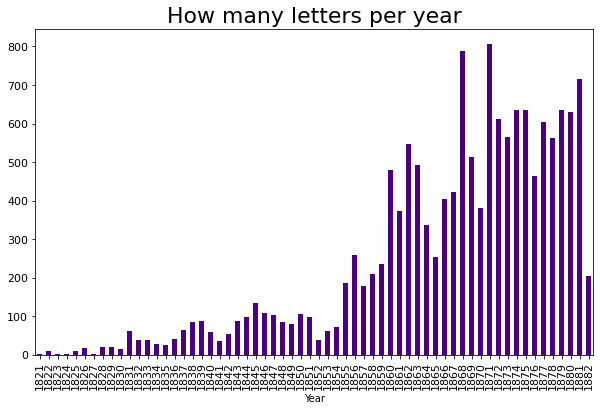

In [18]:
ax = df0.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

I check the letters containing the word _insectivorous_:

In [19]:
pd.set_option('display.max_colwidth', 60)
word_of_interest = "insectivorous"

def extract_context(text, word, window=30):
    pattern = re.compile(rf".{{0,{window}}}{word}.{{0,{window}}}", re.IGNORECASE)
    match = pattern.search(text)
    return match.group(0) if match else ''

filtered_df = df[df['Transcription'].str.contains(word_of_interest, case=False, na=False)]
filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))
# Temporarily set options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means no limit

print(filtered_df[['Year', 'Context']].sort_values(by='Year'))

# Reset options to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

       Year                                                      Context
7312   1846  ggot within; so that they are insectivorous.— A Cychrus ...
9839   1860   Feet ———–Birds of Prey. some insectivorous ————Some fis...
1009   1861  colour by the check caused by insectivorous animals. The...
4757   1862  ou sugar? Is the little Heron insectivorous? State somew...
9965   1866  a scarlet insect thus attract insectivorous birds, or fr...
14308  1867  ny one who keeps a variety of insectivorous birds. They ...
8255   1867  They have not even our little insectivorous quadruped th...
14816  1868  resume that on that island no insectivorous bird exists ...
11391  1868  ms a nice fat mouthful for an insectivorous bird, but by...
8136   1868  be exempt from the attacks of insectivorous birds; these...
12845  1868  the necessity there is for an insectivorous non-migrator...
1985   1868  t is but rarely discovered by insectivorous animals and ...
14324  1869  larvæ c. eaten or rejected by insectiv

<ipython-input-19-3e4a2d54cb03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Context'] = filtered_df['Transcription'].apply(lambda x: extract_context(x, word_of_interest))


In [20]:
filtered_df[['Year', 'Context']].groupby('Year').size().reset_index(name='count_of_texts')

,Year,count_of_texts
0,1846,1
1,1860,1
2,1861,1
3,1862,1
4,1866,1
5,1867,2
6,1868,5
7,1869,2
8,1871,2
9,1874,4


## 3. Linguistic pre-processing

**NB**: From here you can **skip** to the code line "df = pd.read_csv(os.path.join(out_folder, 'transcription_tokens.csv'), sep = "\t")"

Add a space before and after every m-dash:

In [21]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
s = pat.sub(" \\1 ", s)
pat1 = re.compile(r"(\u2013)")
s = pat1.sub(" \\1 ", s)
s = s.replace("  ", " ")
s

' –  –  – Museum three — one from'

In [22]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
s = pat.sub(" \\1 ", pat1.sub(" \\1 ", s)).replace("  ", " ")
s

' –  –  – Museum three — one from'

In [23]:
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
df['Transcription'] = [pat.sub(" \\1 ", pat1.sub(" \\1 ", df['Transcription'].iloc[i])).replace("  ", " ") for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...
...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...


In [24]:
df[df['File'] == "DCP-LETT-6078.xml"]

,File,Year,Sender,Receiver,Transcription
12845,DCP-LETT-6078.xml,1868,"Weir, J. J.","Darwin, C. R.",I was in Spitalfields recently had some furthe...


load the spaCy language model:

In [25]:
sp = spacy.load("en_core_web_sm")

I split the letters into sentences, although this step may not be needed in the end. **NB** This can take about 10 minutes.

In [26]:
df['Transcription_spacy'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t..."
...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O..."


A token simply refers to an individual part of a sentence having some semantic value. Let's see what tokens we have in our document. **NB This takes about 12 minutes**.

In [27]:
df['Tokens'] = [[word.text for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t..."
...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O..."


In [28]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
5,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– Museum three — one from Dr. Richardson who ...,"( , –, Museum, three, —, one, from, Dr., Richa...","[ , –, Museum, three, —, one, from, Dr., Richa..."


### Lemmatisation

I lemmatise the letters. **NB this can take about 12 minutes.**

In [29]:
df['Lemmas'] = [[word.lemma_ for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,..."
...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O..."


#### Stopwords exclusion and further filtering
I exclude non-alphabetical characters:

In [30]:
df["Lemmas_clean"] = ''
for i in range(df.shape[0]):
  df['Lemmas_clean'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`''']# and t.isalpha() ]
df

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,..."
...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O..."


I exclude stop words, although they will be needed for word embedding training:

In [31]:
stopWords = set(stopwords.words('english'))
df["Lemmas_nostop"] = ''
for i in range(df.shape[0]):
  df['Lemmas_nostop'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in stopWords]
df

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, objection, express, opinion, subject, vivi..."
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl...","[I, greatly, gratified, little, flatter, kind,..."
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, consider, I, intrusive, ask,..."
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,...","[many, thank, I, ., —, earth, Mivart, mean, id..."
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,...","[remember, dry, wing, goose, wish, wing, spiri..."
...,...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex...","[Dr., Hugo, de, Vries, ,, excellent, work, cli..."
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha...","[I, go, beg, favour, ., I, read, ,, great, int..."
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ...","[I, receive, letter, today, ., large, brown, f..."
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[dear, Dr., Sharpey, I, hear, Mr., Oliver, can..."


I add the language of the letters in an additional column. **NB This takes 2 minutes.**

In [32]:
transcriptions = df[['Transcription']].to_numpy().flatten().tolist()
df[['language']] = [detect(x) for x in transcriptions]

In [33]:
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-12349.xml,1879,"Darwin, C. R.","Payne, A. H.",I have no objection to express my opinion on t...,"(I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, have, no, objection, to, express, my, opin...","[I, objection, express, opinion, subject, vivi...",en
1,DCP-LETT-13057.xml,1881,"Allen, Grant","Darwin, C. R.",I was greatly gratified and not a little flatt...,"(I, was, greatly, gratified, and, not, a, litt...","[I, was, greatly, gratified, and, not, a, litt...","[I, be, greatly, gratified, and, not, a, littl...","[I, be, greatly, gratified, and, not, a, littl...","[I, greatly, gratified, little, flatter, kind,...",en
2,DCP-LETT-11898.xml,1879,"Hamilton, C. W.","Darwin, C. R.",I almost feel that you will not consider me in...,"(I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, that, you, will, not, consid...","[I, almost, feel, consider, I, intrusive, ask,...",en
3,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,"(Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, for, all, that, you, have...","[very, many, thank, for, all, that, you, have,...","[very, many, thank, for, all, that, you, have,...","[many, thank, I, ., —, earth, Mivart, mean, id...",en
4,DCP-LETT-11640.xml,1878,"Darwin, C. R.","Flower, W. H.",You will remember the dried wings of the goose...,"(You, will, remember, the, dried, wings, of, t...","[You, will, remember, the, dried, wings, of, t...","[you, will, remember, the, dry, wing, of, the,...","[you, will, remember, the, dry, wing, of, the,...","[remember, dry, wing, goose, wish, wing, spiri...",en
...,...,...,...,...,...,...,...,...,...,...,...
14911,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","(Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, ,, who, have, do, such,...","[Dr., Hugo, de, Vries, who, have, do, such, ex...","[Dr., Hugo, de, Vries, ,, excellent, work, cli...",en
14912,DCP-LETT-11881.xml,1879,"Darwin, C. R.","Vries, Hugo de",I am going to beg a favour of you. I have just...,"(I, am, going, to, beg, a, favour, of, you, .,...","[I, am, going, to, beg, a, favour, of, you, .,...","[I, be, go, to, beg, a, favour, of, you, ., I,...","[I, be, go, to, beg, a, favour, of, you, I, ha...","[I, go, beg, favour, ., I, read, ,, great, int...",en
14913,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"(I, received, your, letter, today, ., The, lar...","[I, received, your, letter, today, ., The, lar...","[I, receive, your, letter, today, ., the, larg...","[I, receive, your, letter, today, the, large, ...","[I, receive, letter, today, ., large, brown, f...",en
14914,DCP-LETT-2967.xml,1860,"Darwin, C. R.","Sharpey, William",My dear Dr. Sharpey I hear that Mr. Oliver is ...,"(My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[My, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[my, dear, Dr., Sharpey, I, hear, that, Mr., O...","[dear, Dr., Sharpey, I, hear, Mr., Oliver, can...",en


How many letters per language?

In [34]:
df[['language']].value_counts()

language
en          14880
fr             13
de             10
ca              4
af              2
pt              2
et              1
hu              1
it              1
no              1
vi              1
dtype: int64

Only keep letters in English:

In [35]:
#df = df[~df.language.isin(['de', 'fr'])]
df = df[df.language.isin(['en'])]
df.shape

(14880, 11)

We only select the letters written by Charles Darwin:

In [36]:
df1 = df[df['Sender'] == "Darwin, C. R."]
df1.shape

(8181, 11)

I check the frequencies of *insectivorous*: (In the context of pandas DataFrames, lambda functions are often used with methods like apply to perform row-wise or column-wise operations in a concise manner)

In [37]:
df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)]

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
135,DCP-LETT-10990.xml,1877,"Martins, C. F.","Darwin, C. R.",I am happy to learn that the translation into ...,"(I, am, happy, to, learn, that, the, translati...","[I, am, happy, to, learn, that, the, translati...","[I, be, happy, to, learn, that, the, translati...","[I, be, happy, to, learn, that, the, translati...","[I, happy, learn, translation, French, insecti...",en
318,DCP-LETT-11287.xml,1877,"Darwin, C. R.","Saporta, L. C. J. G. de",I thank you sincerely for your long most inter...,"(I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, you, sincerely, for, your, long, mo...","[I, thank, sincerely, long, interesting, lette...",en
662,DCP-LETT-10173.xml,1878,"Marshall, W. C.","Darwin, C. R.",I am sending you with this a plant which I sus...,"(I, am, sending, you, with, this, a, plant, wh...","[I, am, sending, you, with, this, a, plant, wh...","[I, be, send, you, with, this, a, plant, which...","[I, be, send, you, with, this, a, plant, which...","[I, send, plant, I, suspect, insectivorous, ,,...",en
727,DCP-LETT-11494.xml,1878,"Farrer, T. H.","Darwin, C. R.",I inclose a bit of Ledum which if not insectiv...,"(I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, a, bit, of, Ledum, which, if, not...","[I, inclose, bit, Ledum, insectivorous, —, cer...",en
772,DCP-LETT-10007.xml,1875,"Tait, R. L.","Darwin, C. R.",Dr. Burdon Sandersons paper on the leaf curren...,"(Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, on, the, leaf...","[Dr., Burdon, Sandersons, paper, leaf, current...",en
...,...,...,...,...,...,...,...,...,...,...,...
14353,DCP-LETT-10354.xml,1876,"Darwin, C. R.","Dallinger, W. H.",You will find at p. 404 of my Insectivorous Pl...,"(You, will, find, at, p., , 404, , of, my, I...","[You, will, find, at, p., , 404, , of, my, I...","[you, will, find, at, p., , 404, , of, my, i...","[you, will, find, at, p., , 404, , of, my, i...","[find, p., , 404, , insectivorous, plant, re...",en
14655,DCP-LETT-10619.xml,1876,"Darwin, C. R.","Carus, J. V.",I sent by this morning’s Post the 4 first perf...,"(I, sent, by, this, morning, ’s, Post, the, 4,...","[I, sent, by, this, morning, ’s, Post, the, 4,...","[I, send, by, this, morning, ’s, post, the, 4,...","[I, send, by, this, morning, ’s, post, the, 4,...","[I, send, morning, ’s, post, 4, , first, perf...",en
14780,DCP-LETT-11301.xml,1875,"Thiselton-Dyer, W. T.","Darwin, C. R.",In Insectivorous plants p. 353 you suggest tha...,"(In, Insectivorous, plants, p., , 353, , you...","[In, Insectivorous, plants, p., , 353, , you...","[in, insectivorous, plant, p., , 353, , you,...","[in, insectivorous, plant, p., , 353, , you,...","[insectivorous, plant, p., , 353, , suggest,...",en
14816,DCP-LETT-5985.xml,1868,"Weir, J. J.","Darwin, C. R.",I am very much obliged to you for your Work on...,"(I, am, very, much, obliged, to, you, for, you...","[I, am, very, much, obliged, to, you, for, you...","[I, be, very, much, obliged, to, you, for, you...","[I, be, very, much, obliged, to, you, for, you...","[I, much, obliged, work, domesticate, animal, ...",en


In [38]:
len(df[df['Lemmas'].apply(lambda x: 'insectivorous' in x)])

92

In [39]:
len(df1[df1['Lemmas'].apply(lambda x: 'insectivorous' in x)])

25

In [40]:
len(df[df['Lemmas'].apply(lambda x: 'transmutation' in x)])

44

In [101]:
len(df1[df1['Lemmas'].apply(lambda x: 'transmutation' in x)])

4

I save the dataframe to a file:

In [41]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)
df1.to_csv(os.path.join(out_folder, 'transcription_tokens_onlyDarwin.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)

NB: If you try and read the csv back as a data frame, you will see the columns containing lists of strings appearing with quotes around the list elements; this causes problems when training the Word2Vec models as the models interpret the input as a sequence of characters, rather than a sequence of tokens. So, you should not read the csv to define df and df1, but rather create it with the steps above.

## 4. Training word embeddings

Function for printing the vocabulary of a model

In [42]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [43]:
pd.set_option('display.max_colwidth', -1)
(df1['Lemmas_clean']).head()

<ipython-input-43-015f88530530>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


0     [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cruelty, any, physiologist, who, in, investigation, cause, suffering, which, can, possibly, be, avoid, deserve, universal, execration, but, I, be, convinced, that, physiology, which, can, not, progress, without, experiment, on, living, animal, be, one, of, the, most, important, of, the, Sciences, that, it, will, hereafter, confer, inestimable, benefit, on, mankind, whether, or, not, it, have, already, improve, the, practice, of, medicine, be, a, question, of, comparative, insignificance, for, the, history, of, Science, shews, that, benefit, to, man, be, generally, the, indirect, result, of, the, search, for, ...]
3     [very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, by, the, identity, between, eye, of, Cephelopods, Vertebrata, I, can, not, conceive, they, must, be, transparent, furnish, with, nerve, with, a, lens, of, some, kind, the, striki

In [44]:
print(df1['Lemmas_clean'].head())

0     [I, have, no, objection, to, express, my, opinion, on, the, subject, of, vivisection, I, det, cruelty, any, physiologist, who, in, investigation, cause, suffering, which, can, possibly, be, avoid, deserve, universal, execration, but, I, be, convinced, that, physiology, which, can, not, progress, without, experiment, on, living, animal, be, one, of, the, most, important, of, the, Sciences, that, it, will, hereafter, confer, inestimable, benefit, on, mankind, whether, or, not, it, have, already, improve, the, practice, of, medicine, be, a, question, of, comparative, insignificance, for, the, history, of, Science, shews, that, benefit, to, man, be, generally, the, indirect, result, of, the, search, for, ...]
3     [very, many, thank, for, all, that, you, have, do, for, I, what, on, earth, Mivart, can, mean, by, the, identity, between, eye, of, Cephelopods, Vertebrata, I, can, not, conceive, they, must, be, transparent, furnish, with, nerve, with, a, lens, of, some, kind, the, striki

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [45]:
start = time.time()
cbow_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")
start = time.time()
cbow_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 7 seconds
It has taken 14 seconds


In [46]:
print_vocab(cbow_w5_f1_300, 10)

word #0/32801 is I
word #1/32801 is the
word #2/32801 is be
word #3/32801 is to
word #4/32801 is of
word #5/32801 is have
word #6/32801 is you
word #7/32801 is in
word #8/32801 is a


In [47]:
# Check the vocabulary
vocabulary = list(cbow_w5_f1_300.wv.index_to_key)
print(vocabulary[:20])  # Display the first 20 words in the vocabulary

['I', 'the', 'be', 'to', 'of', 'have', 'you', 'in', 'a', 'that', 'it', '\xa0', 'for', 'not', 'my', 'as', 'your', 'on', 'will', 'with']


Different parameters. **You can skip this cell.**

In [48]:
#300 dimensions:
start = time.time()
cbow_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_300 has taken", round(end - start), "seconds")
#1000 dimensions:
start = time.time()
cbow_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_1000 has taken", round(end - start), "seconds")

cbow_w5_f0_300 has taken 7 seconds
sg_w5_f1_300 has taken 25 seconds
sg_w5_f0_300 has taken 25 seconds
cbow_w10_f1_300 has taken 9 seconds
cbow_w10_f0_300 has taken 9 seconds
sg_w10_f1_300 has taken 46 seconds
sg_w10_f0_300 has taken 47 seconds
cbow_w5_f0_1000 has taken 16 seconds
sg_w5_f1_1000 has taken 58 seconds
sg_w5_f0_1000 has taken 58 seconds
cbow_w10_f1_1000 has taken 20 seconds
cbow_w10_f0_1000 has taken 20 seconds
sg_w10_f1_1000 has taken 105 seconds
sg_w10_f0_1000 has taken 106 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [49]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2024/Darwin/Code/Models/'
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8
Saving model number 9
Saving model number 10
Saving model number 11
Saving model number 12
Saving model number 13
Saving model number 14
Saving model number 15
Saving model number 16


Load the models:

In [50]:
models_folder = '/Users/barbaramcgillivray/Library/CloudStorage/OneDrive-King\'sCollegeLondon/Research/2024/Darwin/Code/Models/'
cbow_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_300"))
cbow_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_300"))
sg_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_300"))
sg_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_300"))
cbow_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_300"))
cbow_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_300"))
sg_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_300"))
sg_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_300"))
cbow_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_1000"))
cbow_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_1000"))
sg_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_1000"))
sg_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_1000"))
cbow_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_1000"))
cbow_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_1000"))
sg_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_1000"))
sg_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_1000"))
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']


Print the first ten words of the vocabulary of each model

In [117]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

cbow_w5_f1_300
word #0/32770 is I
word #1/32770 is the
word #2/32770 is be
word #3/32770 is to
word #4/32770 is of
word #5/32770 is have
word #6/32770 is you
word #7/32770 is in
word #8/32770 is a
cbow_w5_f1_1000
word #0/32770 is I
word #1/32770 is the
word #2/32770 is be
word #3/32770 is to
word #4/32770 is of
word #5/32770 is have
word #6/32770 is you
word #7/32770 is in
word #8/32770 is a
cbow_w5_f0_300
word #0/32770 is I
word #1/32770 is the
word #2/32770 is be
word #3/32770 is to
word #4/32770 is of
word #5/32770 is have
word #6/32770 is you
word #7/32770 is in
word #8/32770 is a
cbow_w5_f0_1000
word #0/32770 is I
word #1/32770 is the
word #2/32770 is be
word #3/32770 is to
word #4/32770 is of
word #5/32770 is have
word #6/32770 is you
word #7/32770 is in
word #8/32770 is a
sg_w5_f1_300
word #0/32770 is I
word #1/32770 is the
word #2/32770 is be
word #3/32770 is to
word #4/32770 is of
word #5/32770 is have
word #6/32770 is you
word #7/32770 is in
word #8/32770 is a
sg_w5_f1_1000
w

Let's look at the most similar words (i.e. neighbours) of *letter*:

In [51]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1_300 [('note', 0.9139928817749023), ('pamphlet', 0.6862996220588684), ('article', 0.6720276474952698), ('essay', 0.6141016483306885), ('paper', 0.5974324345588684), ('tour', 0.5924896001815796), ('Review', 0.5899397134780884), ('sentence', 0.5839458107948303), ('lecture', 0.5771642923355103), ('photograph', 0.5763906836509705)]
cbow_w5_f1_1000 [('note', 0.923257052898407), ('pamphlet', 0.7025864124298096), ('article', 0.6681880950927734), ('lecture', 0.6363958120346069), ('essay', 0.608431339263916), ('Review', 0.597817063331604), ('kindness', 0.5894567370414734), ('paper', 0.5883361101150513), ('sentence', 0.5805051326751709), ('review', 0.5793113112449646)]
cbow_w5_f0_300 [('note', 0.916532039642334), ('article', 0.676239013671875), ('pamphlet', 0.6580139398574829), ('paper', 0.6055560111999512), ('query', 0.6053647398948669), ('essay', 0.6015222668647766), ('message', 0.5994584560394287), ('lecture', 0.5928876399993896), ('eloge', 0.5870093703269958), ('Review', 0.57658320

#### Model choice
In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. This is the list suggested by Liz:
superfluous, unnecessary
Display, exhibit
Mimetic, imitative
Disappear, vanish
Alike, identical

In [52]:
synonyms = dict({"superfluous": "unnecessary", "display": "exhibit", "mimetic" : "imitative", "disappear" : "vanish", "alike" : "identical"})
synonyms

{'superfluous': 'unnecessary',
 'display': 'exhibit',
 'mimetic': 'imitative',
 'disappear': 'vanish',
 'alike': 'identical'}

Check that the synonym pairs are preserved by the models:

In [53]:
models_synonymity_average = dict()
for i in range(len(models)):
  print("Model", models_names[i])
  average_synonimity = 0
  synonymities = list()
  for s1 in synonyms:
    print("\tSimilarity between", s1, "and", synonyms[s1],  "in", models_names[i], models[i].wv.similarity(s1, synonyms[s1]))
    synonymities.append(models[i].wv.similarity(s1, synonyms[s1]))
  average_synonimity = mean(synonymities)
  print(average_synonimity)
  models_synonymity_average[models_names[i]] = average_synonimity
models_synonymity_average

Model cbow_w5_f1_300
	Similarity between superfluous and unnecessary in cbow_w5_f1_300 0.71622056
	Similarity between display and exhibit in cbow_w5_f1_300 0.7969637
	Similarity between mimetic and imitative in cbow_w5_f1_300 0.15807924
	Similarity between disappear and vanish in cbow_w5_f1_300 0.6716995
	Similarity between alike and identical in cbow_w5_f1_300 0.79056215
0.62670505
Model cbow_w5_f1_1000
	Similarity between superfluous and unnecessary in cbow_w5_f1_1000 0.49809176
	Similarity between display and exhibit in cbow_w5_f1_1000 0.83720267
	Similarity between mimetic and imitative in cbow_w5_f1_1000 0.30090302
	Similarity between disappear and vanish in cbow_w5_f1_1000 0.4485317
	Similarity between alike and identical in cbow_w5_f1_1000 0.76718223
0.5703823
Model cbow_w5_f0_300
	Similarity between superfluous and unnecessary in cbow_w5_f0_300 0.5856501
	Similarity between display and exhibit in cbow_w5_f0_300 0.7881892
	Similarity between mimetic and imitative in cbow_w5_f0_3

{'cbow_w5_f1_300': 0.62670505,
 'cbow_w5_f1_1000': 0.5703823,
 'cbow_w5_f0_300': 0.58696216,
 'cbow_w5_f0_1000': 0.6267979,
 'sg_w5_f1_300': 0.72851807,
 'sg_w5_f1_1000': 0.7370954,
 'sg_w5_f0_300': 0.71337354,
 'sg_w5_f0_1000': 0.7093887,
 'cbow_w10_f1_300': 0.5080891,
 'cbow_w10_f1_1000': 0.5492631,
 'cbow_w10_f0_300': 0.58495975,
 'cbow_w10_f0_1000': 0.59939075,
 'sg_w10_f1_300': 0.67785144,
 'sg_w10_f1_1000': 0.70174867,
 'sg_w10_f0_300': 0.684744,
 'sg_w10_f0_1000': 0.69603944}

I choose the model that maximises the average similarity between synonyms:

In [54]:
model_chosen_name = max(models_synonymity_average, key=models_synonymity_average.get)
for i in range(len(models)):
  if models_names[i] == model_chosen_name:
    models[i].save(os.path.join(models_folder, "Chosen_model"))
model_chosen_name

'sg_w5_f1_1000'